In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import json
import requests
from pprint import pprint
from collections import Counter

In [2]:
data_dir = "/Users/ak/tte/data/sample-data/gsm"

basline_dir = data_dir + "/baseline_pass_20_ckpt_200" 
s3c_dir = data_dir + "/s3c_trace_pass_20_ckpt_1000" 


basline_json_file_path = basline_dir + "/predict_predictions.json"
basline_stat_log_path = basline_dir + "/predict_results.json"

s3c_json_file_path = s3c_dir + "/predict_predictions.json"
s3c_stat_log_path = s3c_dir + "/predict_results.json"

In [3]:
basline_stat_log_data = pd.read_json(basline_stat_log_path, typ='series')
basline_stat_log_dict = basline_stat_log_data.to_dict()

s3c_stat_log_data = pd.read_json(s3c_stat_log_path, typ='series')
s3c_stat_log_dict = s3c_stat_log_data.to_dict()

### Basline gsm pass@20 vs s3c round 0 pass@20

In [4]:
print(f" Basline: {basline_stat_log_dict['test_raw_pass@20']}% | s3c: {s3c_stat_log_dict['test_round_0_estimated_pass@20']}%")

 Basline: 43.5178% | s3c: 36.8461%


In [5]:
basline_json = pd.read_json(basline_json_file_path)
baseline_dict = basline_json.to_dict()

In [6]:
s3c_json = pd.read_json(s3c_json_file_path)
s3c_dict = s3c_json.to_dict()

In [7]:
def get_clusters(generated_programs_dict):

    clusters_dict = {}
    clusters_list = []
    
    for prompt in generated_programs_dict:
        i = 0

        programs_list = []
        while i < len(generated_programs_dict[prompt]):
            programs_list.append( generated_programs_dict[prompt][i]['generated_program'])
            i+=1

        counts = Counter(programs_list)
        
        for cluster in counts:
            indices = [i for i in range(len(generated_programs_dict[prompt])) if programs_list[i] == cluster]
            clusters_list.append(indices)
        clusters_dict.update({prompt:clusters_list})
        clusters_list = []

    return clusters_dict

In [8]:
basline_clusters_dict = get_clusters(baseline_dict)
s3c_clusters_dict = get_clusters(s3c_dict)

In [9]:
def filter_failed_prompts(baseline_dict):
    count = 0 
    
    failed_list = []
        
    for prompt in baseline_dict:
        fail_state = True
        for output in baseline_dict[prompt]:
            if(baseline_dict[prompt][output]['compiler_output'][0] == True):
                fail_state = False
                break
        if fail_state:
            failed_list.append(prompt)
        

    return(failed_list)

In [10]:
def filter_passing_prompts(s3c_dict):
    count = 0 
    
    passed_list = []
        
    for prompt in s3c_dict:
        success_state = False
        for output in s3c_dict[prompt]:
            if(s3c_dict[prompt][output]['compiler_output'][0] == True):
                success_state = True
                break
        if success_state:
            passed_list.append(prompt)
        

    return(passed_list)

In [11]:
def filter_clusters(generated_programs_dict, clusters_dict, correct_only = None, cluster_size_range = (1,5)):
    count = 0 
    
    filtered_dict = {}
    
    for cluster_id in clusters_dict:
        # if count == 23: break #Debug early stopping
        # count+=1

        filtered_clusters_list = []
        
        for cluster in clusters_dict[cluster_id]:
            if (cluster_size_range[0] <= (len(clusters_dict[cluster_id])) <= cluster_size_range[1]):
                if correct_only == True:
                    if (generated_programs_dict[cluster_id][cluster[0]]['compiler_output'][0] == True):
                        filtered_clusters_list.append(cluster)
                elif correct_only == False:
                    if (generated_programs_dict[cluster_id][cluster[0]]['compiler_output'][0] == False):
                        #print(cluster_id, cluster[0])
                        filtered_clusters_list.append(cluster)
                else:
                    filtered_clusters_list.append(cluster)
                    
        if(len(filtered_clusters_list) > 0): filtered_dict.update({cluster_id:filtered_clusters_list})

    return(filtered_dict)

In [12]:
incorrect_baseline_clusters = filter_clusters(baseline_dict, basline_clusters_dict, False, (1, 20))

In [13]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [14]:
#pprint(filter_failed_prompts(baseline_dict))
#pprint(filter_passing_prompts(s3c_dict))

tf_intersection = intersection(filter_failed_prompts(baseline_dict), filter_passing_prompts(s3c_dict))

print( len(tf_intersection) )
print( tf_intersection )

156
['test_294', 'test_562', 'test_744', 'test_525', 'test_1121', 'test_121', 'test_779', 'test_768', 'test_850', 'test_1318', 'test_194', 'test_375', 'test_1053', 'test_239', 'test_31', 'test_857', 'test_1036', 'test_729', 'test_879', 'test_95', 'test_960', 'test_929', 'test_771', 'test_311', 'test_442', 'test_656', 'test_557', 'test_923', 'test_791', 'test_608', 'test_318', 'test_1220', 'test_1026', 'test_790', 'test_1144', 'test_53', 'test_1259', 'test_1050', 'test_848', 'test_891', 'test_829', 'test_1249', 'test_508', 'test_18', 'test_60', 'test_644', 'test_1083', 'test_1228', 'test_596', 'test_634', 'test_893', 'test_1082', 'test_276', 'test_964', 'test_438', 'test_147', 'test_1047', 'test_349', 'test_707', 'test_1000', 'test_1014', 'test_840', 'test_760', 'test_762', 'test_1237', 'test_906', 'test_667', 'test_39', 'test_35', 'test_852', 'test_523', 'test_1114', 'test_682', 'test_726', 'test_636', 'test_348', 'test_231', 'test_1013', 'test_1301', 'test_88', 'test_289', 'test_661',

In [15]:
reversed_tf_intersection = intersection(filter_failed_prompts(s3c_dict), filter_passing_prompts(baseline_dict))
print(len(reversed_tf_intersection))
print(reversed_tf_intersection)

186
['test_412', 'test_1248', 'test_1187', 'test_1217', 'test_394', 'test_397', 'test_836', 'test_1058', 'test_142', 'test_51', 'test_838', 'test_166', 'test_670', 'test_206', 'test_1261', 'test_386', 'test_1115', 'test_1279', 'test_839', 'test_1221', 'test_396', 'test_506', 'test_652', 'test_748', 'test_1182', 'test_1125', 'test_21', 'test_801', 'test_1081', 'test_807', 'test_841', 'test_173', 'test_253', 'test_308', 'test_997', 'test_556', 'test_107', 'test_1009', 'test_360', 'test_485', 'test_783', 'test_1005', 'test_742', 'test_796', 'test_1099', 'test_885', 'test_1246', 'test_135', 'test_1209', 'test_16', 'test_750', 'test_118', 'test_1167', 'test_196', 'test_191', 'test_578', 'test_715', 'test_653', 'test_530', 'test_50', 'test_724', 'test_1198', 'test_495', 'test_930', 'test_1170', 'test_837', 'test_1233', 'test_519', 'test_697', 'test_577', 'test_951', 'test_502', 'test_1111', 'test_1264', 'test_19', 'test_291', 'test_1275', 'test_983', 'test_1273', 'test_1019', 'test_470', 'te

In [16]:
len(filter_failed_prompts(baseline_dict)), len(filter_failed_prompts(s3c_dict))

(745, 775)

In [17]:
len( intersection(filter_failed_prompts(s3c_dict), filter_failed_prompts(baseline_dict)) )

589

In [18]:
len(filter_passing_prompts(baseline_dict)), len(filter_passing_prompts(s3c_dict))

(574, 544)

In [19]:
print(30/1300)

0.023076923076923078


In [20]:
len(baseline_dict), len(s3c_dict)

(1319, 1319)

In [21]:
basline_clusters_dict['test_743']

[[0, 7, 13, 17, 18],
 [1, 2, 4, 5, 6, 8, 11, 14, 15],
 [3],
 [9, 10],
 [12],
 [16],
 [19]]

In [22]:
tf_intersection = intersection(filter_failed_prompts(baseline_dict), filter_passing_prompts(s3c_dict))

In [23]:
incorrect_baseline_clusters = filter_clusters(baseline_dict, basline_clusters_dict, False, (1, 20))
correct_s3c_clusters = filter_clusters(s3c_dict, s3c_clusters_dict, True, (1, 20))

In [24]:
pprint(baseline_dict['test_1272'][0]['prompt'])

('QUESTION:\n'
 'Helen went on a trip through Germany. She booked a hotel for 3 nights and '
 'rode the bus 7 times during that trip. One night at the hotel was a cost of '
 '$80, and every bus trip was 10% of the price of one night at the hotel. How '
 'much did Helen pay for the hotel and bus travels during that trip?\n'
 'ANSWER:\n')


In [25]:
def get_longest(lst):
    return max(lst, key=len)

def find_overlap( tf_intersection, baseline_dict, s3c_dict, incorrect_basline_clusters, correct_s3c_clusters, false_to_true = True): #Print the cases where one model gets the answer wrong and the other gets it right
    count = 0
    for prompt in tf_intersection:
        #print(s3c_clusters_dict[prompt])
        
        if false_to_true:
            basline_msg = "Incorrect Baseline Generation: \n"
            s3c_msg = "Correct S3C Generation: \n"
            
        else:
            basline_msg = "Correct Baseline Generation: \n"
            s3c_msg = "Incorrect S3C Generation: \n"            
        
        if prompt in incorrect_basline_clusters and prompt in correct_s3c_clusters:
            basline_cluster = (get_longest(incorrect_basline_clusters[prompt])) #longest wrong baseline cluster
            s3c_cluster = (get_longest(correct_s3c_clusters[prompt])) #longest correct s3c cluster
        
            if s3c_dict[prompt][s3c_cluster[0]]['round_no'] == 0: 
                print( f"Prompt: {prompt} \n")
                print(f"Count: {count}")
                count+=1
                print(basline_msg)
                print( baseline_dict[prompt][basline_cluster[0]]['generated_program'] )

                gt_ans = baseline_dict[prompt][basline_cluster[0]]['expected_answer']
                gen_ans_b = baseline_dict[prompt][basline_cluster[0]]['compiler_output'][2]
                print(f"Generated Answer: {gen_ans_b}") 

                print("----------------------------------------------------------------")

                print(s3c_msg)
                print( s3c_dict[prompt][s3c_cluster[0]]['generated_program'] )

                #gt_ans_s3 = s3c_dict[prompt][s3c_cluster[0]]['expected_answer']
                gen_ans_s3 = s3c_dict[prompt][s3c_cluster[0]]['compiler_output'][2]
                print(f"Generated Answer: {gen_ans_s3}") 
                print("----------------------------------------------------------------")
                
                print("Ground Truth Program: \n")
                print( baseline_dict[prompt][0]['ground_truth_program'] )
                print(f"Ground Truth Answer: {gt_ans}") 
                
                print("----------------------------------------------------------------")
                print("Notes: ")
                print("|=================================================================================================================================|\n")
        

In [26]:
#find_overlap(tf_intersection, baseline_dict, s3c_dict, incorrect_baseline_clusters, correct_s3c_clusters) #Print cases where basline solved the prompt incorrect and s3c solved it correctly

In [27]:
correct_baseline_clusters = filter_clusters(baseline_dict, basline_clusters_dict, True, (1, 20))
incorrect_s3c_clusters = filter_clusters(s3c_dict, s3c_clusters_dict, False, (1, 20))

In [28]:
ft_intersection = intersection(filter_passing_prompts(baseline_dict), filter_failed_prompts(s3c_dict))

In [29]:
print(ft_intersection)

['test_412', 'test_1248', 'test_1187', 'test_1217', 'test_394', 'test_397', 'test_836', 'test_1058', 'test_142', 'test_51', 'test_838', 'test_166', 'test_670', 'test_206', 'test_1261', 'test_386', 'test_1115', 'test_1279', 'test_839', 'test_1221', 'test_396', 'test_506', 'test_652', 'test_748', 'test_1182', 'test_1125', 'test_21', 'test_801', 'test_1081', 'test_807', 'test_841', 'test_173', 'test_253', 'test_308', 'test_997', 'test_556', 'test_107', 'test_1009', 'test_360', 'test_485', 'test_783', 'test_1005', 'test_742', 'test_796', 'test_1099', 'test_885', 'test_1246', 'test_135', 'test_1209', 'test_16', 'test_750', 'test_118', 'test_1167', 'test_196', 'test_191', 'test_578', 'test_715', 'test_653', 'test_530', 'test_50', 'test_724', 'test_1198', 'test_495', 'test_930', 'test_1170', 'test_837', 'test_1233', 'test_519', 'test_697', 'test_577', 'test_951', 'test_502', 'test_1111', 'test_1264', 'test_19', 'test_291', 'test_1275', 'test_983', 'test_1273', 'test_1019', 'test_470', 'test_6

In [30]:
import networkx as nx
import networkx.algorithms.isomorphism as iso
import matplotlib.pyplot as plt
import re

# Function to parse the string and extract variables, values, operators, and dependencies
def parse_string_to_graph(string):
    graph = nx.DiGraph()
    values = {}

    lines = string.strip().split("\n")
    for idx, line in enumerate(lines):
        line = line.strip()
        match = re.match(r"([a-zA-Z0-9]+)=(.+)", line)
        if match:
            var = match.group(1)
            expr = match.group(2)

            # Find dependencies and operators using regex
            dependencies = re.findall(r"([a-zA-Z][a-zA-Z0-9]*)", expr)
            operators = re.findall(r"([\*+/-])", expr)
            
            for i, op in enumerate(operators):
                op_node = f"{idx}:({op})"
                # add edges for operands and operations
                graph.add_edge(dependencies[i], op_node)
                graph.add_edge(dependencies[i+1], op_node)
                graph.add_edge(op_node, var)
                
                # calculate the value
                if op == '*':
                    values[var] = values[dependencies[i]] * values[dependencies[i+1]]
                elif op == '+':
                    values[var] = values[dependencies[i]] + values[dependencies[i+1]]
                elif op == '-':
                    values[var] = values[dependencies[i]] - values[dependencies[i+1]]
                elif op == '/':
                    values[var] = values[dependencies[i]] / values[dependencies[i+1]]

            # If no operator is found, then it's a direct assignment
            if not operators:
                try:
                    value = int(expr)
                except ValueError:
                    # If not, it's a floating-point value
                    value = float(expr)
                values[var] = value
                graph.add_node(var, value=values[var])
            else:
                graph.add_node(var, value=values[var])

    return graph

# Define the input string
correct_string = """
n0=20
n1=12
n2=4000
n3=3
t0=n0*n1
t1=n2*t0
answer=t1*n3
"""

incorrect_string = """
n0=200
n1=20
n2=4000
n3=3
t0=n0+n1
t1=n2*t0
answer=t1*n3
"""

# # Create the graph for the input string
# baseline_graph = parse_string_to_graph(correct_string)
# s3c_graph = parse_string_to_graph(incorrect_string)

# Create label mapping
# baseline_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in baseline_graph.nodes(data=True)}
# s3c_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in s3c_graph.nodes(data=True)}

In [31]:
# Function to set variable values and operators as attributes and labels in the graph nodes
def set_node_attributes(graph, var_values, operator_values):
    for node, data in graph.nodes(data=True):
        if "value" in data:
            value = data["value"]
            data["label"] = f"{node}:{value}"
            data["color"] = "red" if node in var_values and var_values[node] != value else "lightblue"
        elif "expression" in data:
            expression = data["expression"]
            data["label"] = expression
            data["color"] = "red" if node in operator_values and operator_values[node] != expression else "lightblue"
        else:
            data["label"] = node
            data["color"] = "lightblue"

In [82]:
def display_graphs(correct_string, incorrect_string):
    # Create the graph for the input string
    baseline_graph = parse_string_to_graph(correct_string)
    s3c_graph = parse_string_to_graph(incorrect_string)

    # Create label mapping
    baseline_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in baseline_graph.nodes(data=True)}
    s3c_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in s3c_graph.nodes(data=True)}    
    
    # Create a subgraph isomorphism matcher
    matcher = iso.DiGraphMatcher(baseline_graph, s3c_graph)

    # Find all subgraph isomorphisms (common patterns)
    subgraph_matches = list(matcher.subgraph_isomorphisms_iter())

    # Find the nodes with the same variable names in both graphs
    shared_variable_nodes = set(baseline_graph.nodes()) & set(s3c_graph.nodes())

    # Get the variable values for each graph
    var_values_baseline = nx.get_node_attributes(baseline_graph, "value")
    var_values_s3c = nx.get_node_attributes(s3c_graph, "value")

    # Identify nodes with different values between the graphs
    different_value_nodes = {node for node in shared_variable_nodes if var_values_baseline.get(node) != var_values_s3c.get(node)}

    # Get the expressions for each graph
    expressions_baseline = {node: data["expression"] for node, data in baseline_graph.nodes(data=True) if "expression" in data}
    expressions_s3c = {node: data["expression"] for node, data in s3c_graph.nodes(data=True) if "expression" in data}

    # Identify nodes with different expressions between the graphs
    different_expression_nodes = {node for node in shared_variable_nodes if expressions_baseline.get(node) != expressions_s3c.get(node)}

    # Set node attributes and labels for visualization
    set_node_attributes(baseline_graph, var_values_baseline, expressions_baseline)
    set_node_attributes(s3c_graph, var_values_s3c, expressions_s3c)


    # Compare the operators between the graphs
    operator_values_baseline = {node: data["expression"] for node, data in baseline_graph.nodes(data=True) if "expression" in data}
    operator_values_s3c = {node: data["expression"] for node, data in s3c_graph.nodes(data=True) if "expression" in data}
    different_operator_nodes = {node for node in set(operator_values_baseline) & set(operator_values_s3c) if operator_values_baseline[node] != operator_values_s3c[node]}

    # Find the nodes and edges that are unique to each graph
    unique_nodes_baseline = set(node for node in baseline_graph.nodes() if node not in s3c_graph.nodes() or (node in shared_variable_nodes and var_values_baseline.get(node) != var_values_s3c.get(node)))
    unique_nodes_s3c = set(node for node in s3c_graph.nodes() if node not in baseline_graph.nodes() or (node in shared_variable_nodes and var_values_s3c.get(node) != var_values_baseline.get(node)))

    unique_edges_baseline = set((u, v) for u, v, data in baseline_graph.edges(data=True) if (u, v) not in s3c_graph.edges() and data.get("operator") is None)
    unique_edges_s3c = set((u, v) for u, v, data in s3c_graph.edges(data=True) if (u, v) not in baseline_graph.edges() and data.get("operator") is None)

    # Create a new figure and axis for drawing the graphs
    fig, axes = plt.subplots(1, 2, figsize=(13, 6))

    # Draw the baseline graph
    axes[0].set_title("Correct Baseline Generation")
    pos_baseline = nx.spring_layout(baseline_graph, seed=42)
    labels_baseline = nx.get_node_attributes(baseline_graph, "label")
    colors_baseline = nx.get_node_attributes(baseline_graph, "color")
    nx.draw(baseline_graph, pos=pos_baseline, labels=labels_baseline, node_color=list(colors_baseline.values()), node_size=500, font_size=10, ax=axes[0])

    # Draw the s3c graph
    axes[1].set_title("Incorrect S3C Generation")
    pos_s3c = nx.spring_layout(s3c_graph, seed=42)
    labels_s3c = nx.get_node_attributes(s3c_graph, "label")
    colors_s3c = nx.get_node_attributes(s3c_graph, "color")
    nx.draw(s3c_graph, pos=pos_s3c, labels=labels_s3c, node_color=list(colors_s3c.values()), node_size=500, font_size=10, ax=axes[1])

    # Highlight nodes with different values between the graphs in red
    nx.draw_networkx_nodes(s3c_graph, pos=pos_s3c, nodelist=different_value_nodes, node_color="red", node_size=500, ax=axes[1])

    # Highlight nodes with different expressions between the graphs in red
    nx.draw_networkx_nodes(s3c_graph, pos=pos_s3c, nodelist=different_expression_nodes, node_color="red", node_size=500, ax=axes[1])


    # Highlight nodes with different operators between the graphs in red
    nx.draw_networkx_nodes(s3c_graph, pos=pos_s3c, nodelist=unique_nodes_s3c, node_color="pink", node_size=500, ax=axes[1])

    plt.tight_layout()
    plt.show()

    # Print the unique nodes and edges in each graph
    print("Unique nodes in Baseline Graph:", unique_nodes_baseline)
    print("Unique nodes in S3C Graph:", unique_nodes_s3c)

    print("Unique edges in Baseline Graph:", unique_edges_baseline)
    print("Unique edges in S3C Graph:", unique_edges_s3c)


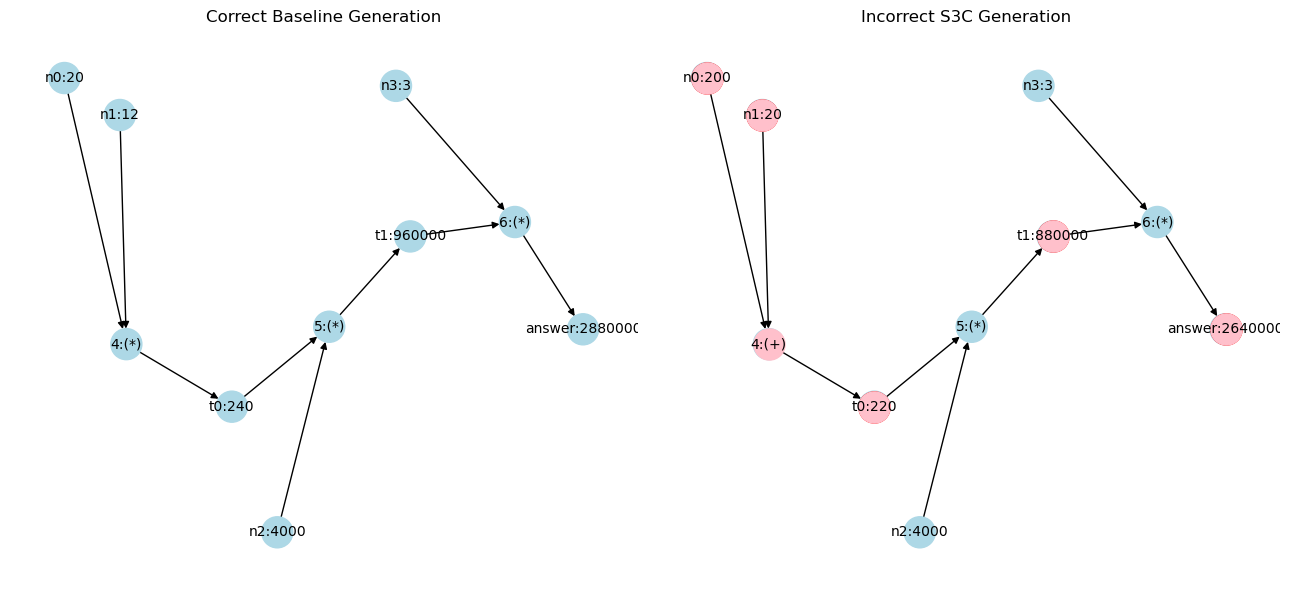

Unique nodes in Baseline Graph: {'t0', 'n0', '4:(*)', 't1', 'n1', 'answer'}
Unique nodes in S3C Graph: {'t0', 'n0', '4:(+)', 't1', 'n1', 'answer'}
Unique edges in Baseline Graph: {('4:(*)', 't0'), ('n0', '4:(*)'), ('n1', '4:(*)')}
Unique edges in S3C Graph: {('4:(+)', 't0'), ('n0', '4:(+)'), ('n1', '4:(+)')}


In [83]:
display_graphs(correct_string, incorrect_string)

In [79]:
def print_graph_comparisons(tf_intersection, baseline_dict, s3c_dict, incorrect_basline_clusters, correct_s3c_clusters): #Print the cases where one model gets the answer wrong and the other gets it right
    count = 0
    for prompt in tf_intersection:
        #print(s3c_clusters_dict[prompt])    
        
        if prompt in incorrect_basline_clusters and prompt in correct_s3c_clusters:
            basline_cluster = (get_longest(incorrect_basline_clusters[prompt])) #longest wrong baseline cluster
            s3c_cluster = (get_longest(correct_s3c_clusters[prompt])) #longest correct s3c cluster
        
            if s3c_dict[prompt][s3c_cluster[0]]['round_no'] == 0: 
                
                basline_program = baseline_dict[prompt][basline_cluster[0]]['generated_program']
                s3c_program = s3c_dict[prompt][s3c_cluster[0]]['generated_program']
                
                display_graphs(basline_program, s3c_program)

                gt_ans = baseline_dict[prompt][basline_cluster[0]]['expected_answer']
                gen_ans_b = baseline_dict[prompt][basline_cluster[0]]['compiler_output'][2]
                gen_ans_s3 = s3c_dict[prompt][s3c_cluster[0]]['compiler_output'][2]
                print(f"Basline Generated Answer: {gen_ans_b}, S3C Generated Answer: {gen_ans_s3}, GT Answer {gt_ans}") 
                
                print("----------------------------------------------------------------")

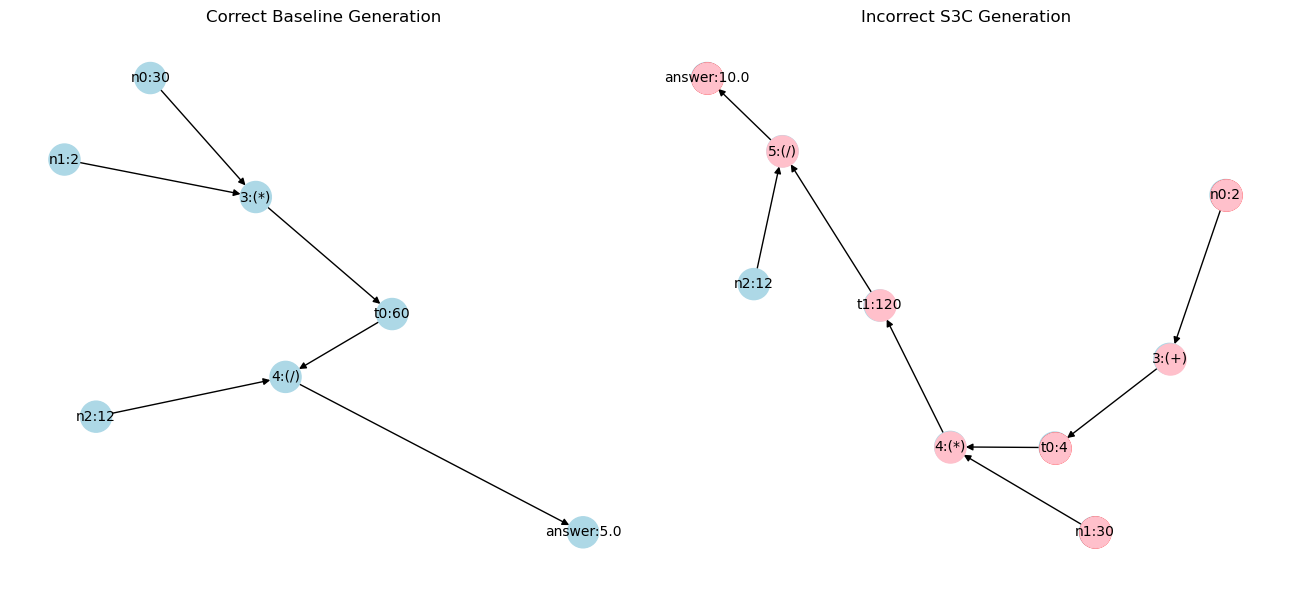

Unique nodes in Baseline Graph: {'t0', '4:(/)', '3:(*)', 'n0', 'n1', 'answer'}
Unique nodes in S3C Graph: {'t0', '3:(+)', 'n0', '5:(/)', '4:(*)', 't1', 'n1', 'answer'}
Unique edges in Baseline Graph: {('n0', '3:(*)'), ('4:(/)', 'answer'), ('n2', '4:(/)'), ('t0', '4:(/)'), ('n1', '3:(*)'), ('3:(*)', 't0')}
Unique edges in S3C Graph: {('5:(/)', 'answer'), ('3:(+)', 't0'), ('n0', '3:(+)'), ('t1', '5:(/)'), ('n1', '4:(*)'), ('t0', '4:(*)'), ('4:(*)', 't1'), ('n2', '5:(/)')}
Basline Generated Answer: 5.0, S3C Generated Answer: 10.0, GT Answer 5.0
----------------------------------------------------------------


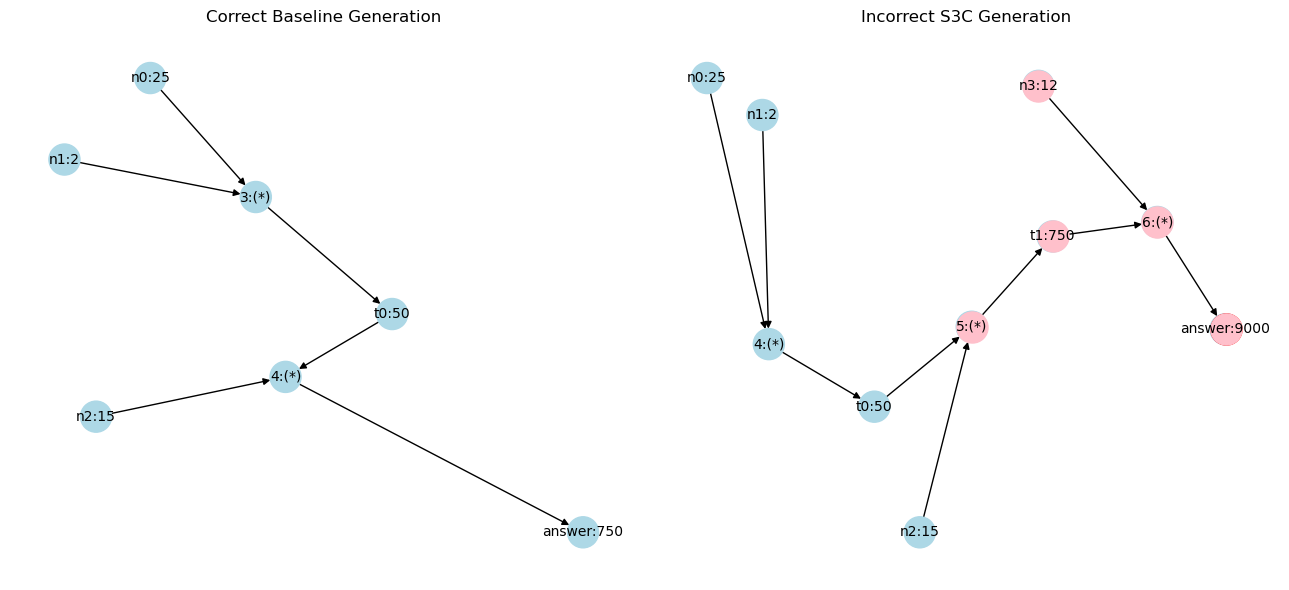

Unique nodes in Baseline Graph: {'3:(*)', 'answer'}
Unique nodes in S3C Graph: {'n3', '5:(*)', '6:(*)', 't1', 'answer'}
Unique edges in Baseline Graph: {('n0', '3:(*)'), ('4:(*)', 'answer'), ('t0', '4:(*)'), ('n2', '4:(*)'), ('n1', '3:(*)'), ('3:(*)', 't0')}
Unique edges in S3C Graph: {('t0', '5:(*)'), ('n2', '5:(*)'), ('4:(*)', 't0'), ('n1', '4:(*)'), ('t1', '6:(*)'), ('n3', '6:(*)'), ('6:(*)', 'answer'), ('n0', '4:(*)'), ('5:(*)', 't1')}
Basline Generated Answer: 750, S3C Generated Answer: 9000, GT Answer 750.0
----------------------------------------------------------------


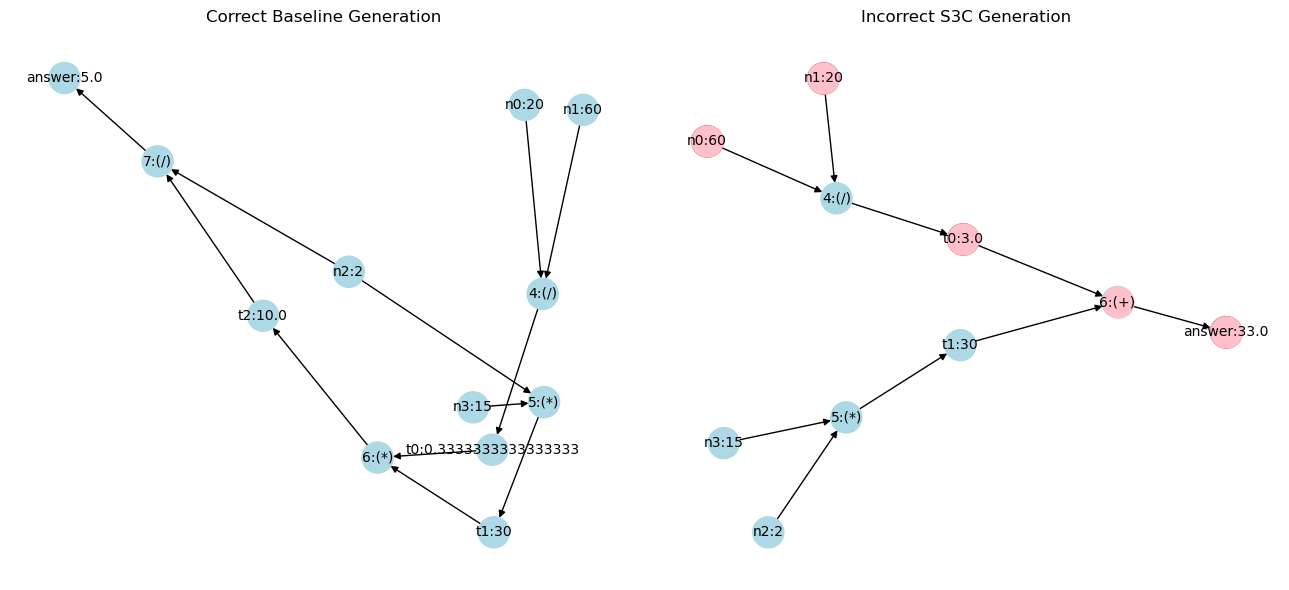

Unique nodes in Baseline Graph: {'t0', '7:(/)', 't2', 'n0', '6:(*)', 'n1', 'answer'}
Unique nodes in S3C Graph: {'t0', 'n0', '6:(+)', 'n1', 'answer'}
Unique edges in Baseline Graph: {('t0', '6:(*)'), ('6:(*)', 't2'), ('n2', '7:(/)'), ('t1', '6:(*)'), ('t2', '7:(/)'), ('7:(/)', 'answer')}
Unique edges in S3C Graph: {('t0', '6:(+)'), ('6:(+)', 'answer'), ('t1', '6:(+)')}
Basline Generated Answer: 5.0, S3C Generated Answer: 33.0, GT Answer 5.0
----------------------------------------------------------------


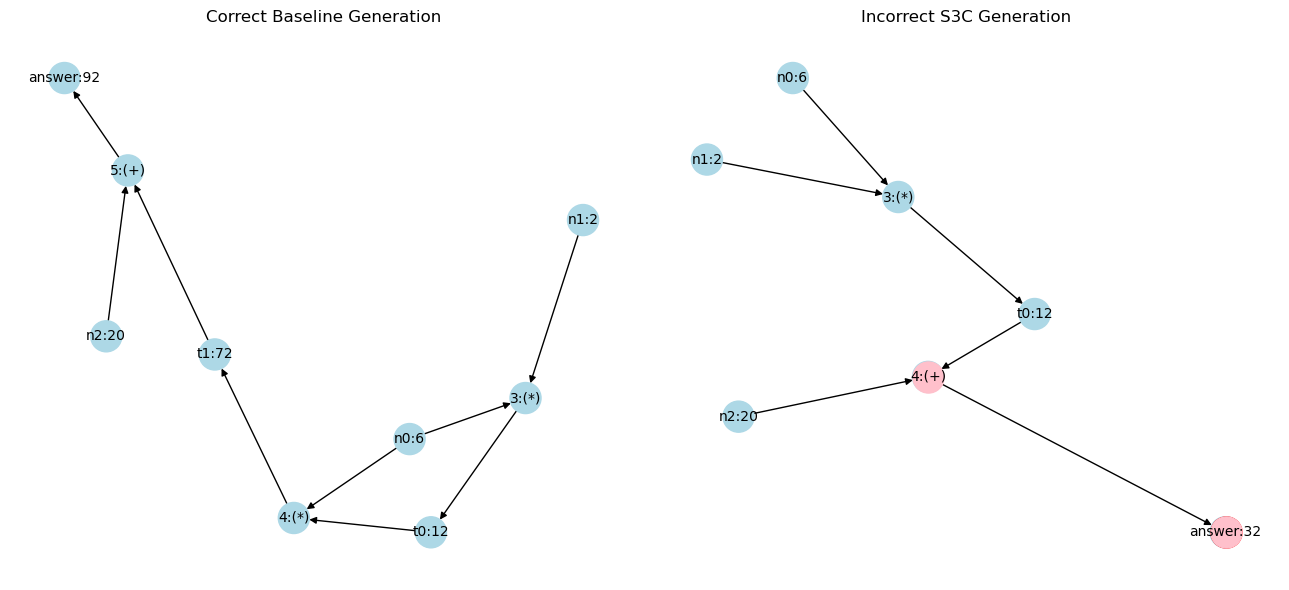

Unique nodes in Baseline Graph: {'4:(*)', 't1', '5:(+)', 'answer'}
Unique nodes in S3C Graph: {'answer', '4:(+)'}
Unique edges in Baseline Graph: {('5:(+)', 'answer'), ('t1', '5:(+)'), ('n2', '5:(+)'), ('t0', '4:(*)'), ('4:(*)', 't1'), ('n0', '4:(*)')}
Unique edges in S3C Graph: {('n2', '4:(+)'), ('4:(+)', 'answer'), ('t0', '4:(+)')}
Basline Generated Answer: 92, S3C Generated Answer: 32, GT Answer 92.0
----------------------------------------------------------------


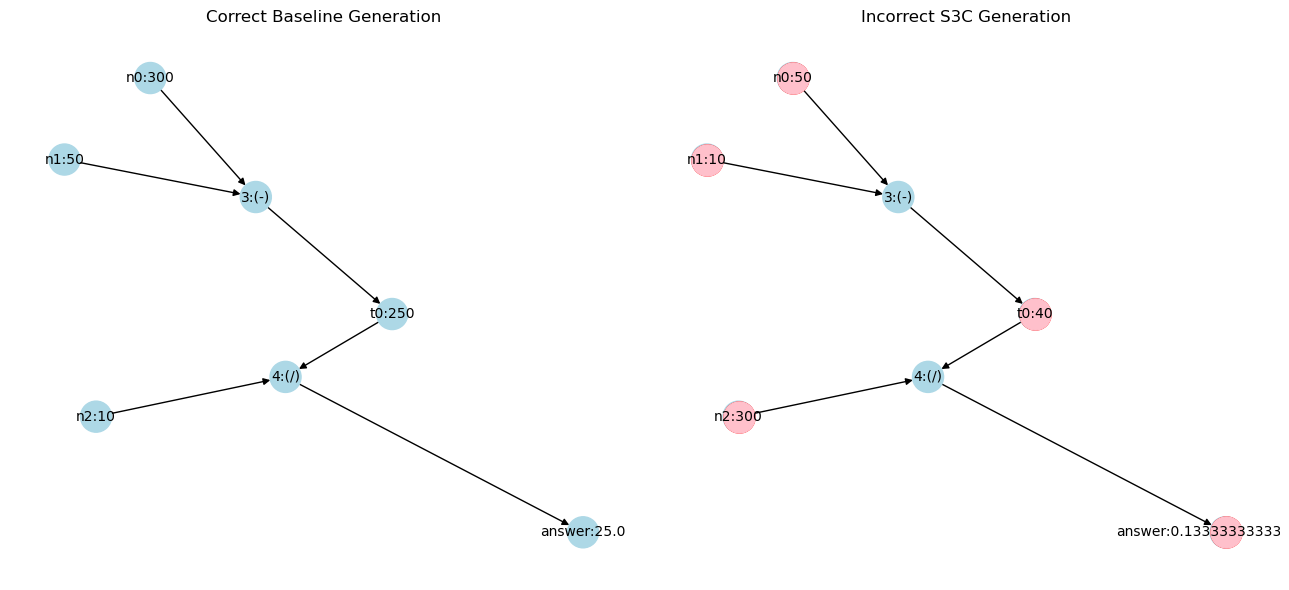

Unique nodes in Baseline Graph: {'n2', 't0', 'n0', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't0', 'n0', 'n1', 'answer'}
Unique edges in Baseline Graph: set()
Unique edges in S3C Graph: set()
Basline Generated Answer: 25.0, S3C Generated Answer: 0.13333333333333333, GT Answer 25.0
----------------------------------------------------------------


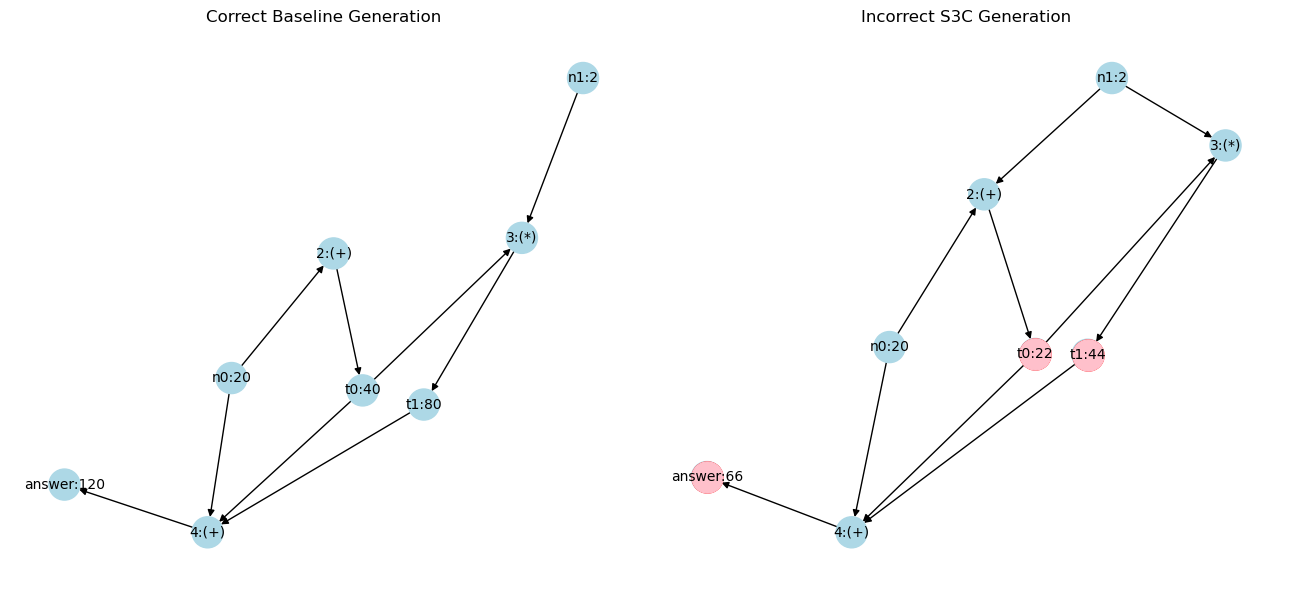

Unique nodes in Baseline Graph: {'t1', 't0', 'answer'}
Unique nodes in S3C Graph: {'t1', 't0', 'answer'}
Unique edges in Baseline Graph: set()
Unique edges in S3C Graph: {('n1', '2:(+)')}
Basline Generated Answer: 140, S3C Generated Answer: 86, GT Answer 140.0
----------------------------------------------------------------


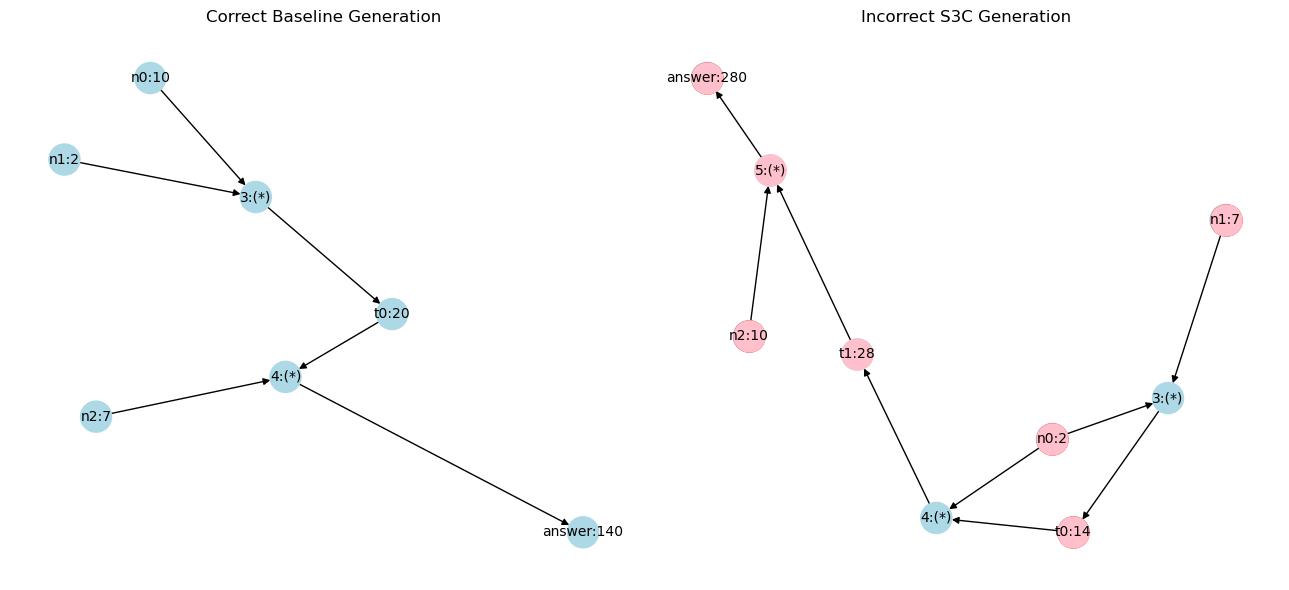

Unique nodes in Baseline Graph: {'n2', 't0', 'n0', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't0', 'n0', '5:(*)', 't1', 'n1', 'answer'}
Unique edges in Baseline Graph: {('n2', '4:(*)'), ('4:(*)', 'answer')}
Unique edges in S3C Graph: {('n2', '5:(*)'), ('n0', '4:(*)'), ('5:(*)', 'answer'), ('4:(*)', 't1'), ('t1', '5:(*)')}
Basline Generated Answer: 140, S3C Generated Answer: 280, GT Answer 140.0
----------------------------------------------------------------


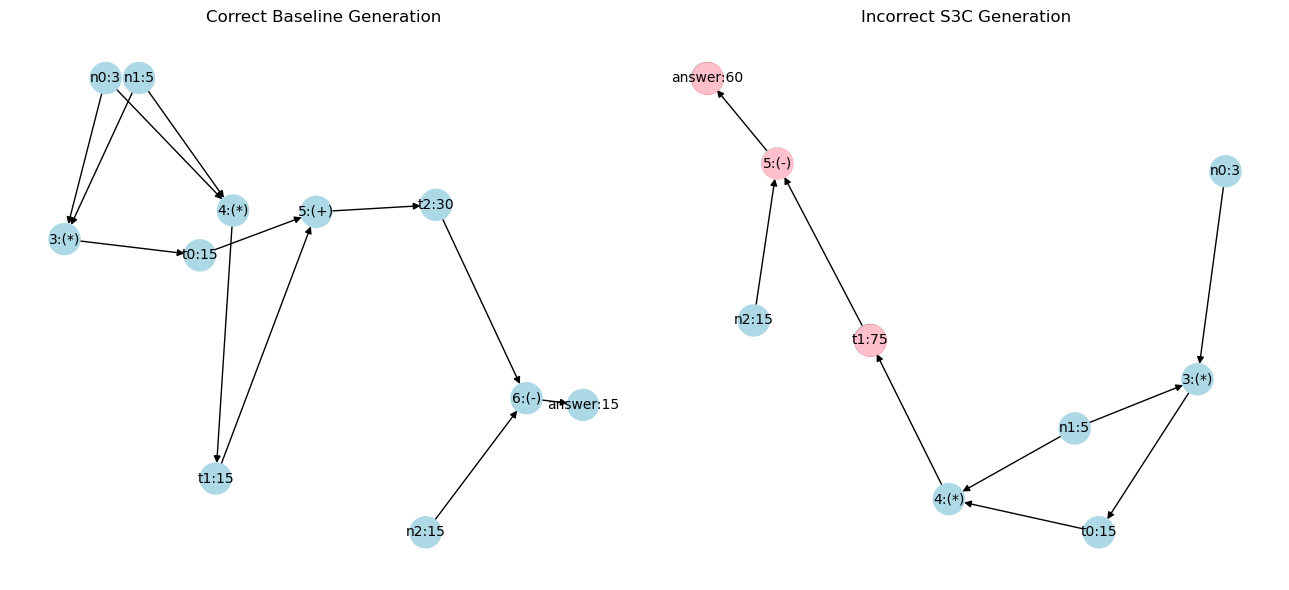

Unique nodes in Baseline Graph: {'t2', '6:(-)', '5:(+)', 't1', 'answer'}
Unique nodes in S3C Graph: {'t1', '5:(-)', 'answer'}
Unique edges in Baseline Graph: {('t1', '5:(+)'), ('6:(-)', 'answer'), ('5:(+)', 't2'), ('n2', '6:(-)'), ('t0', '5:(+)'), ('n0', '4:(*)'), ('t2', '6:(-)')}
Unique edges in S3C Graph: {('5:(-)', 'answer'), ('t1', '5:(-)'), ('t0', '4:(*)'), ('n2', '5:(-)')}
Basline Generated Answer: 15, S3C Generated Answer: 60, GT Answer 15.0
----------------------------------------------------------------


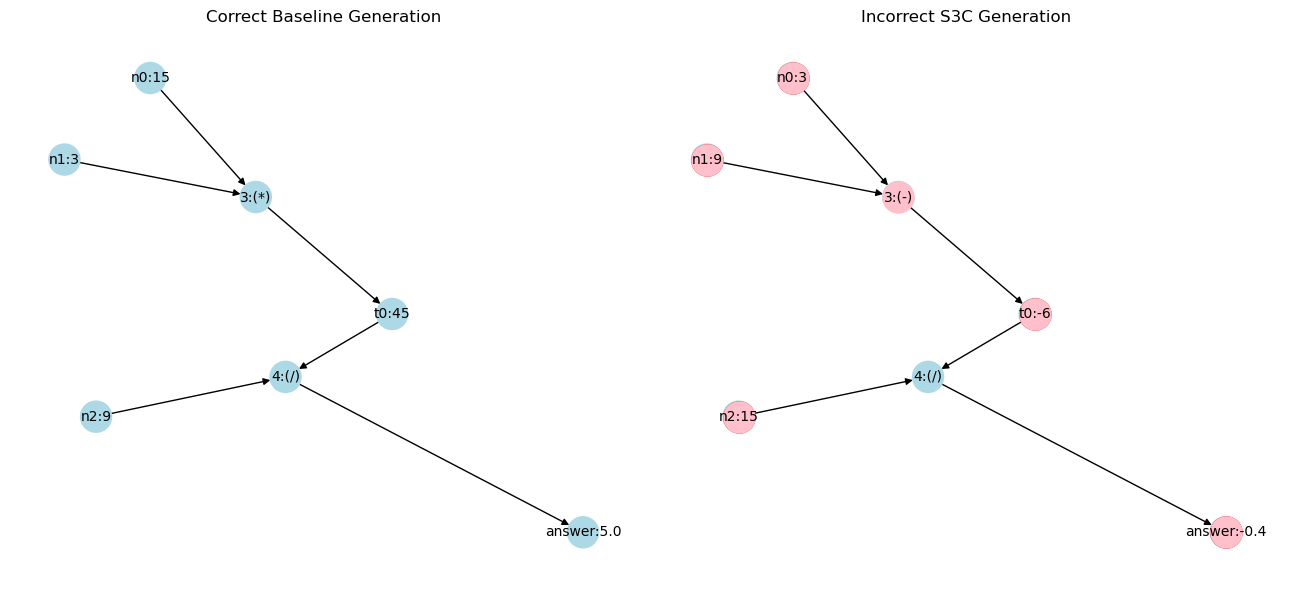

Unique nodes in Baseline Graph: {'n2', 't0', '3:(*)', 'n0', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't0', 'n0', 'n1', 'answer', '3:(-)'}
Unique edges in Baseline Graph: {('n1', '3:(*)'), ('3:(*)', 't0'), ('n0', '3:(*)')}
Unique edges in S3C Graph: {('n0', '3:(-)'), ('3:(-)', 't0'), ('n1', '3:(-)')}
Basline Generated Answer: 5.0, S3C Generated Answer: -0.4, GT Answer 5.0
----------------------------------------------------------------


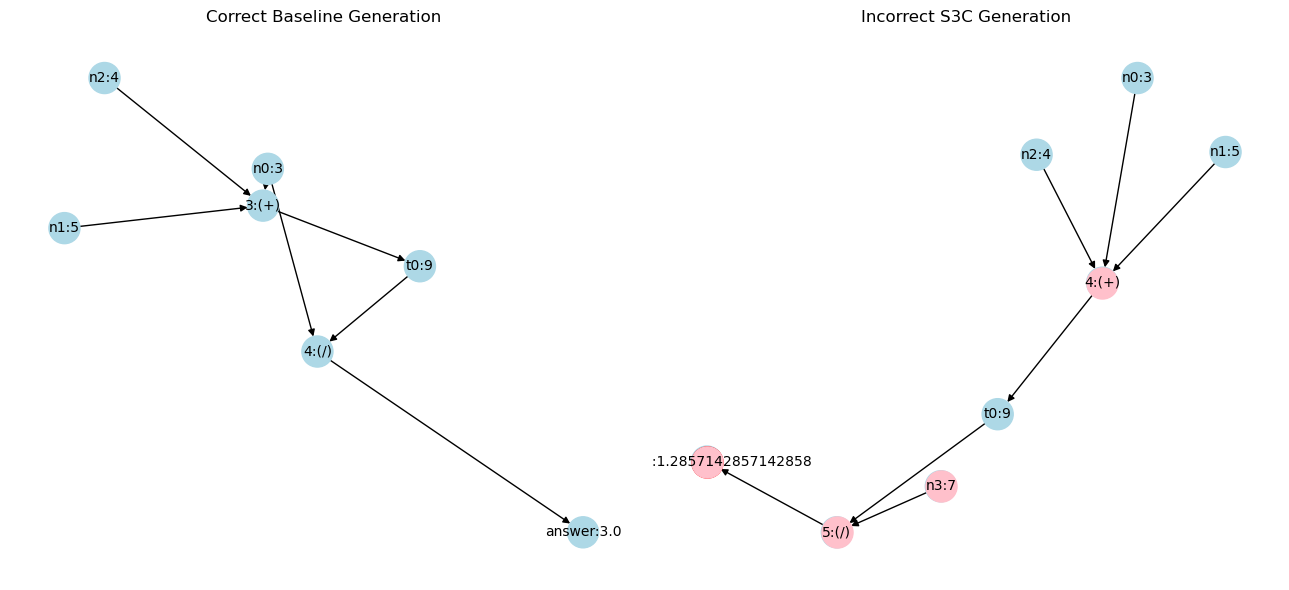

Unique nodes in Baseline Graph: {'3:(+)', '4:(/)', 'answer'}
Unique nodes in S3C Graph: {'n3', 'answer', '5:(/)', '4:(+)'}
Unique edges in Baseline Graph: {('3:(+)', 't0'), ('n2', '3:(+)'), ('n0', '3:(+)'), ('4:(/)', 'answer'), ('t0', '4:(/)'), ('n1', '3:(+)'), ('n0', '4:(/)')}
Unique edges in S3C Graph: {('5:(/)', 'answer'), ('n1', '4:(+)'), ('4:(+)', 't0'), ('n2', '4:(+)'), ('n3', '5:(/)'), ('t0', '5:(/)'), ('n0', '4:(+)')}
Basline Generated Answer: 4.0, S3C Generated Answer: 1.7142857142857142, GT Answer 4.0
----------------------------------------------------------------


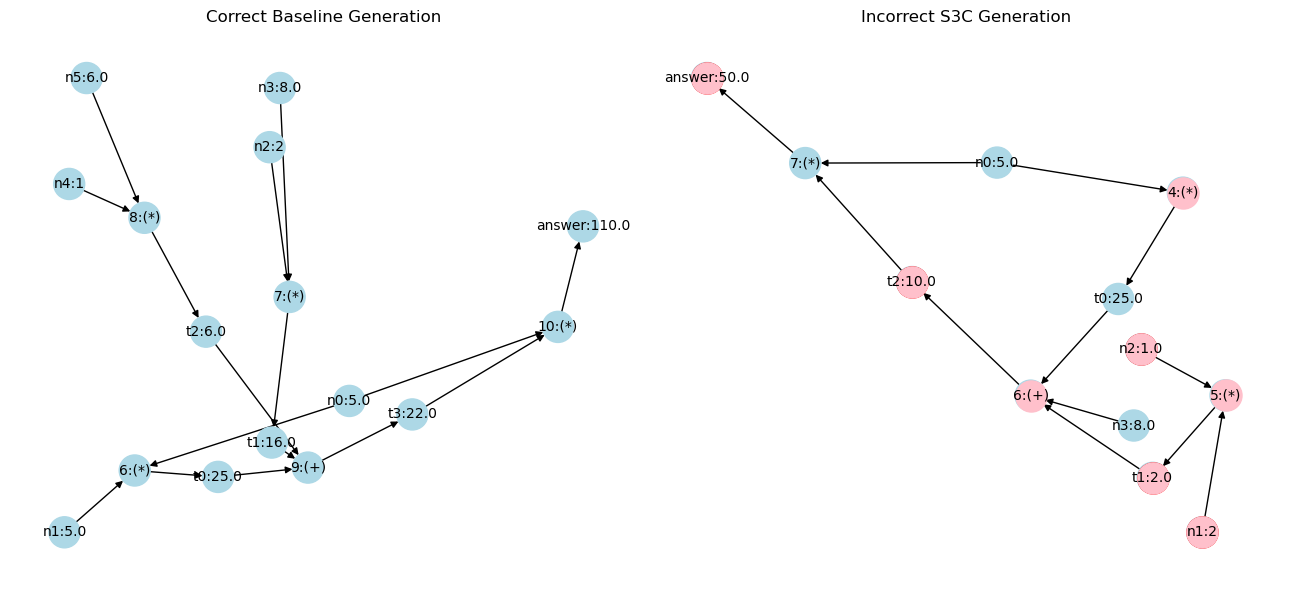

Unique nodes in Baseline Graph: {'8:(*)', 'n2', 'n5', 't2', '10:(*)', '9:(+)', '6:(*)', 't3', 'n4', 't1', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't2', '4:(*)', '5:(*)', '6:(+)', 't1', 'n1', 'answer'}
Unique edges in Baseline Graph: {('n5', '8:(*)'), ('9:(+)', 't3'), ('t3', '10:(*)'), ('n0', '6:(*)'), ('8:(*)', 't2'), ('n2', '7:(*)'), ('n0', '10:(*)'), ('t0', '9:(+)'), ('7:(*)', 't1'), ('t1', '9:(+)'), ('t2', '9:(+)'), ('n1', '6:(*)'), ('n4', '8:(*)'), ('10:(*)', 'answer'), ('6:(*)', 't0'), ('n3', '7:(*)')}
Unique edges in S3C Graph: {('t0', '6:(+)'), ('5:(*)', 't1'), ('7:(*)', 'answer'), ('n2', '5:(*)'), ('4:(*)', 't0'), ('6:(+)', 't2'), ('n0', '7:(*)'), ('t2', '7:(*)'), ('t1', '6:(+)'), ('n3', '6:(+)'), ('n0', '4:(*)'), ('n1', '5:(*)')}
Basline Generated Answer: 235.0, S3C Generated Answer: 175.0, GT Answer 235.0
----------------------------------------------------------------


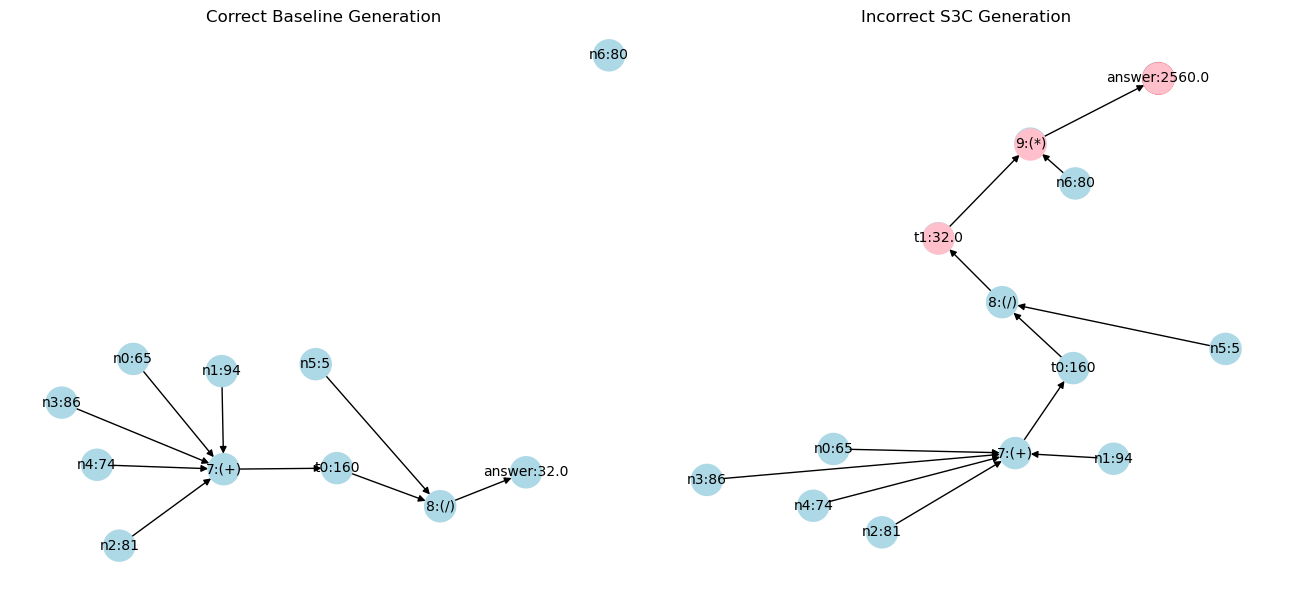

Unique nodes in Baseline Graph: {'answer'}
Unique nodes in S3C Graph: {'t1', 'answer', '9:(*)'}
Unique edges in Baseline Graph: {('8:(/)', 'answer')}
Unique edges in S3C Graph: {('n6', '9:(*)'), ('9:(*)', 'answer'), ('8:(/)', 't1'), ('t1', '9:(*)')}
Basline Generated Answer: 80.0, S3C Generated Answer: 6400.0, GT Answer 80.0
----------------------------------------------------------------


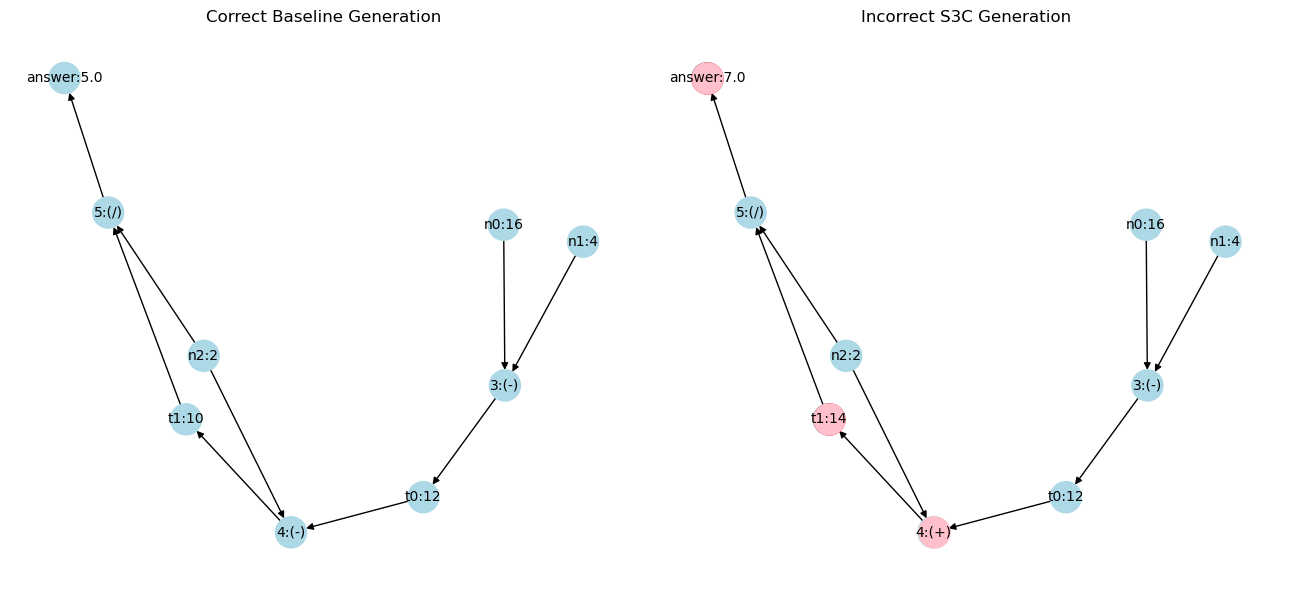

Unique nodes in Baseline Graph: {'t1', 'answer', '4:(-)'}
Unique nodes in S3C Graph: {'t1', 'answer', '4:(+)'}
Unique edges in Baseline Graph: {('n2', '4:(-)'), ('4:(-)', 't1'), ('t0', '4:(-)')}
Unique edges in S3C Graph: {('n2', '4:(+)'), ('4:(+)', 't1'), ('t0', '4:(+)')}
Basline Generated Answer: 5.0, S3C Generated Answer: 7.0, GT Answer 5.0
----------------------------------------------------------------


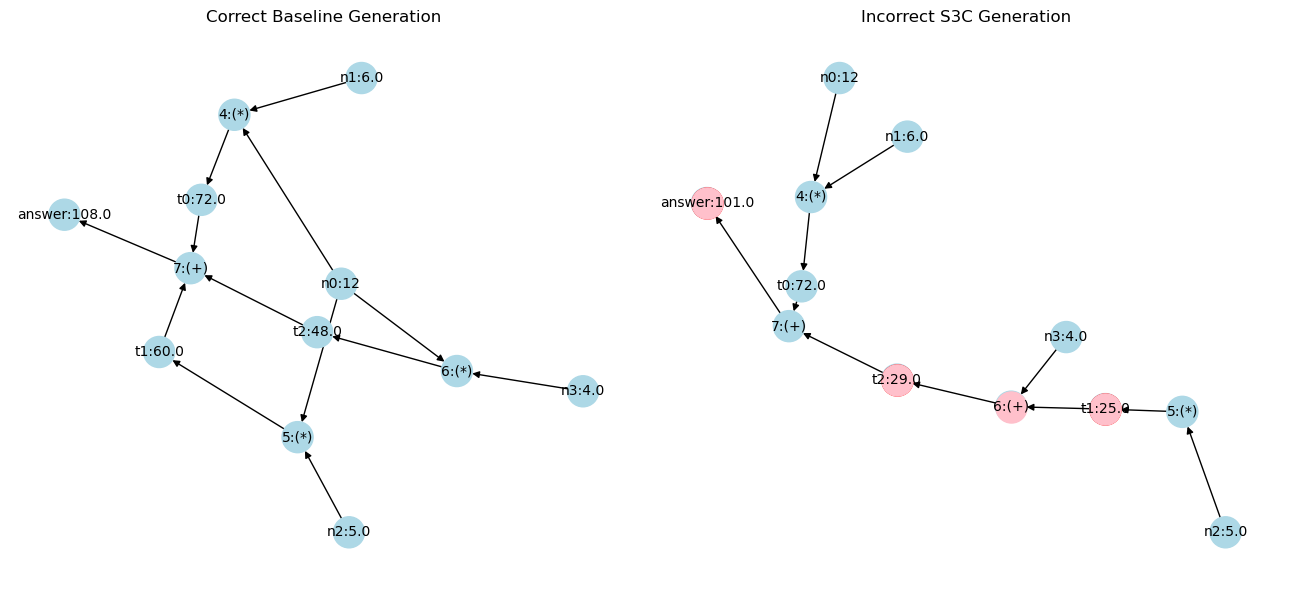

Unique nodes in Baseline Graph: {'t2', 't1', 'answer', '6:(*)'}
Unique nodes in S3C Graph: {'6:(+)', 't2', 't1', 'answer'}
Unique edges in Baseline Graph: {('n0', '6:(*)'), ('6:(*)', 't2'), ('n0', '5:(*)'), ('t1', '7:(+)'), ('n3', '6:(*)')}
Unique edges in S3C Graph: {('n3', '6:(+)'), ('6:(+)', 't2'), ('t1', '6:(+)')}
Basline Generated Answer: 180.0, S3C Generated Answer: 101.0, GT Answer 180.0
----------------------------------------------------------------


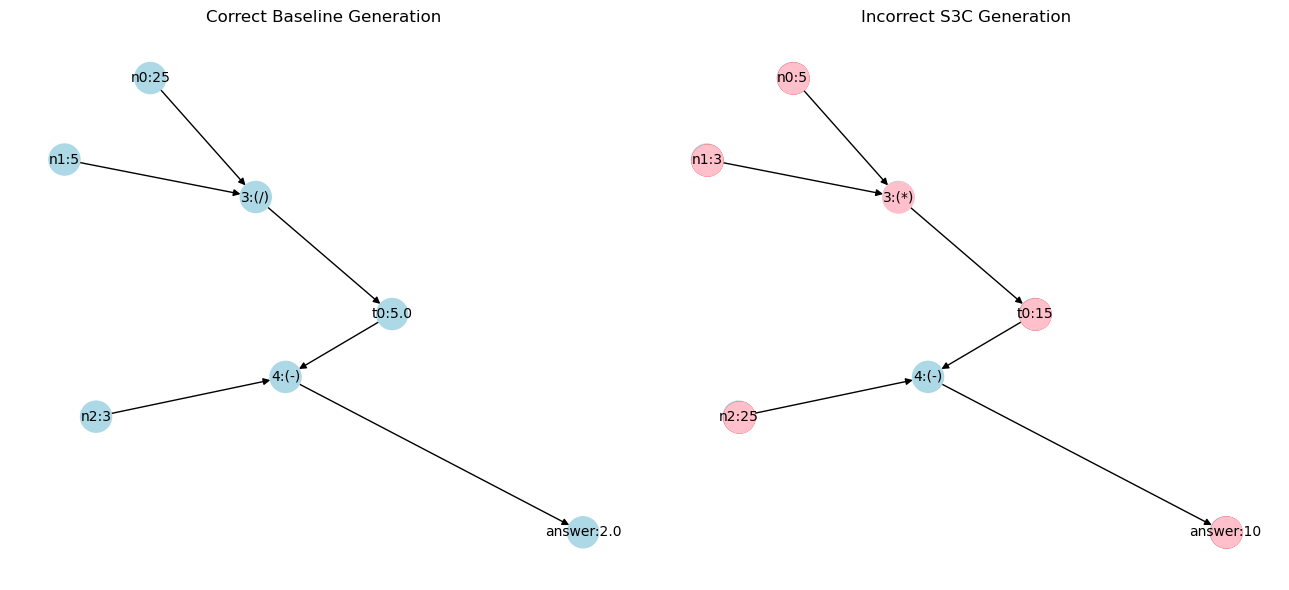

Unique nodes in Baseline Graph: {'n2', 't0', 'n0', '3:(/)', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't0', '3:(*)', 'n0', 'n1', 'answer'}
Unique edges in Baseline Graph: {('n1', '3:(/)'), ('n0', '3:(/)'), ('3:(/)', 't0')}
Unique edges in S3C Graph: {('n1', '3:(*)'), ('3:(*)', 't0'), ('n0', '3:(*)')}
Basline Generated Answer: 2.0, S3C Generated Answer: 10, GT Answer 2.0
----------------------------------------------------------------


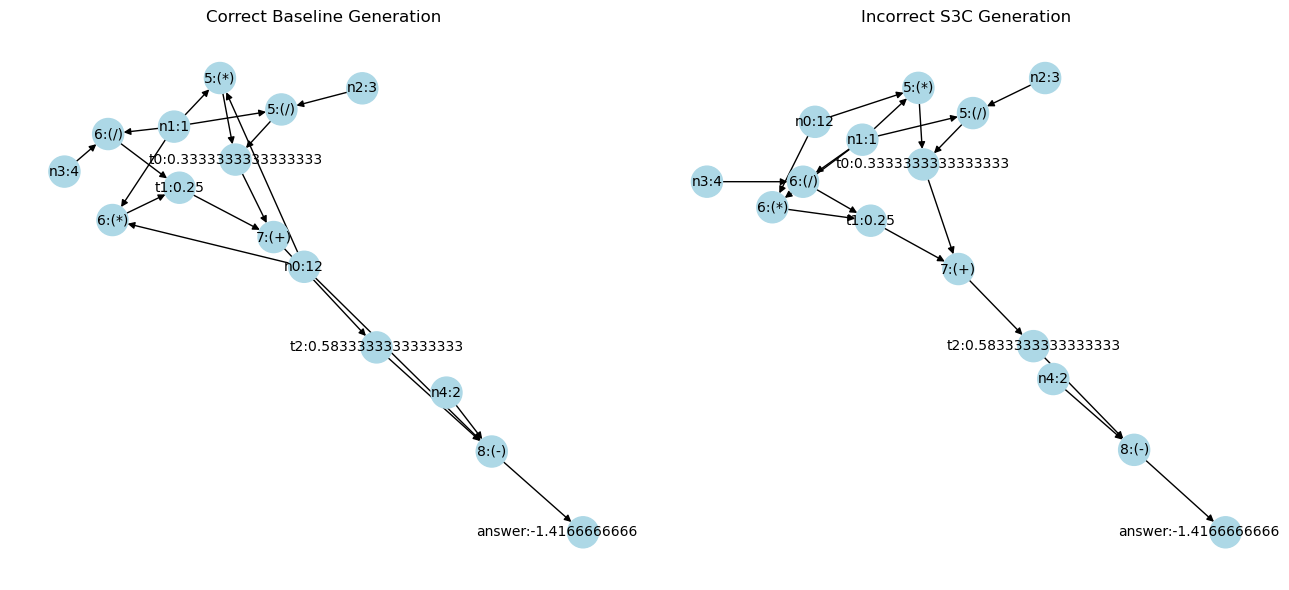

Unique nodes in Baseline Graph: set()
Unique nodes in S3C Graph: set()
Unique edges in Baseline Graph: {('n0', '8:(-)')}
Unique edges in S3C Graph: set()
Basline Generated Answer: 3.0, S3C Generated Answer: 5.0, GT Answer 3.0
----------------------------------------------------------------


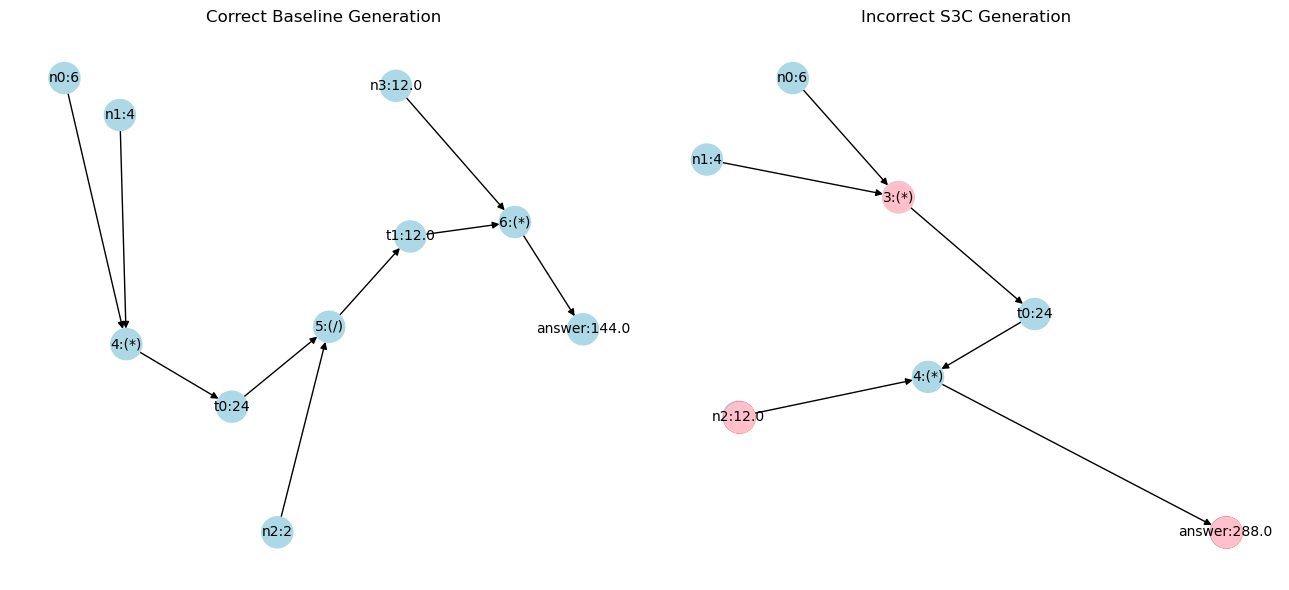

Unique nodes in Baseline Graph: {'n3', 'n2', '5:(/)', '6:(*)', 't1', 'answer'}
Unique nodes in S3C Graph: {'n2', '3:(*)', 'answer'}
Unique edges in Baseline Graph: {('4:(*)', 't0'), ('5:(/)', 't1'), ('n0', '4:(*)'), ('n1', '4:(*)'), ('t1', '6:(*)'), ('n3', '6:(*)'), ('t0', '5:(/)'), ('n2', '5:(/)'), ('6:(*)', 'answer')}
Unique edges in S3C Graph: {('n0', '3:(*)'), ('4:(*)', 'answer'), ('t0', '4:(*)'), ('n2', '4:(*)'), ('n1', '3:(*)'), ('3:(*)', 't0')}
Basline Generated Answer: 144.0, S3C Generated Answer: 288.0, GT Answer 144.0
----------------------------------------------------------------


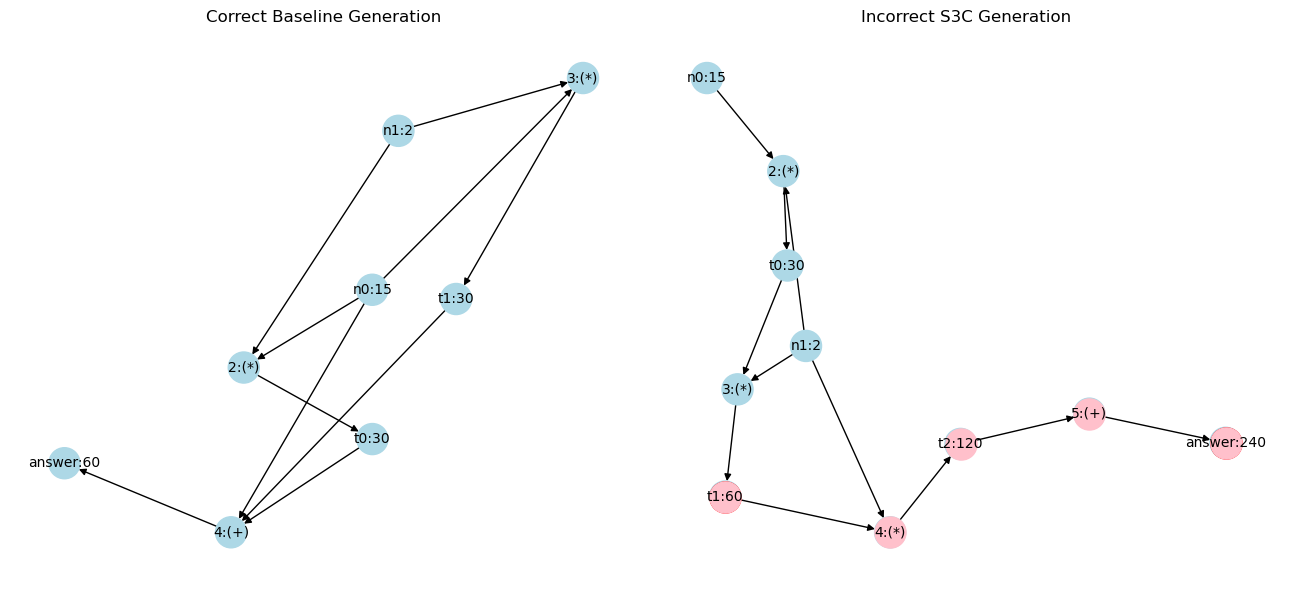

Unique nodes in Baseline Graph: {'t1', 'answer', '4:(+)'}
Unique nodes in S3C Graph: {'t2', '4:(*)', '5:(+)', 't1', 'answer'}
Unique edges in Baseline Graph: {('t1', '4:(+)'), ('4:(+)', 'answer'), ('n0', '3:(*)'), ('t0', '4:(+)'), ('n0', '4:(+)')}
Unique edges in S3C Graph: {('t2', '5:(+)'), ('5:(+)', 'answer'), ('t0', '3:(*)'), ('t1', '4:(*)'), ('n1', '4:(*)'), ('4:(*)', 't2')}
Basline Generated Answer: 75, S3C Generated Answer: 240, GT Answer 75.0
----------------------------------------------------------------


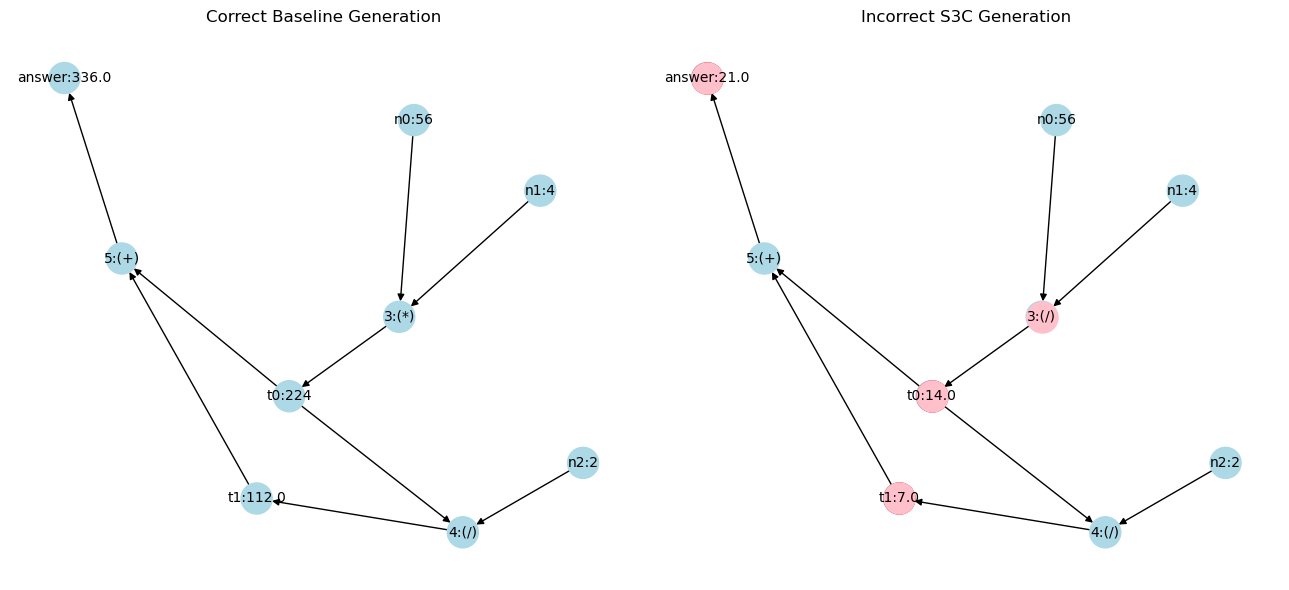

Unique nodes in Baseline Graph: {'t1', 't0', '3:(*)', 'answer'}
Unique nodes in S3C Graph: {'t1', 't0', 'answer', '3:(/)'}
Unique edges in Baseline Graph: {('n1', '3:(*)'), ('3:(*)', 't0'), ('n0', '3:(*)')}
Unique edges in S3C Graph: {('n1', '3:(/)'), ('n0', '3:(/)'), ('3:(/)', 't0')}
Basline Generated Answer: 336.0, S3C Generated Answer: 21.0, GT Answer 336.0
----------------------------------------------------------------


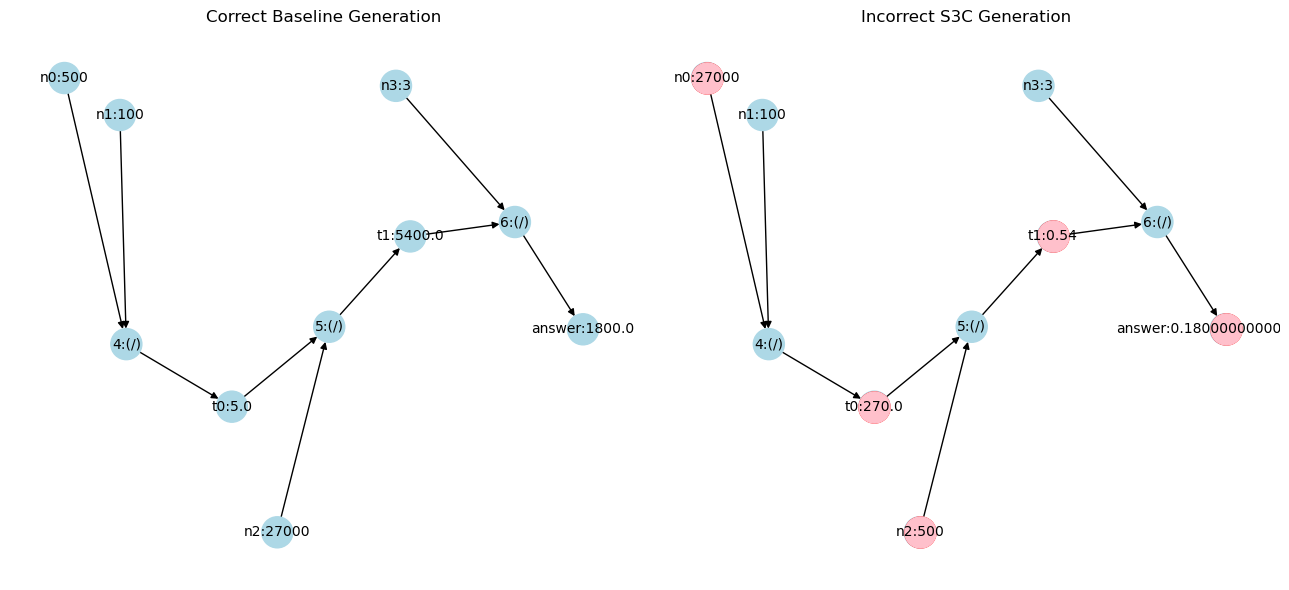

Unique nodes in Baseline Graph: {'n2', 't0', 'n0', 't1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't0', 'n0', 't1', 'answer'}
Unique edges in Baseline Graph: set()
Unique edges in S3C Graph: set()
Basline Generated Answer: 1800.0, S3C Generated Answer: 0.18000000000000002, GT Answer 1800.0
----------------------------------------------------------------


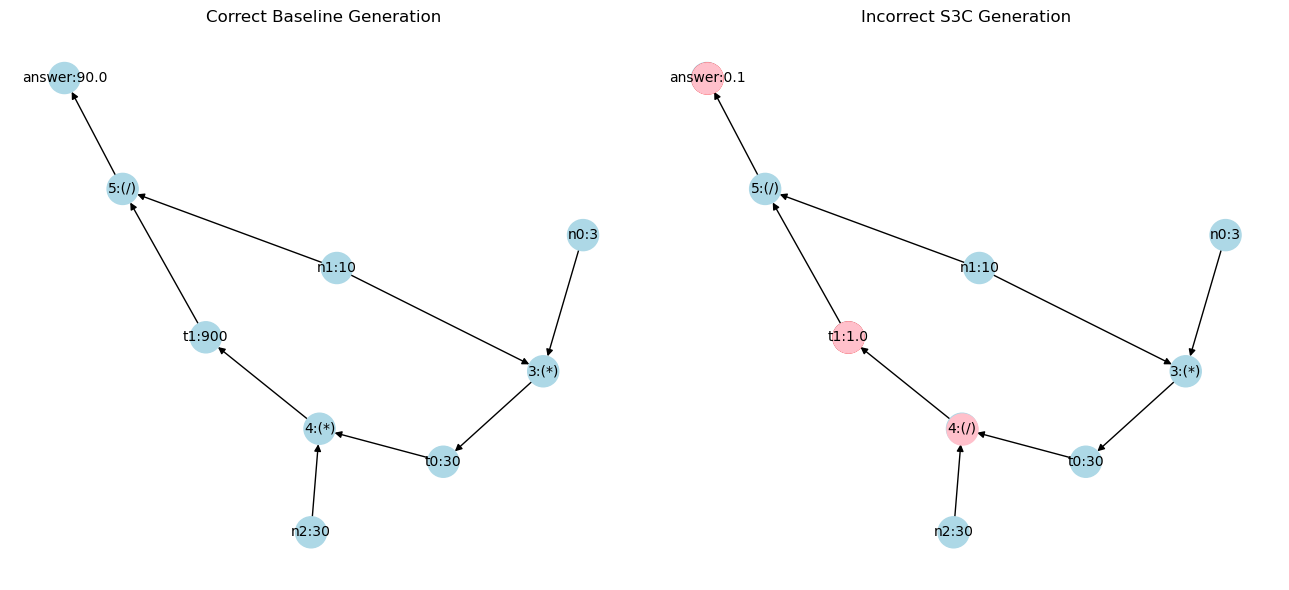

Unique nodes in Baseline Graph: {'4:(*)', 't1', 'answer'}
Unique nodes in S3C Graph: {'t1', '4:(/)', 'answer'}
Unique edges in Baseline Graph: {('n2', '4:(*)'), ('4:(*)', 't1'), ('t0', '4:(*)')}
Unique edges in S3C Graph: {('t0', '4:(/)'), ('n2', '4:(/)'), ('4:(/)', 't1')}
Basline Generated Answer: 90.0, S3C Generated Answer: 0.1, GT Answer 90.0
----------------------------------------------------------------


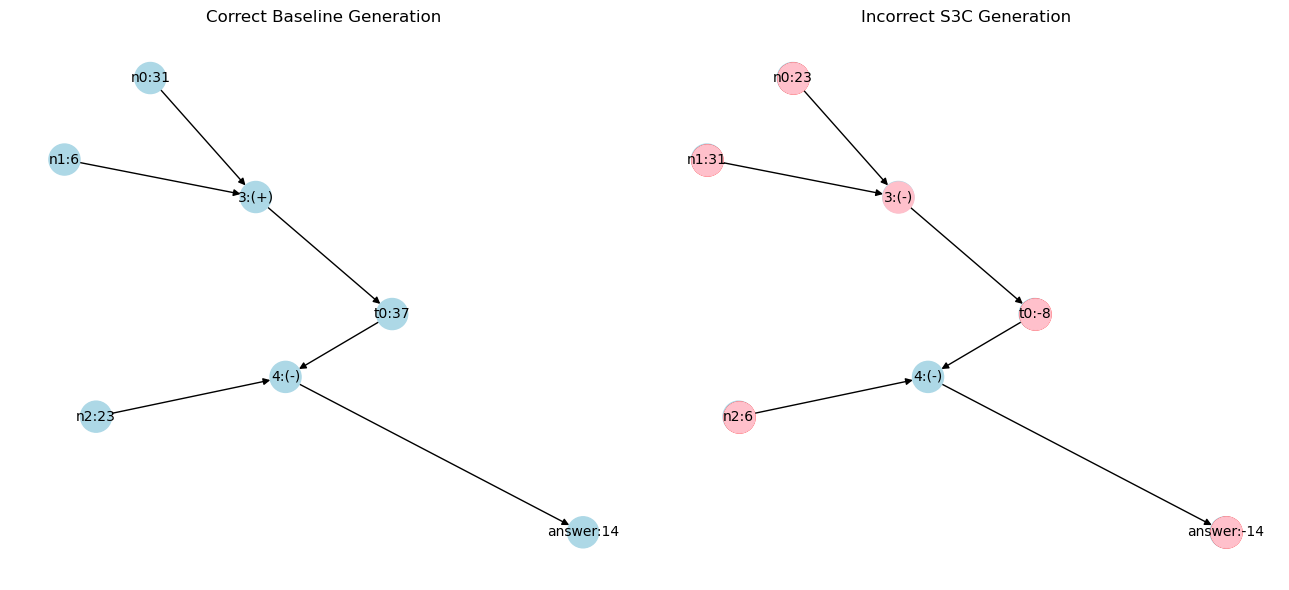

Unique nodes in Baseline Graph: {'n2', 't0', '3:(+)', 'n0', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't0', 'n0', 'n1', 'answer', '3:(-)'}
Unique edges in Baseline Graph: {('n1', '3:(+)'), ('n0', '3:(+)'), ('3:(+)', 't0')}
Unique edges in S3C Graph: {('n0', '3:(-)'), ('3:(-)', 't0'), ('n1', '3:(-)')}
Basline Generated Answer: 14, S3C Generated Answer: -14, GT Answer 14.0
----------------------------------------------------------------


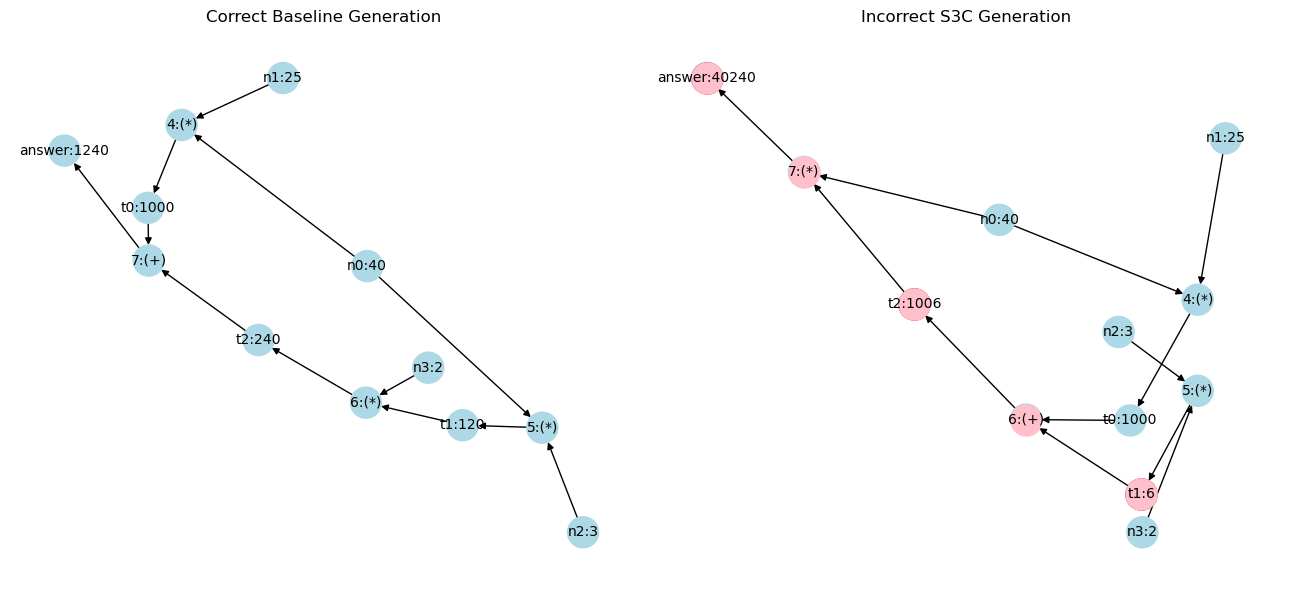

Unique nodes in Baseline Graph: {'t2', '7:(+)', '6:(*)', 't1', 'answer'}
Unique nodes in S3C Graph: {'7:(*)', 't2', '6:(+)', 't1', 'answer'}
Unique edges in Baseline Graph: {('6:(*)', 't2'), ('t2', '7:(+)'), ('t1', '6:(*)'), ('n0', '5:(*)'), ('7:(+)', 'answer'), ('n3', '6:(*)'), ('t0', '7:(+)')}
Unique edges in S3C Graph: {('t0', '6:(+)'), ('7:(*)', 'answer'), ('n3', '5:(*)'), ('n0', '7:(*)'), ('t2', '7:(*)'), ('t1', '6:(+)'), ('6:(+)', 't2')}
Basline Generated Answer: 1240, S3C Generated Answer: 40240, GT Answer 1240.0
----------------------------------------------------------------


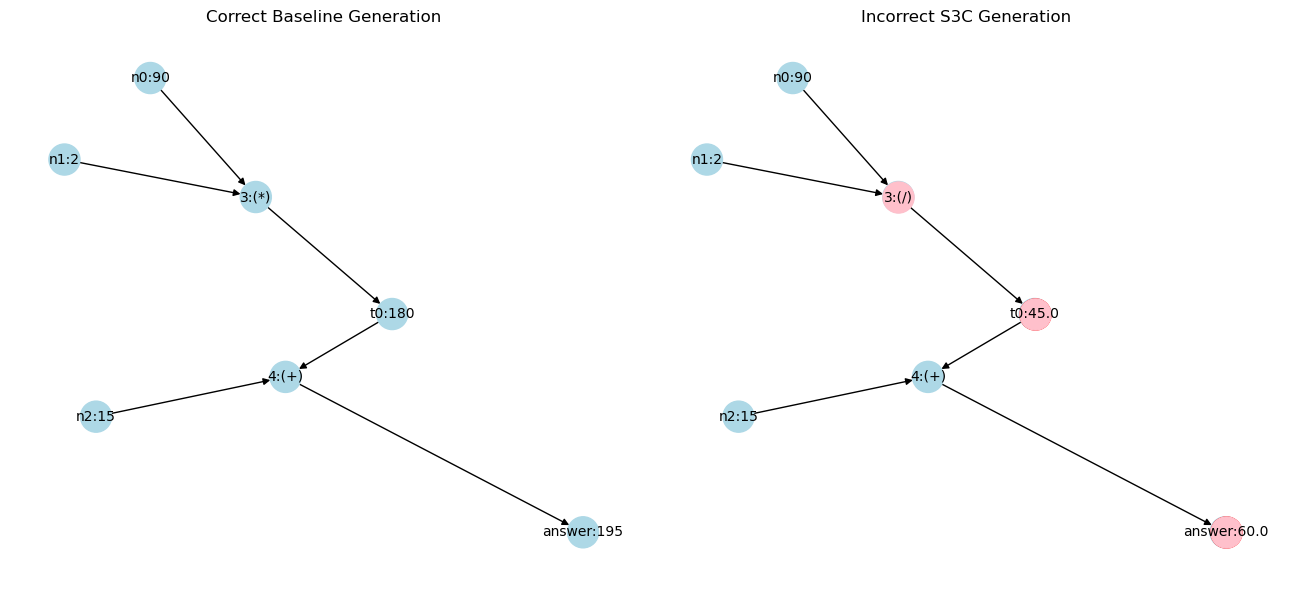

Unique nodes in Baseline Graph: {'t0', '3:(*)', 'answer'}
Unique nodes in S3C Graph: {'t0', 'answer', '3:(/)'}
Unique edges in Baseline Graph: {('n1', '3:(*)'), ('3:(*)', 't0'), ('n0', '3:(*)')}
Unique edges in S3C Graph: {('n1', '3:(/)'), ('n0', '3:(/)'), ('3:(/)', 't0')}
Basline Generated Answer: 195, S3C Generated Answer: 60.0, GT Answer 195.0
----------------------------------------------------------------


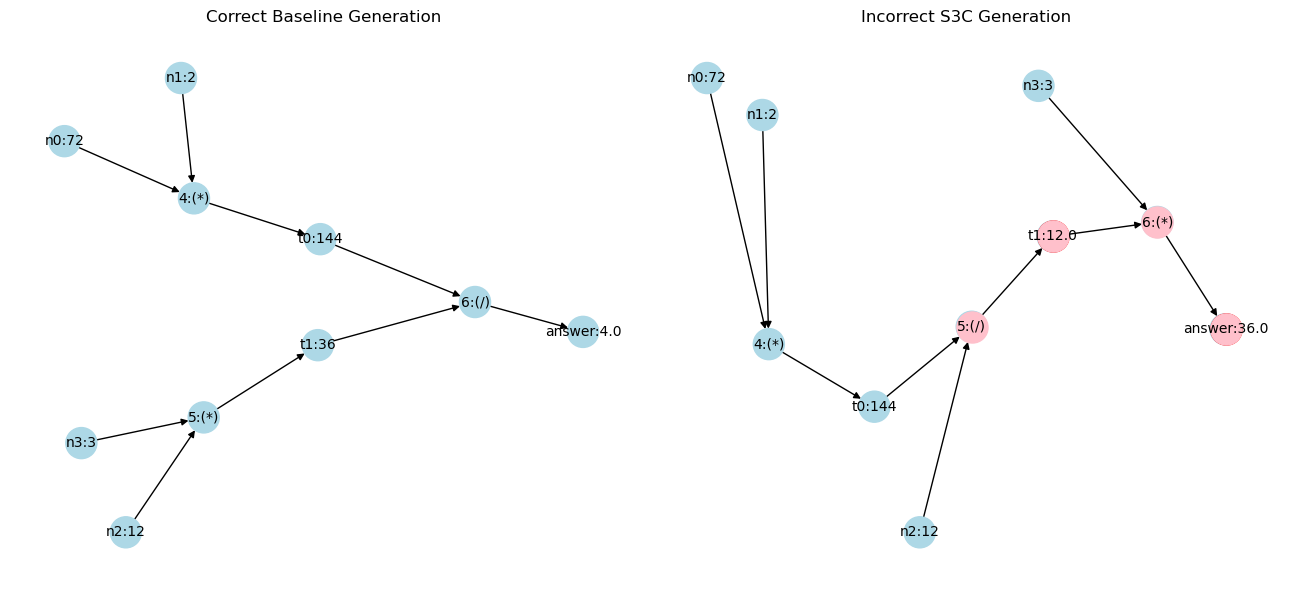

Unique nodes in Baseline Graph: {'t1', '5:(*)', 'answer', '6:(/)'}
Unique nodes in S3C Graph: {'answer', 't1', '6:(*)', '5:(/)'}
Unique edges in Baseline Graph: {('n2', '5:(*)'), ('n3', '5:(*)'), ('6:(/)', 'answer'), ('t1', '6:(/)'), ('5:(*)', 't1'), ('t0', '6:(/)')}
Unique edges in S3C Graph: {('5:(/)', 't1'), ('t1', '6:(*)'), ('n3', '6:(*)'), ('t0', '5:(/)'), ('n2', '5:(/)'), ('6:(*)', 'answer')}
Basline Generated Answer: 4.0, S3C Generated Answer: 36.0, GT Answer 4.0
----------------------------------------------------------------


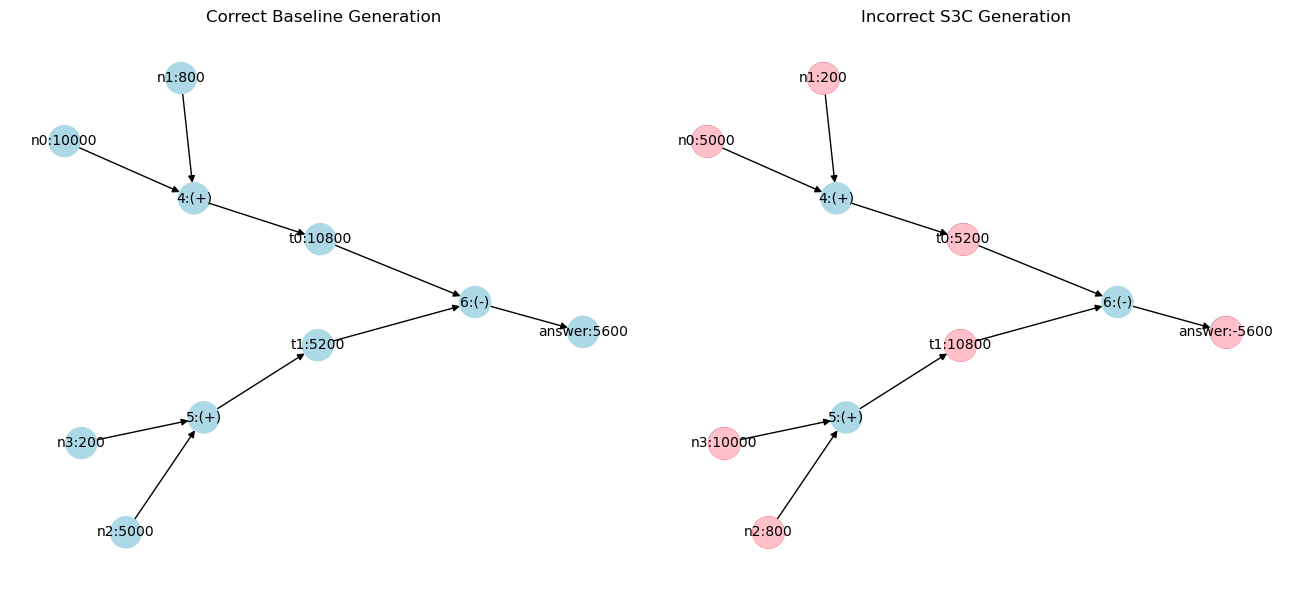

Unique nodes in Baseline Graph: {'n3', 'n2', 't0', 'n0', 't1', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n3', 'n2', 't0', 'n0', 't1', 'n1', 'answer'}
Unique edges in Baseline Graph: set()
Unique edges in S3C Graph: set()
Basline Generated Answer: 5600, S3C Generated Answer: -5600, GT Answer 5600.0
----------------------------------------------------------------


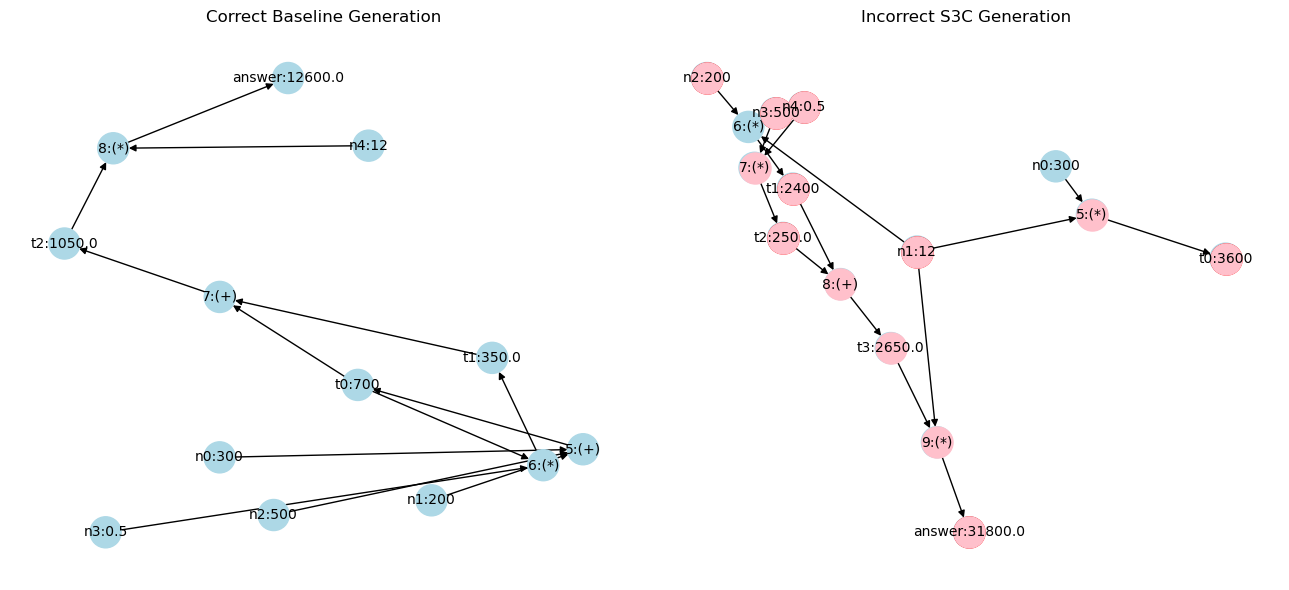

Unique nodes in Baseline Graph: {'n3', '8:(*)', 'n2', 't0', 't2', '7:(+)', 'n4', '5:(+)', 't1', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n3', 'n2', 't0', '7:(*)', '9:(*)', 't2', '8:(+)', '5:(*)', 't3', 'n4', 't1', 'n1', 'answer'}
Unique edges in Baseline Graph: {('t0', '6:(*)'), ('n1', '5:(+)'), ('8:(*)', 'answer'), ('t1', '7:(+)'), ('n3', '6:(*)'), ('n2', '5:(+)'), ('n4', '8:(*)'), ('n0', '5:(+)'), ('t2', '8:(*)'), ('5:(+)', 't0'), ('t0', '7:(+)'), ('7:(+)', 't2')}
Unique edges in S3C Graph: {('t2', '8:(+)'), ('t1', '8:(+)'), ('5:(*)', 't0'), ('n2', '6:(*)'), ('n0', '5:(*)'), ('t3', '9:(*)'), ('n1', '6:(*)'), ('9:(*)', 'answer'), ('7:(*)', 't2'), ('8:(+)', 't3'), ('n1', '9:(*)'), ('n4', '7:(*)'), ('n1', '5:(*)'), ('n3', '7:(*)')}
Basline Generated Answer: 18000.0, S3C Generated Answer: 31800.0, GT Answer 18000.0
----------------------------------------------------------------


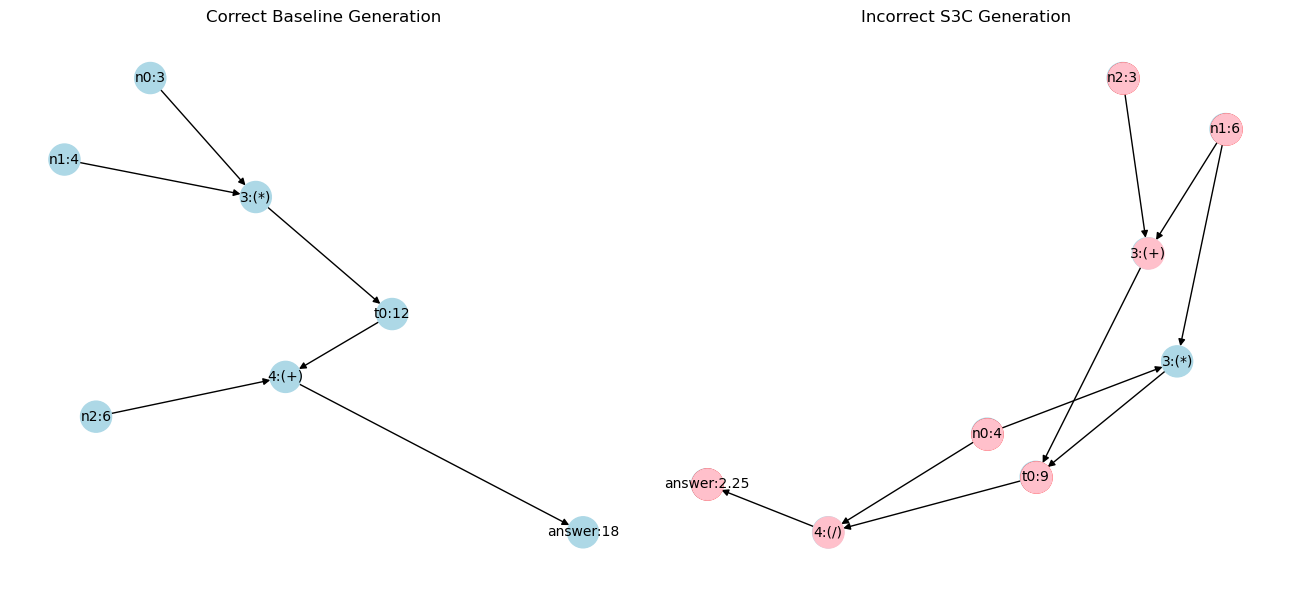

Unique nodes in Baseline Graph: {'n2', 't0', 'n0', '4:(+)', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't0', '3:(+)', '4:(/)', 'n0', 'n1', 'answer'}
Unique edges in Baseline Graph: {('n2', '4:(+)'), ('4:(+)', 'answer'), ('t0', '4:(+)')}
Unique edges in S3C Graph: {('3:(+)', 't0'), ('n2', '3:(+)'), ('4:(/)', 'answer'), ('n1', '3:(+)'), ('t0', '4:(/)'), ('n0', '4:(/)')}
Basline Generated Answer: 18, S3C Generated Answer: 6.75, GT Answer 18.0
----------------------------------------------------------------


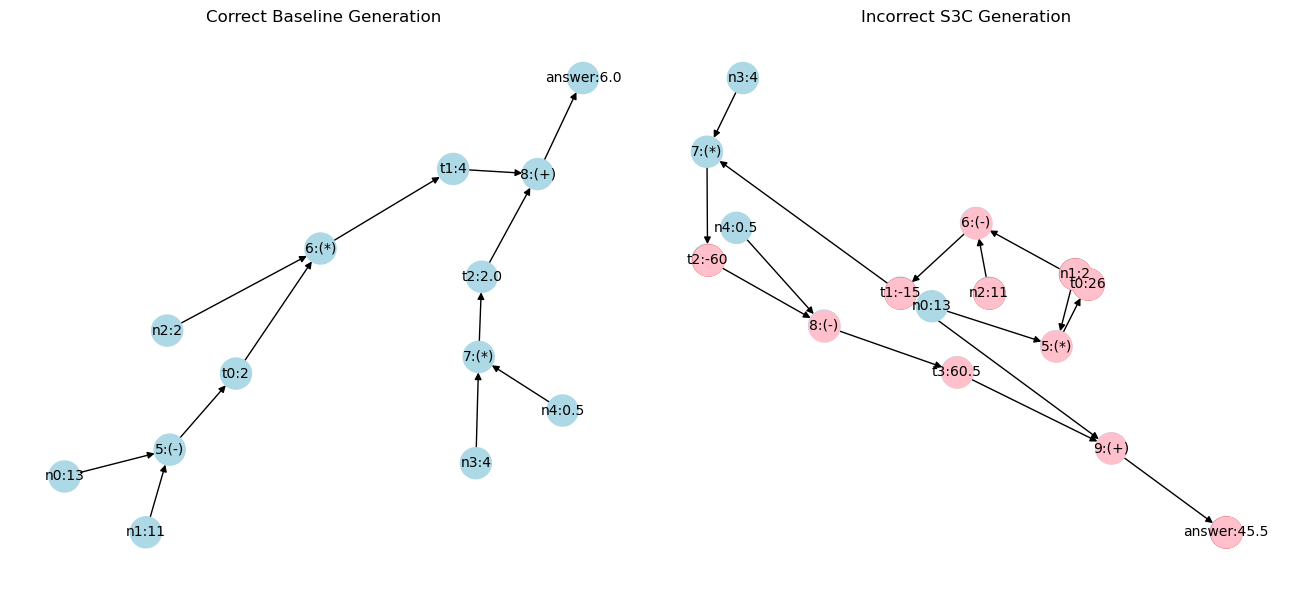

Unique nodes in Baseline Graph: {'n2', '5:(-)', 't0', 't2', '6:(*)', '8:(+)', 't1', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't0', '8:(-)', 't2', '6:(-)', '5:(*)', 't3', '9:(+)', 't1', 'n1', 'answer'}
Unique edges in Baseline Graph: {('5:(-)', 't0'), ('t0', '6:(*)'), ('6:(*)', 't1'), ('t2', '8:(+)'), ('8:(+)', 'answer'), ('t1', '8:(+)'), ('n0', '5:(-)'), ('n1', '5:(-)'), ('n4', '7:(*)'), ('n2', '6:(*)')}
Unique edges in S3C Graph: {('t3', '9:(+)'), ('n4', '8:(-)'), ('t2', '8:(-)'), ('5:(*)', 't0'), ('9:(+)', 'answer'), ('t0', '6:(-)'), ('6:(-)', 't1'), ('n0', '5:(*)'), ('n2', '6:(-)'), ('8:(-)', 't3'), ('t1', '7:(*)'), ('n1', '5:(*)'), ('t1', '9:(+)')}
Basline Generated Answer: 6.0, S3C Generated Answer: 45.5, GT Answer 6.0
----------------------------------------------------------------


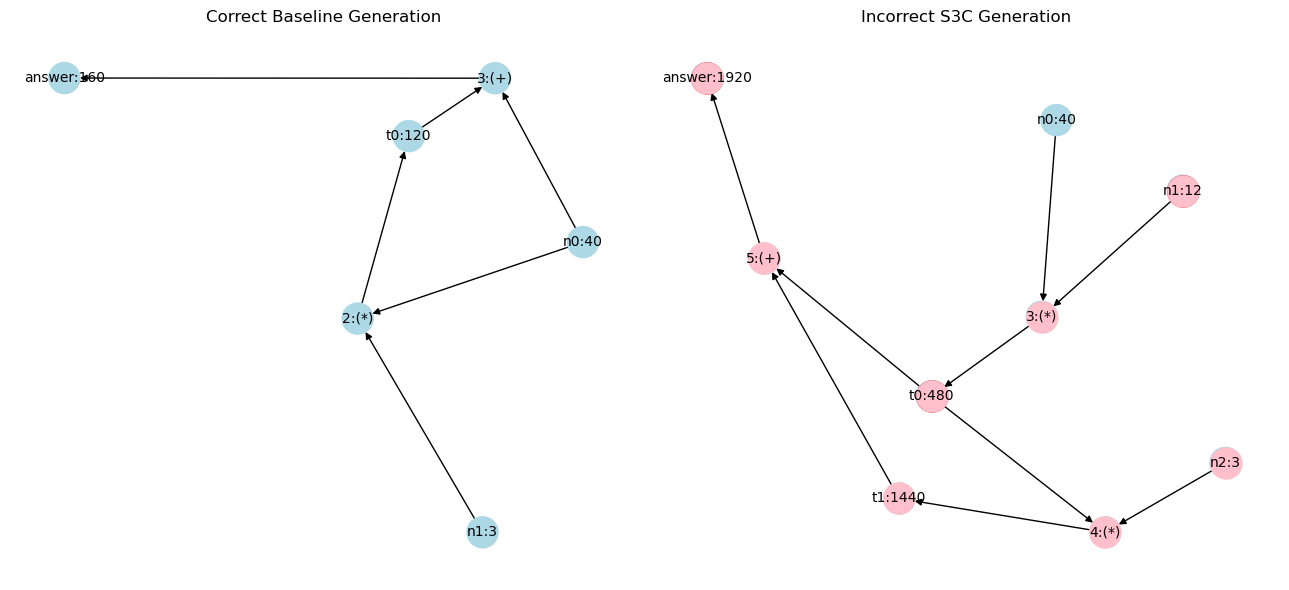

Unique nodes in Baseline Graph: {'t0', '3:(+)', 'n1', 'answer', '2:(*)'}
Unique nodes in S3C Graph: {'n2', 't0', '3:(*)', '4:(*)', '5:(+)', 't1', 'n1', 'answer'}
Unique edges in Baseline Graph: {('t0', '3:(+)'), ('3:(+)', 'answer'), ('n0', '3:(+)'), ('2:(*)', 't0'), ('n0', '2:(*)'), ('n1', '2:(*)')}
Unique edges in S3C Graph: {('5:(+)', 'answer'), ('t1', '5:(+)'), ('n0', '3:(*)'), ('t0', '5:(+)'), ('t0', '4:(*)'), ('n2', '4:(*)'), ('4:(*)', 't1'), ('n1', '3:(*)'), ('3:(*)', 't0')}
Basline Generated Answer: 160, S3C Generated Answer: 1920, GT Answer 160.0
----------------------------------------------------------------


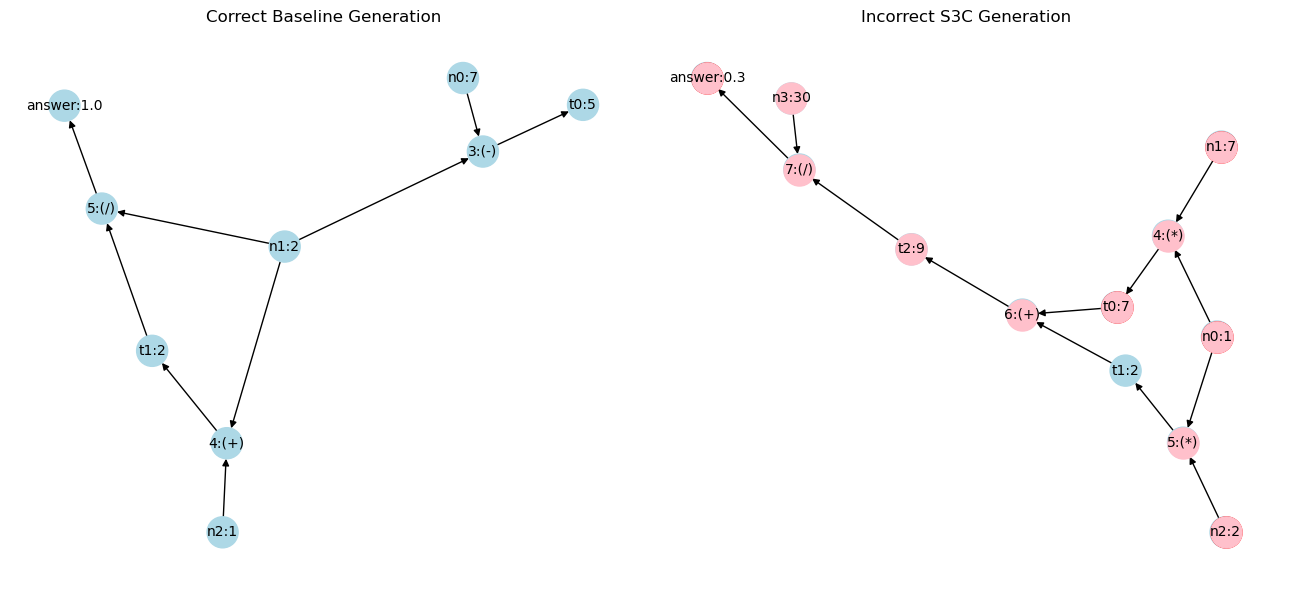

Unique nodes in Baseline Graph: {'n2', 't0', 'n0', '5:(/)', '4:(+)', 'n1', 'answer', '3:(-)'}
Unique nodes in S3C Graph: {'n3', 'n2', 't0', '7:(/)', 't2', 'n0', '4:(*)', '5:(*)', '6:(+)', 'n1', 'answer'}
Unique edges in Baseline Graph: {('5:(/)', 'answer'), ('n1', '4:(+)'), ('t1', '5:(/)'), ('n0', '3:(-)'), ('n1', '5:(/)'), ('n2', '4:(+)'), ('3:(-)', 't0'), ('4:(+)', 't1'), ('n1', '3:(-)')}
Unique edges in S3C Graph: {('n3', '7:(/)'), ('t0', '6:(+)'), ('n2', '5:(*)'), ('4:(*)', 't0'), ('6:(+)', 't2'), ('n1', '4:(*)'), ('n0', '5:(*)'), ('t1', '6:(+)'), ('t2', '7:(/)'), ('n0', '4:(*)'), ('7:(/)', 'answer'), ('5:(*)', 't1')}
Basline Generated Answer: 3.0, S3C Generated Answer: 0.3, GT Answer 3.0
----------------------------------------------------------------


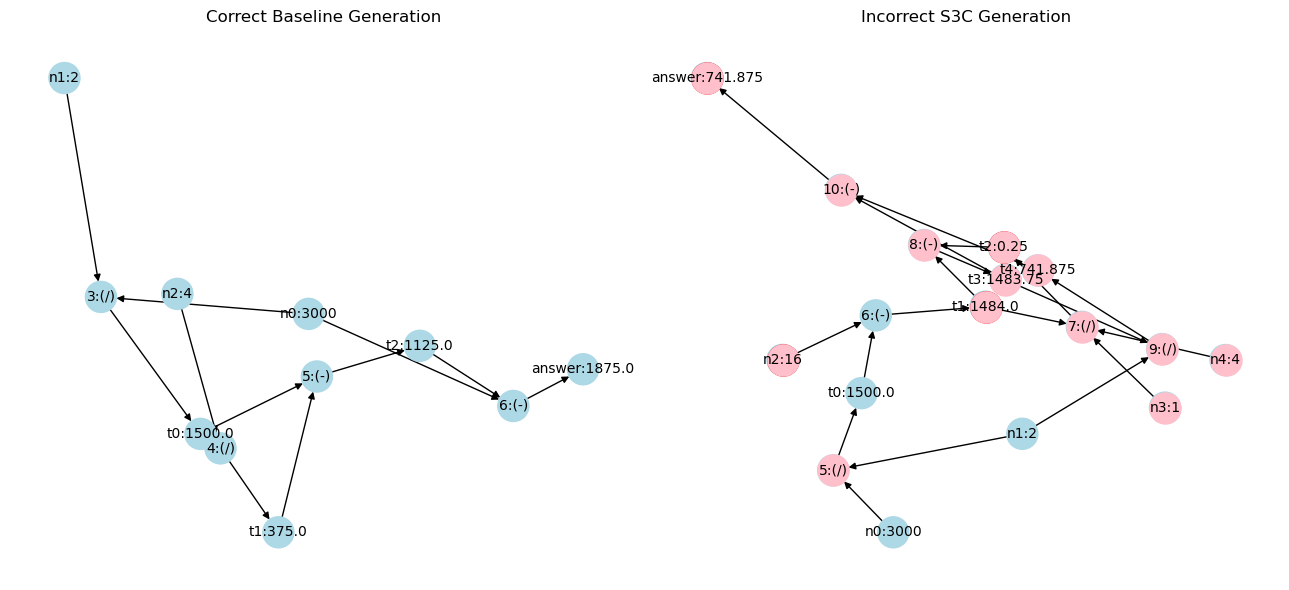

Unique nodes in Baseline Graph: {'n2', '5:(-)', 't2', '4:(/)', '3:(/)', 't1', 'answer'}
Unique nodes in S3C Graph: {'n3', 'n2', '8:(-)', '7:(/)', 't2', '9:(/)', '10:(-)', '5:(/)', 't4', 't3', 'n4', 't1', 'answer'}
Unique edges in Baseline Graph: {('3:(/)', 't0'), ('t0', '5:(-)'), ('n1', '3:(/)'), ('5:(-)', 't2'), ('6:(-)', 'answer'), ('n0', '6:(-)'), ('n2', '4:(/)'), ('4:(/)', 't1'), ('t0', '4:(/)'), ('t1', '5:(-)'), ('n0', '3:(/)'), ('t2', '6:(-)')}
Unique edges in S3C Graph: {('n1', '9:(/)'), ('t0', '6:(-)'), ('n1', '5:(/)'), ('8:(-)', 't3'), ('5:(/)', 't0'), ('t4', '10:(-)'), ('10:(-)', 'answer'), ('t3', '10:(-)'), ('t3', '9:(/)'), ('n4', '7:(/)'), ('9:(/)', 't4'), ('t2', '8:(-)'), ('t1', '7:(/)'), ('n3', '7:(/)'), ('7:(/)', 't2'), ('6:(-)', 't1'), ('t1', '8:(-)'), ('n2', '6:(-)'), ('n0', '5:(/)')}
Basline Generated Answer: 1875.0, S3C Generated Answer: -2226.0, GT Answer 1875.0
----------------------------------------------------------------


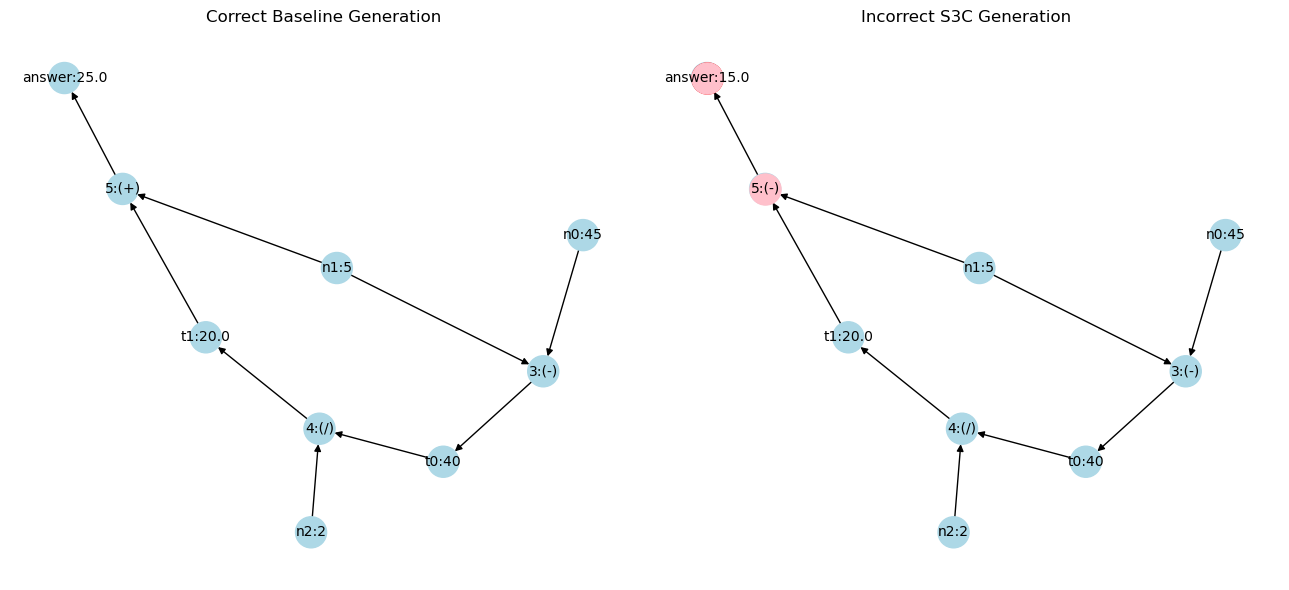

Unique nodes in Baseline Graph: {'5:(+)', 'answer'}
Unique nodes in S3C Graph: {'5:(-)', 'answer'}
Unique edges in Baseline Graph: {('t1', '5:(+)'), ('5:(+)', 'answer'), ('n1', '5:(+)')}
Unique edges in S3C Graph: {('5:(-)', 'answer'), ('t1', '5:(-)'), ('n1', '5:(-)')}
Basline Generated Answer: 25.0, S3C Generated Answer: 15.0, GT Answer 25.0
----------------------------------------------------------------


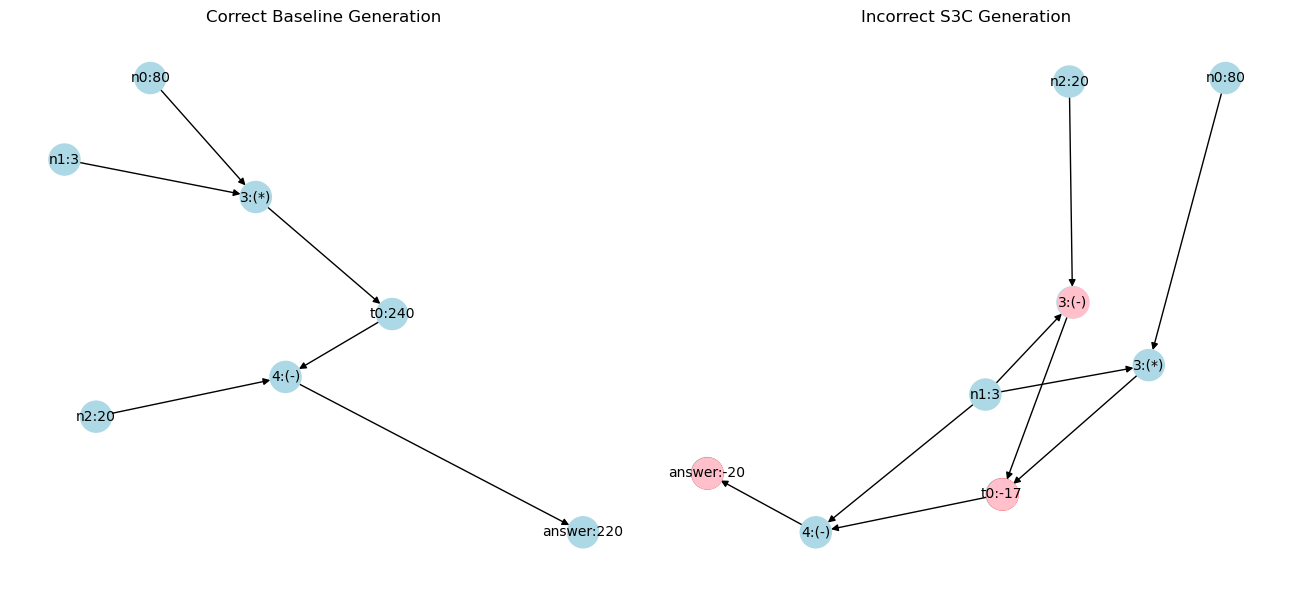

Unique nodes in Baseline Graph: {'t0', 'answer'}
Unique nodes in S3C Graph: {'t0', 'answer', '3:(-)'}
Unique edges in Baseline Graph: {('n2', '4:(-)')}
Unique edges in S3C Graph: {('n1', '4:(-)'), ('3:(-)', 't0'), ('n1', '3:(-)'), ('n2', '3:(-)')}
Basline Generated Answer: 220, S3C Generated Answer: 217, GT Answer 220.0
----------------------------------------------------------------


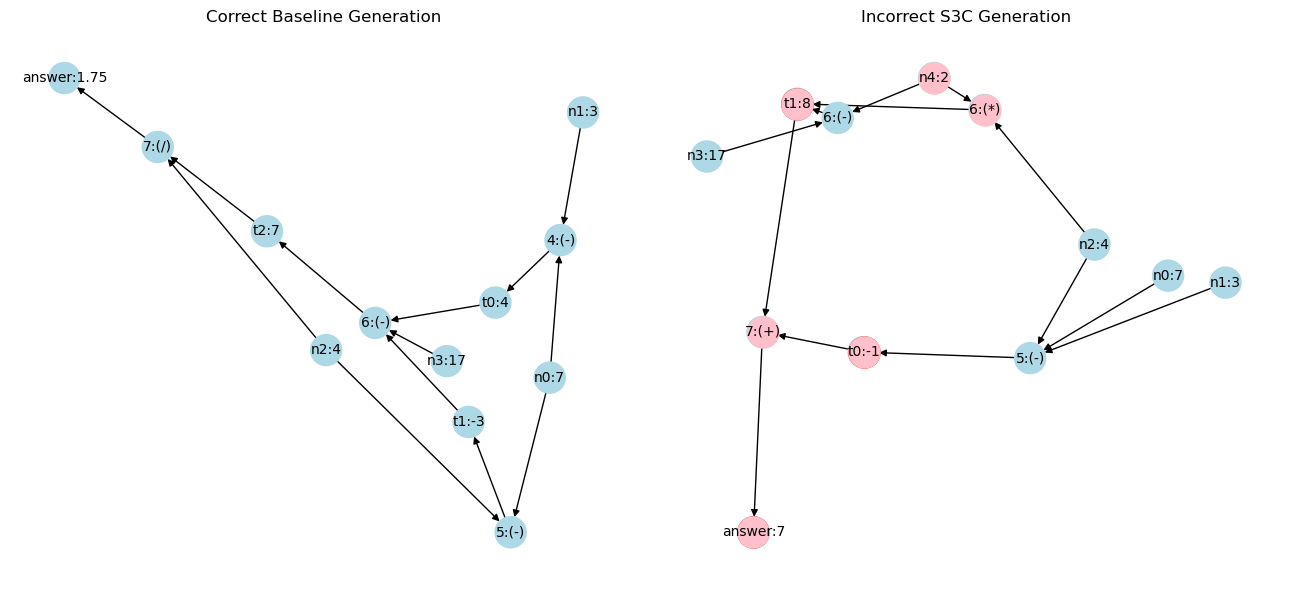

Unique nodes in Baseline Graph: {'t0', '7:(/)', 't2', '4:(-)', 't1', 'answer'}
Unique nodes in S3C Graph: {'t0', '7:(+)', '6:(*)', 'n4', 't1', 'answer'}
Unique edges in Baseline Graph: {('n1', '4:(-)'), ('t1', '6:(-)'), ('n2', '7:(/)'), ('n0', '4:(-)'), ('5:(-)', 't1'), ('t0', '6:(-)'), ('4:(-)', 't0'), ('6:(-)', 't2'), ('t2', '7:(/)'), ('7:(/)', 'answer')}
Unique edges in S3C Graph: {('5:(-)', 't0'), ('6:(*)', 't1'), ('n2', '6:(*)'), ('6:(-)', 't1'), ('n4', '6:(*)'), ('t1', '7:(+)'), ('7:(+)', 'answer'), ('n1', '5:(-)'), ('t0', '7:(+)'), ('n4', '6:(-)')}
Basline Generated Answer: 4.0, S3C Generated Answer: 9, GT Answer 4.0
----------------------------------------------------------------


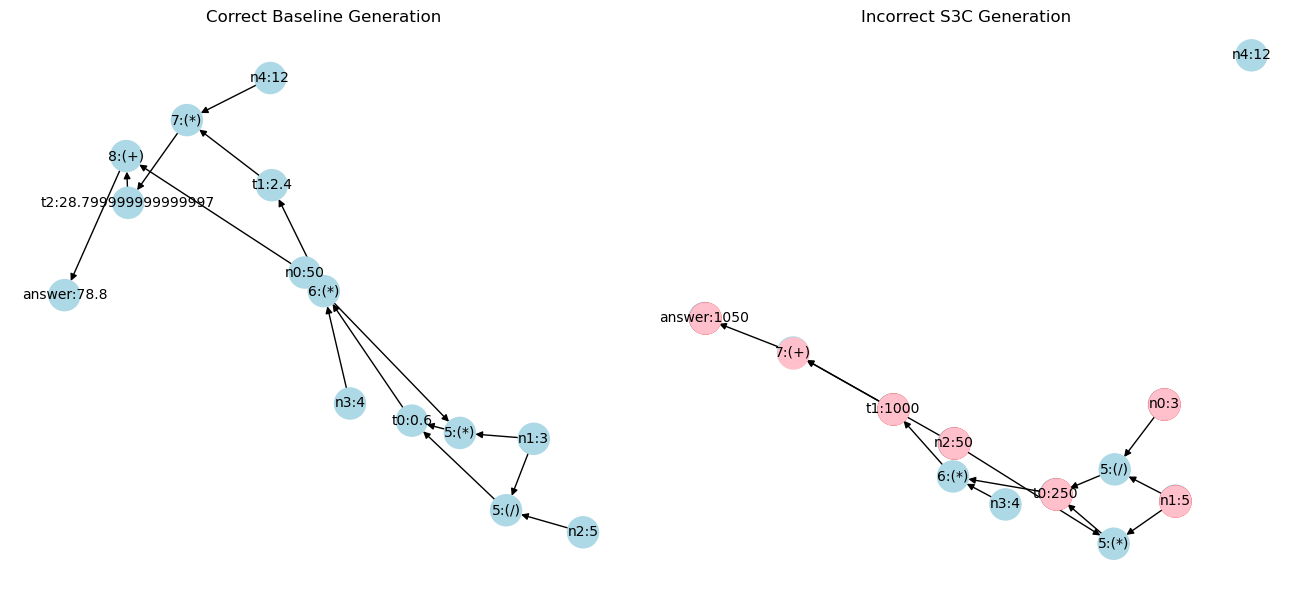

Unique nodes in Baseline Graph: {'n2', 't0', '7:(*)', 't2', 'n0', '8:(+)', 't1', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't0', '7:(+)', 'n0', 't1', 'n1', 'answer'}
Unique edges in Baseline Graph: {('t2', '8:(+)'), ('8:(+)', 'answer'), ('t1', '7:(*)'), ('n0', '5:(*)'), ('n0', '8:(+)'), ('7:(*)', 't2'), ('n2', '5:(/)'), ('n4', '7:(*)')}
Unique edges in S3C Graph: {('n2', '5:(*)'), ('7:(+)', 'answer'), ('t1', '7:(+)'), ('n0', '5:(/)'), ('n2', '7:(+)')}
Basline Generated Answer: 1490.0, S3C Generated Answer: 170.0, GT Answer 1490.0
----------------------------------------------------------------


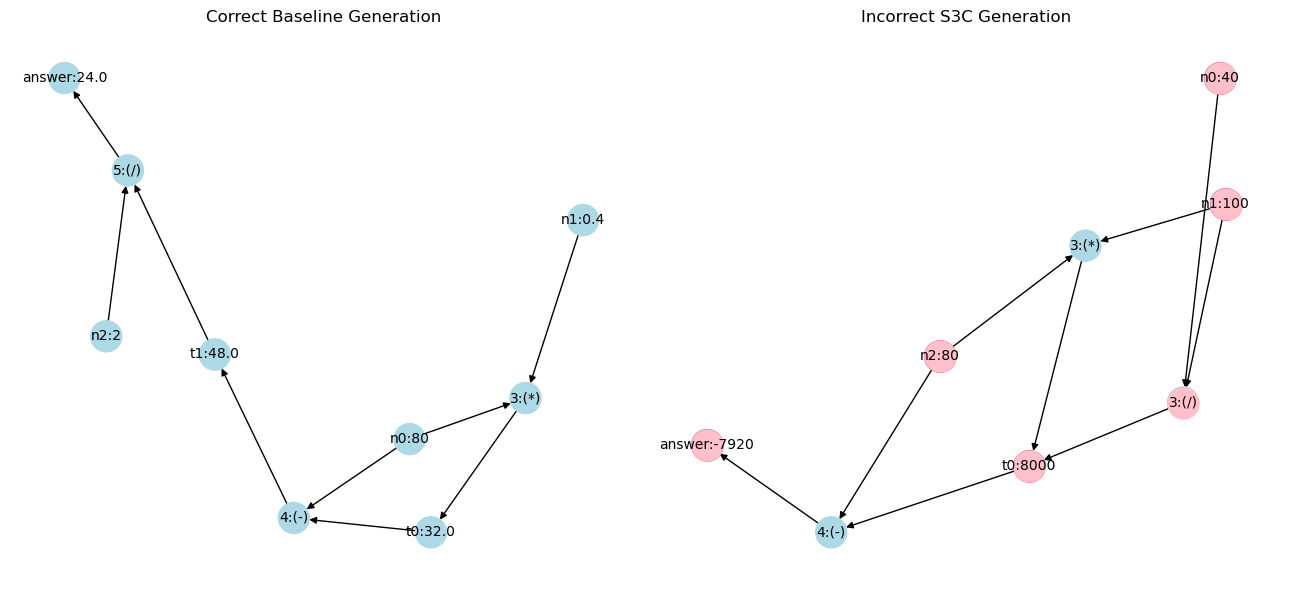

Unique nodes in Baseline Graph: {'n2', 't0', 'n0', '5:(/)', 't1', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't0', 'n0', '3:(/)', 'n1', 'answer'}
Unique edges in Baseline Graph: {('5:(/)', 'answer'), ('n0', '4:(-)'), ('n0', '3:(*)'), ('t1', '5:(/)'), ('n2', '5:(/)'), ('4:(-)', 't1')}
Unique edges in S3C Graph: {('3:(/)', 't0'), ('n2', '3:(*)'), ('n1', '3:(/)'), ('n2', '4:(-)'), ('4:(-)', 'answer'), ('n0', '3:(/)')}
Basline Generated Answer: 24.0, S3C Generated Answer: 48.0, GT Answer 24.0
----------------------------------------------------------------


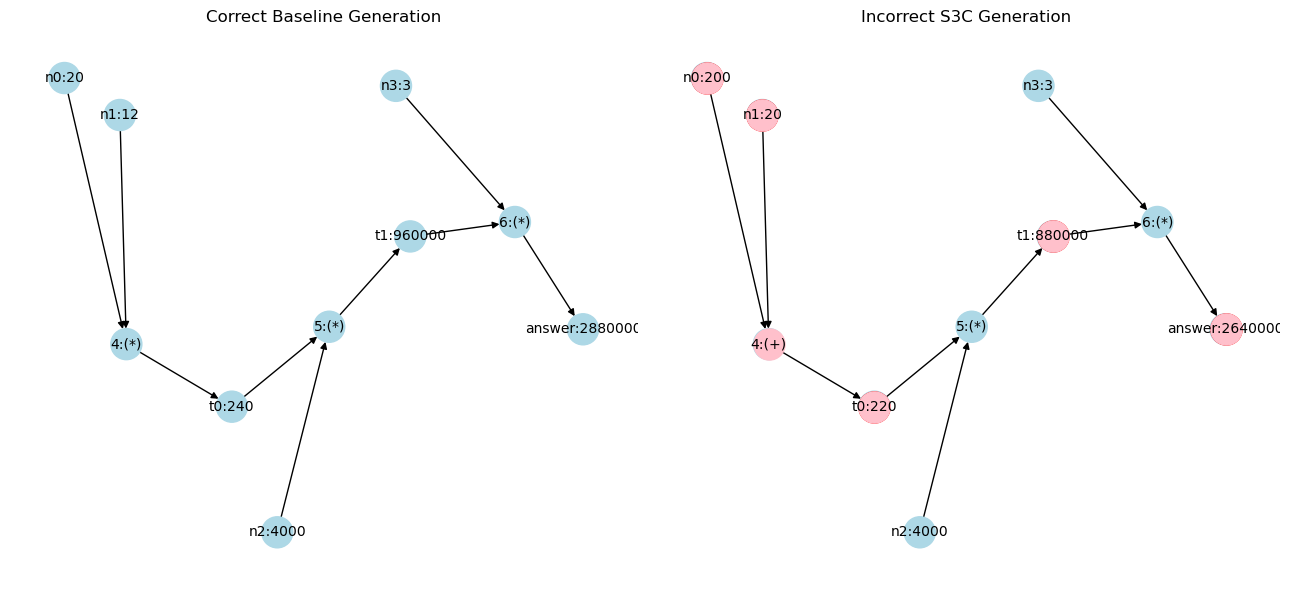

Unique nodes in Baseline Graph: {'t0', 'n0', '4:(*)', 't1', 'n1', 'answer'}
Unique nodes in S3C Graph: {'t0', 'n0', '4:(+)', 't1', 'n1', 'answer'}
Unique edges in Baseline Graph: {('4:(*)', 't0'), ('n0', '4:(*)'), ('n1', '4:(*)')}
Unique edges in S3C Graph: {('4:(+)', 't0'), ('n0', '4:(+)'), ('n1', '4:(+)')}
Basline Generated Answer: 2880000, S3C Generated Answer: 2640000, GT Answer 2880000.0
----------------------------------------------------------------


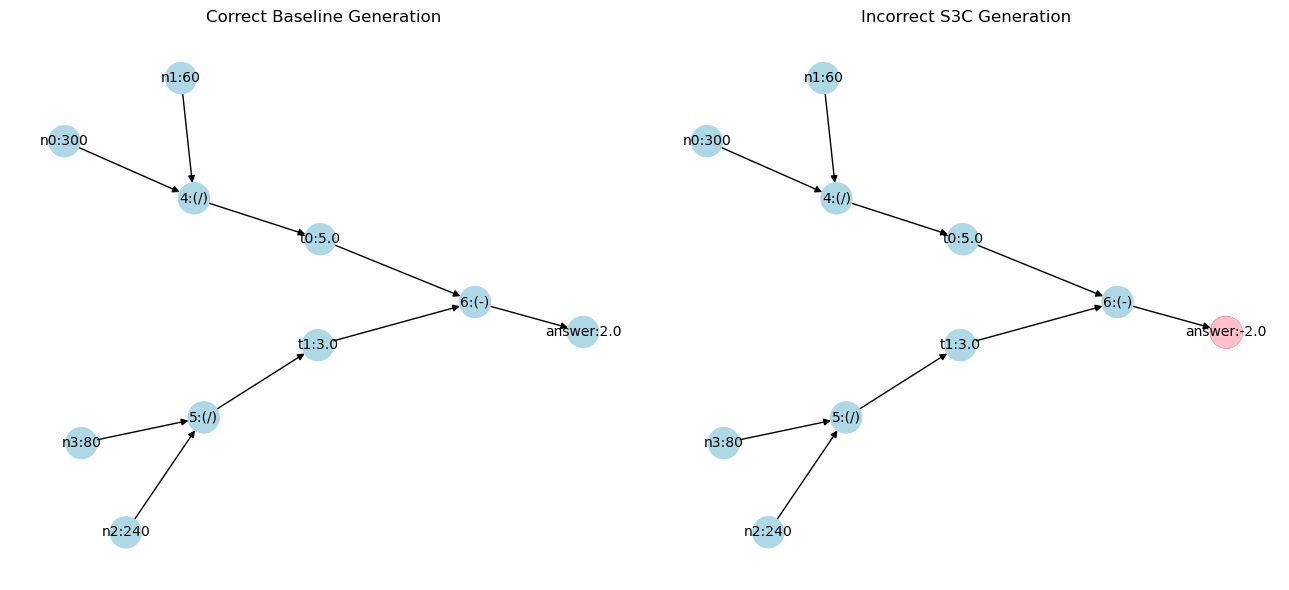

Unique nodes in Baseline Graph: {'answer'}
Unique nodes in S3C Graph: {'answer'}
Unique edges in Baseline Graph: set()
Unique edges in S3C Graph: set()
Basline Generated Answer: 2.0, S3C Generated Answer: -2.0, GT Answer 2.0
----------------------------------------------------------------


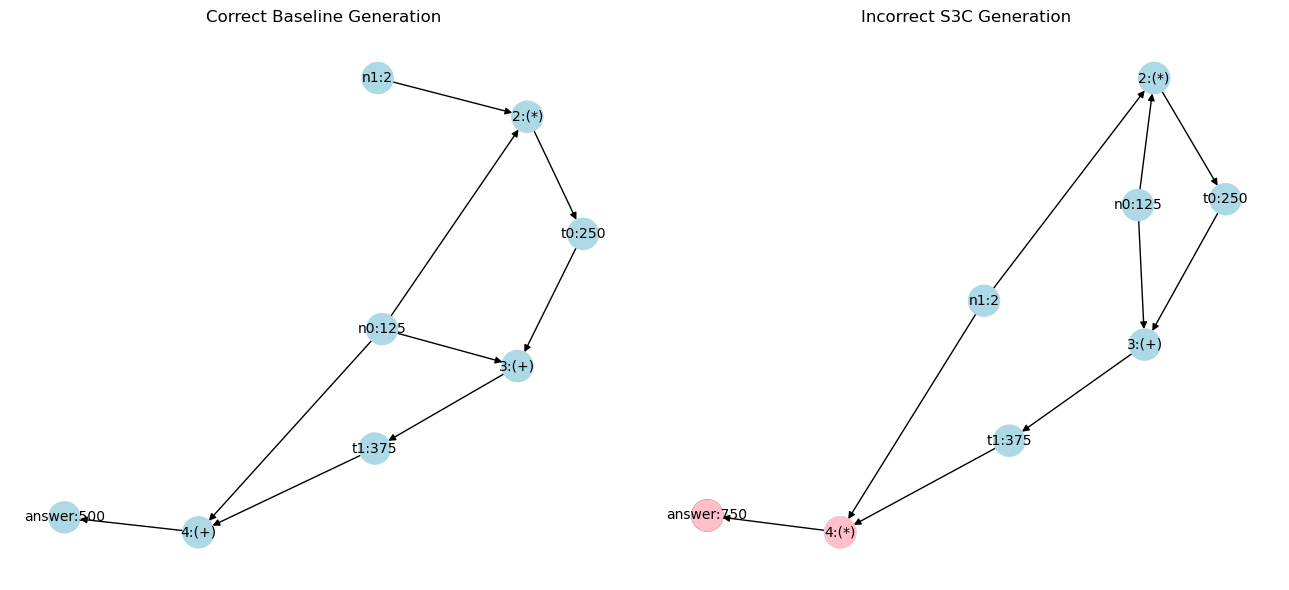

Unique nodes in Baseline Graph: {'answer', '4:(+)'}
Unique nodes in S3C Graph: {'4:(*)', 'answer'}
Unique edges in Baseline Graph: {('4:(+)', 'answer'), ('n0', '4:(+)'), ('t1', '4:(+)')}
Unique edges in S3C Graph: {('4:(*)', 'answer'), ('t1', '4:(*)'), ('n1', '4:(*)')}
Basline Generated Answer: 500, S3C Generated Answer: 1000, GT Answer 500.0
----------------------------------------------------------------


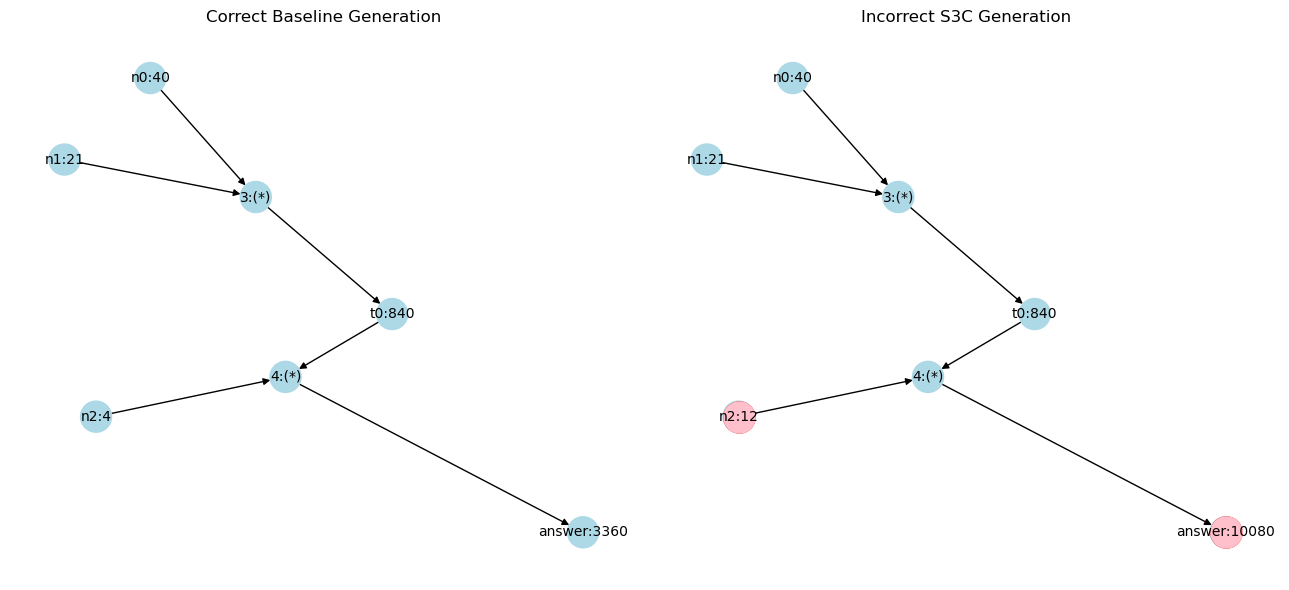

Unique nodes in Baseline Graph: {'n2', 'answer'}
Unique nodes in S3C Graph: {'n2', 'answer'}
Unique edges in Baseline Graph: set()
Unique edges in S3C Graph: set()
Basline Generated Answer: 3360, S3C Generated Answer: 10080, GT Answer 3360.0
----------------------------------------------------------------


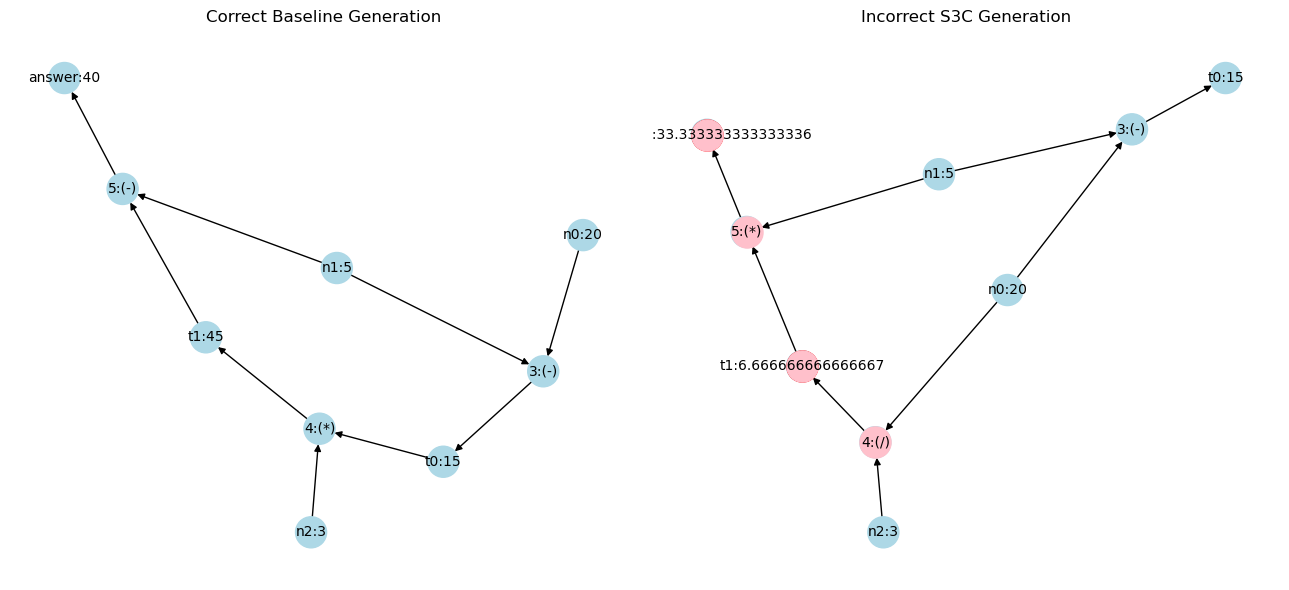

Unique nodes in Baseline Graph: {'4:(*)', 't1', '5:(-)', 'answer'}
Unique nodes in S3C Graph: {'5:(*)', 't1', '4:(/)', 'answer'}
Unique edges in Baseline Graph: {('5:(-)', 'answer'), ('t0', '4:(*)'), ('n1', '5:(-)'), ('n2', '4:(*)'), ('t1', '5:(-)'), ('4:(*)', 't1')}
Unique edges in S3C Graph: {('5:(*)', 'answer'), ('n2', '4:(/)'), ('4:(/)', 't1'), ('t1', '5:(*)'), ('n0', '4:(/)'), ('n1', '5:(*)')}
Basline Generated Answer: 40, S3C Generated Answer: 33.333333333333336, GT Answer 40.0
----------------------------------------------------------------


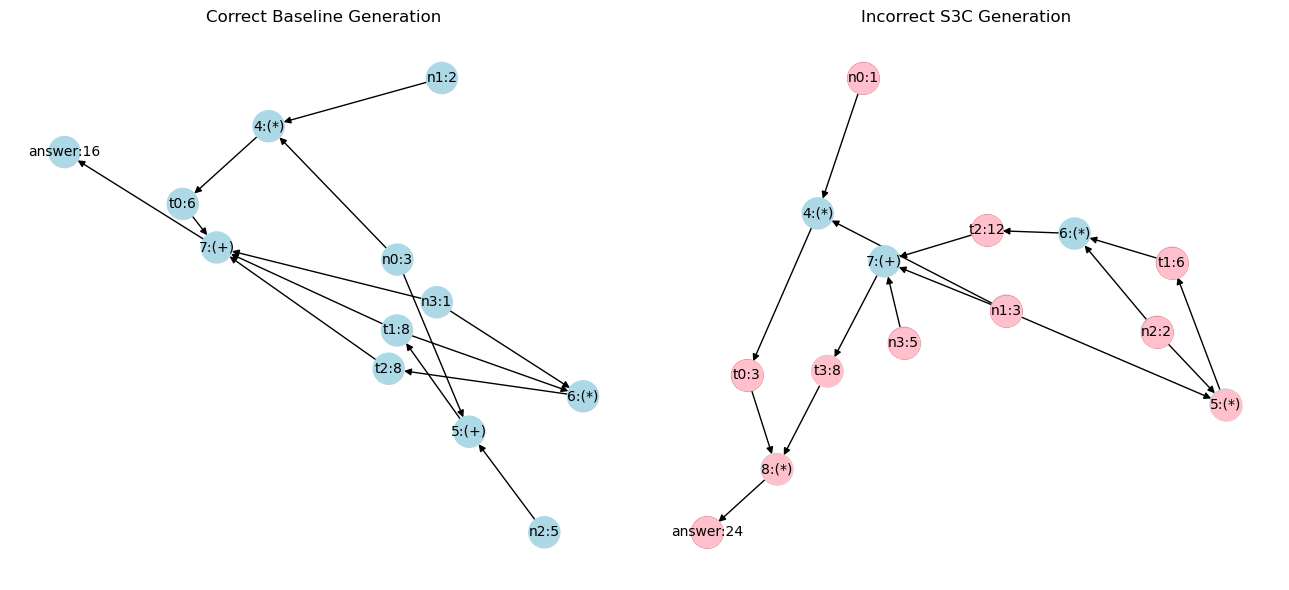

Unique nodes in Baseline Graph: {'n3', 'n2', 't0', 't2', 'n0', '5:(+)', 't1', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n3', '8:(*)', 'n2', 't0', 't2', 'n0', '5:(*)', 't3', 't1', 'n1', 'answer'}
Unique edges in Baseline Graph: {('5:(+)', 't1'), ('t1', '7:(+)'), ('7:(+)', 'answer'), ('n3', '6:(*)'), ('n2', '5:(+)'), ('n0', '5:(+)'), ('t0', '7:(+)')}
Unique edges in S3C Graph: {('5:(*)', 't1'), ('t0', '8:(*)'), ('n2', '5:(*)'), ('7:(+)', 't3'), ('8:(*)', 'answer'), ('n1', '7:(+)'), ('n2', '6:(*)'), ('t3', '8:(*)'), ('n1', '5:(*)')}
Basline Generated Answer: 29, S3C Generated Answer: 60, GT Answer 29.0
----------------------------------------------------------------


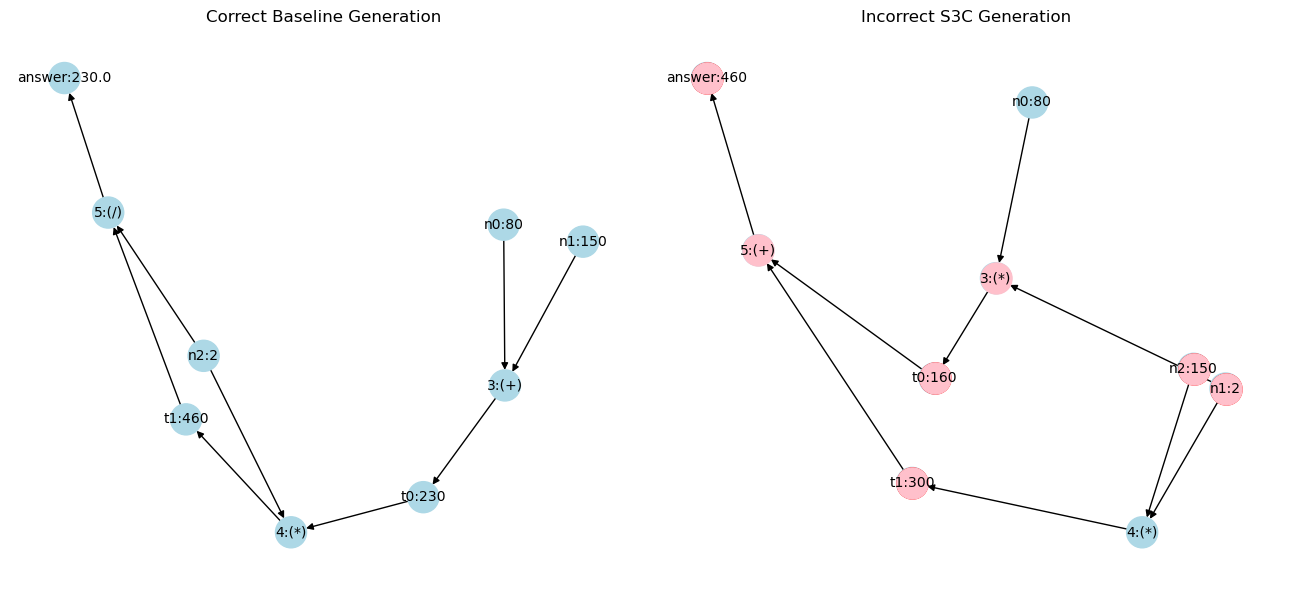

Unique nodes in Baseline Graph: {'n2', 't0', '3:(+)', '5:(/)', 't1', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't0', '3:(*)', '5:(+)', 't1', 'n1', 'answer'}
Unique edges in Baseline Graph: {('5:(/)', 'answer'), ('3:(+)', 't0'), ('n0', '3:(+)'), ('t1', '5:(/)'), ('t0', '4:(*)'), ('n1', '3:(+)'), ('n2', '5:(/)')}
Unique edges in S3C Graph: {('5:(+)', 'answer'), ('t1', '5:(+)'), ('n0', '3:(*)'), ('n1', '4:(*)'), ('t0', '5:(+)'), ('n1', '3:(*)'), ('3:(*)', 't0')}
Basline Generated Answer: 230.0, S3C Generated Answer: 460, GT Answer 230.0
----------------------------------------------------------------


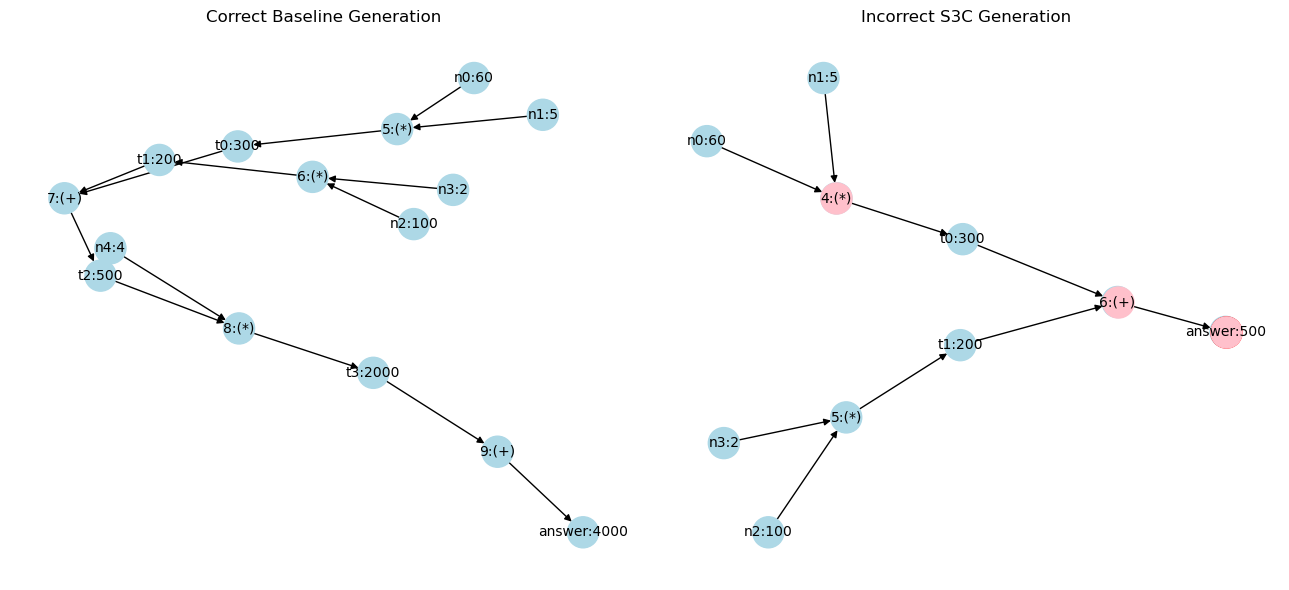

Unique nodes in Baseline Graph: {'8:(*)', 't2', '7:(+)', '9:(+)', '6:(*)', 't3', 'n4', 'answer'}
Unique nodes in S3C Graph: {'6:(+)', '4:(*)', 'answer'}
Unique edges in Baseline Graph: {('8:(*)', 't3'), ('6:(*)', 't1'), ('t3', '9:(+)'), ('5:(*)', 't0'), ('9:(+)', 'answer'), ('n2', '6:(*)'), ('n0', '5:(*)'), ('t1', '7:(+)'), ('n3', '6:(*)'), ('n4', '8:(*)'), ('t2', '8:(*)'), ('t0', '7:(+)'), ('7:(+)', 't2'), ('n1', '5:(*)')}
Unique edges in S3C Graph: {('t0', '6:(+)'), ('5:(*)', 't1'), ('n2', '5:(*)'), ('4:(*)', 't0'), ('6:(+)', 'answer'), ('n1', '4:(*)'), ('t1', '6:(+)'), ('n0', '4:(*)'), ('n3', '5:(*)')}
Basline Generated Answer: 4000, S3C Generated Answer: 500, GT Answer 4000.0
----------------------------------------------------------------


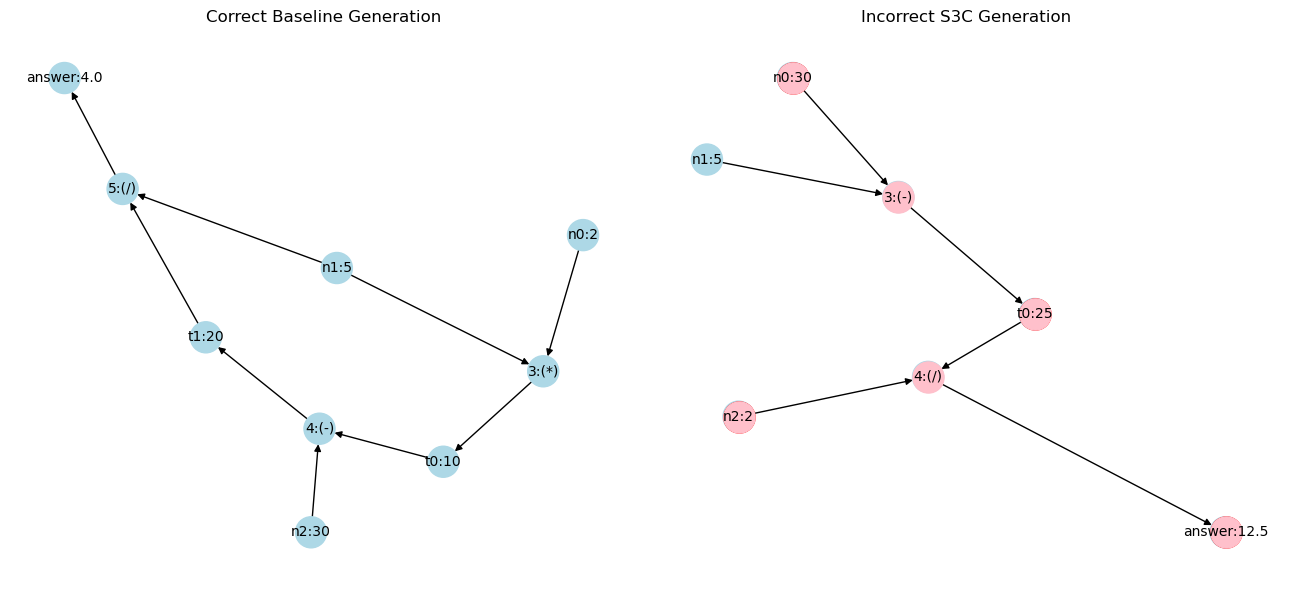

Unique nodes in Baseline Graph: {'n2', 't0', '3:(*)', 'n0', '5:(/)', '4:(-)', 't1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't0', '4:(/)', 'n0', 'answer', '3:(-)'}
Unique edges in Baseline Graph: {('5:(/)', 'answer'), ('t0', '4:(-)'), ('n2', '4:(-)'), ('n0', '3:(*)'), ('t1', '5:(/)'), ('n1', '5:(/)'), ('n1', '3:(*)'), ('3:(*)', 't0'), ('4:(-)', 't1')}
Unique edges in S3C Graph: {('n0', '3:(-)'), ('3:(-)', 't0'), ('4:(/)', 'answer'), ('n2', '4:(/)'), ('t0', '4:(/)'), ('n1', '3:(-)')}
Basline Generated Answer: 4.0, S3C Generated Answer: 12.5, GT Answer 4.0
----------------------------------------------------------------


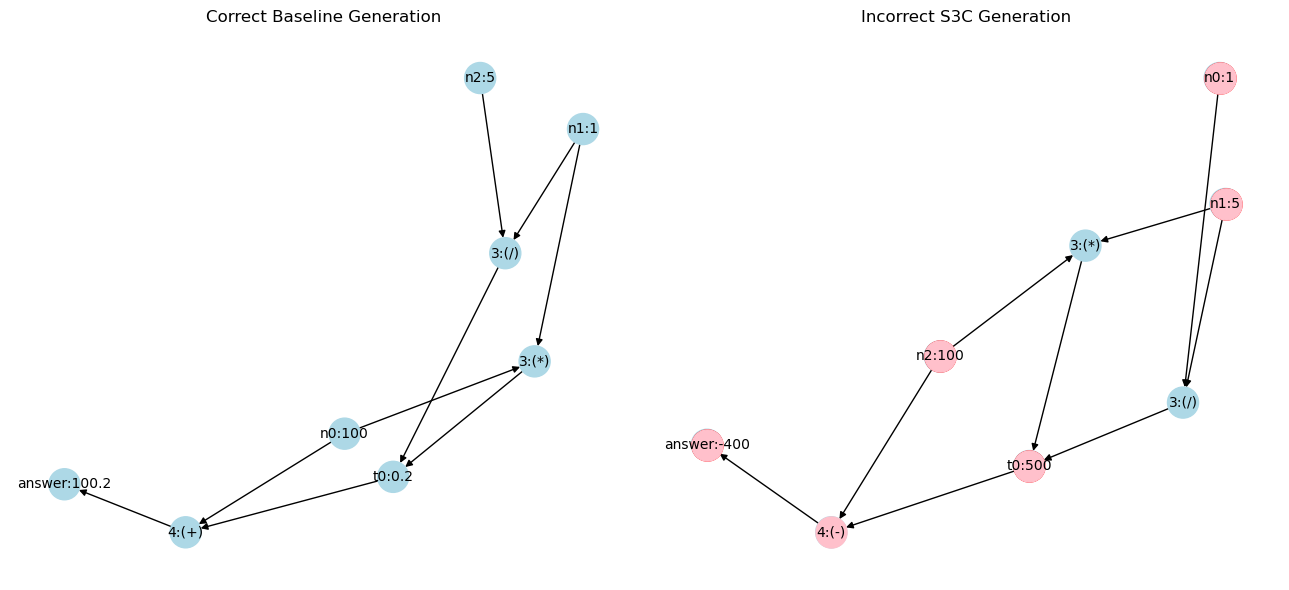

Unique nodes in Baseline Graph: {'n2', 't0', 'n0', '4:(+)', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't0', 'n0', '4:(-)', 'n1', 'answer'}
Unique edges in Baseline Graph: {('4:(+)', 'answer'), ('n0', '3:(*)'), ('t0', '4:(+)'), ('n2', '3:(/)'), ('n0', '4:(+)')}
Unique edges in S3C Graph: {('n2', '3:(*)'), ('t0', '4:(-)'), ('n2', '4:(-)'), ('4:(-)', 'answer'), ('n0', '3:(/)')}
Basline Generated Answer: 120.0, S3C Generated Answer: 80.0, GT Answer 120.0
----------------------------------------------------------------


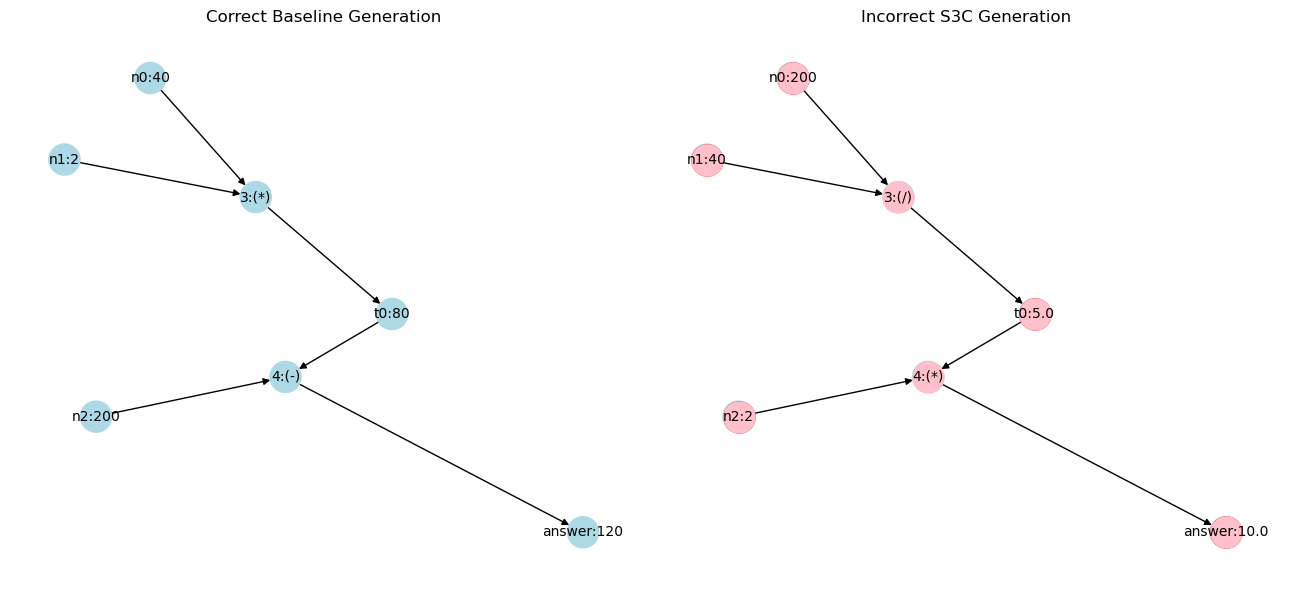

Unique nodes in Baseline Graph: {'n2', 't0', '3:(*)', 'n0', '4:(-)', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't0', 'n0', '4:(*)', '3:(/)', 'n1', 'answer'}
Unique edges in Baseline Graph: {('t0', '4:(-)'), ('n2', '4:(-)'), ('n0', '3:(*)'), ('4:(-)', 'answer'), ('n1', '3:(*)'), ('3:(*)', 't0')}
Unique edges in S3C Graph: {('3:(/)', 't0'), ('n1', '3:(/)'), ('4:(*)', 'answer'), ('t0', '4:(*)'), ('n2', '4:(*)'), ('n0', '3:(/)')}
Basline Generated Answer: 120, S3C Generated Answer: 10.0, GT Answer 120.0
----------------------------------------------------------------


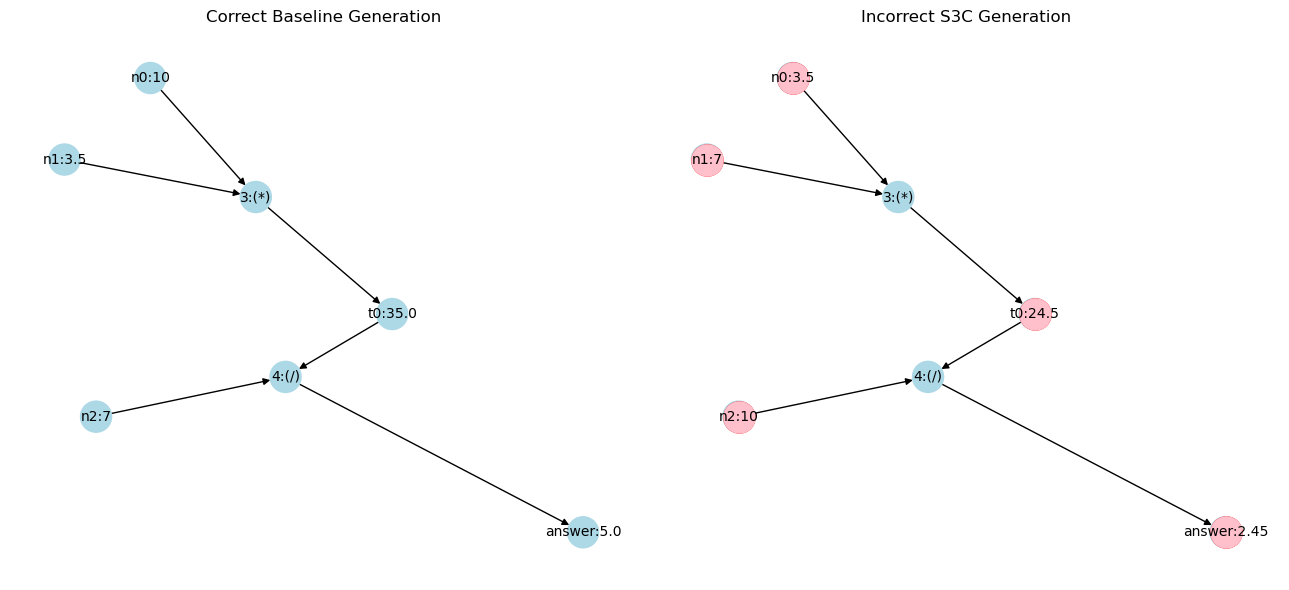

Unique nodes in Baseline Graph: {'n2', 't0', 'n0', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't0', 'n0', 'n1', 'answer'}
Unique edges in Baseline Graph: set()
Unique edges in S3C Graph: set()
Basline Generated Answer: 5.0, S3C Generated Answer: 2.45, GT Answer 5.0
----------------------------------------------------------------


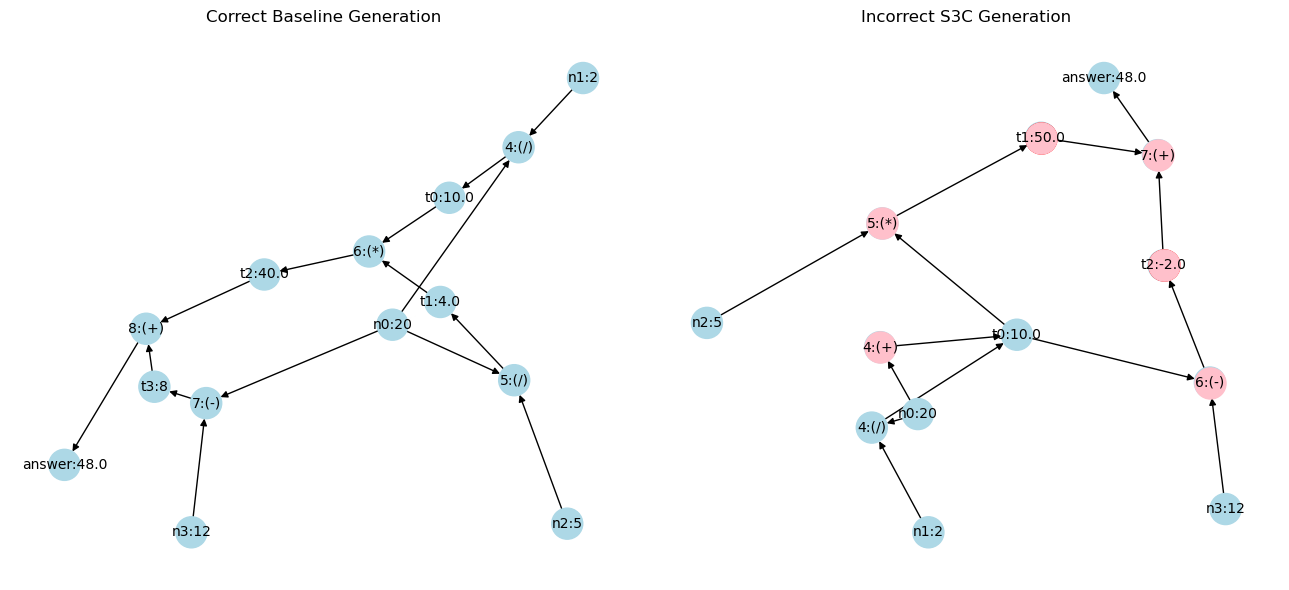

Unique nodes in Baseline Graph: {'t2', '5:(/)', '7:(-)', '6:(*)', 't3', '8:(+)', 't1'}
Unique nodes in S3C Graph: {'t2', '7:(+)', '6:(-)', '5:(*)', '4:(+)', 't1'}
Unique edges in Baseline Graph: {('t2', '8:(+)'), ('t0', '6:(*)'), ('n3', '7:(-)'), ('8:(+)', 'answer'), ('6:(*)', 't2'), ('5:(/)', 't1'), ('7:(-)', 't3'), ('t3', '8:(+)'), ('t1', '6:(*)'), ('n0', '7:(-)'), ('n2', '5:(/)'), ('n0', '5:(/)')}
Unique edges in S3C Graph: {('t0', '5:(*)'), ('n2', '5:(*)'), ('4:(+)', 't0'), ('n3', '6:(-)'), ('t2', '7:(+)'), ('t0', '6:(-)'), ('t1', '7:(+)'), ('7:(+)', 'answer'), ('6:(-)', 't2'), ('n0', '4:(+)'), ('5:(*)', 't1')}
Basline Generated Answer: 48.0, S3C Generated Answer: 168.0, GT Answer 48.0
----------------------------------------------------------------


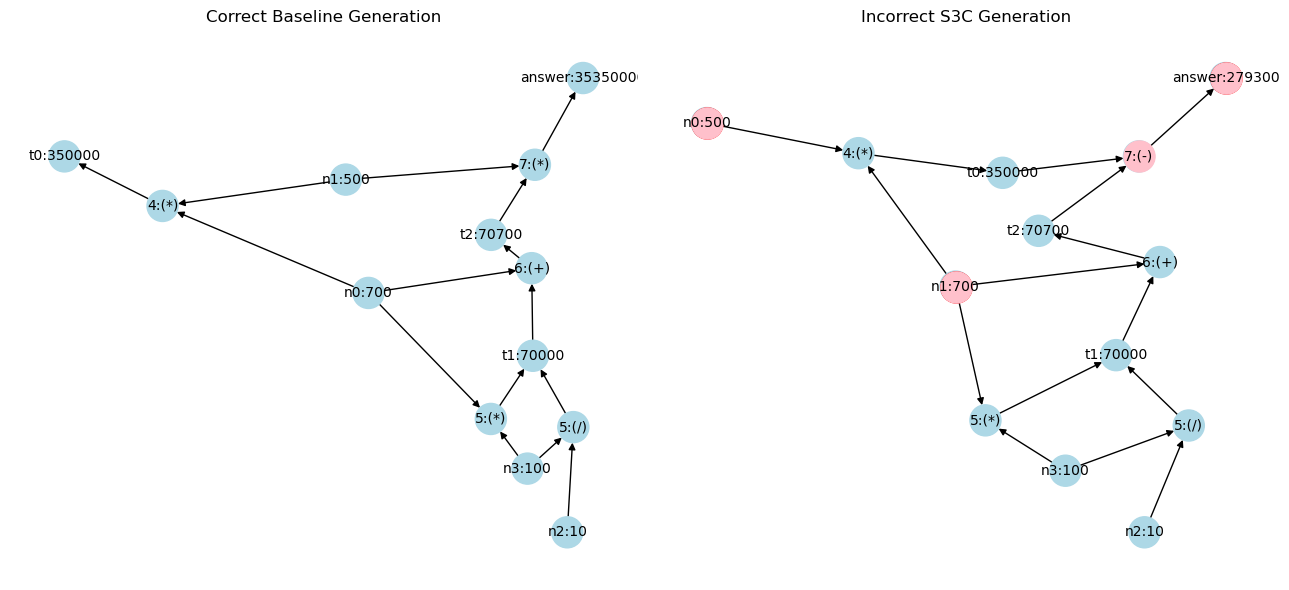

Unique nodes in Baseline Graph: {'n1', 'answer', 'n0', '7:(*)'}
Unique nodes in S3C Graph: {'7:(-)', 'n1', 'answer', 'n0'}
Unique edges in Baseline Graph: {('7:(*)', 'answer'), ('n0', '6:(+)'), ('n0', '5:(*)'), ('t2', '7:(*)'), ('n1', '7:(*)')}
Unique edges in S3C Graph: {('t0', '7:(-)'), ('7:(-)', 'answer'), ('n1', '6:(+)'), ('t2', '7:(-)'), ('n1', '5:(*)')}
Basline Generated Answer: 385000.0, S3C Generated Answer: 349230.0, GT Answer 385000.0
----------------------------------------------------------------


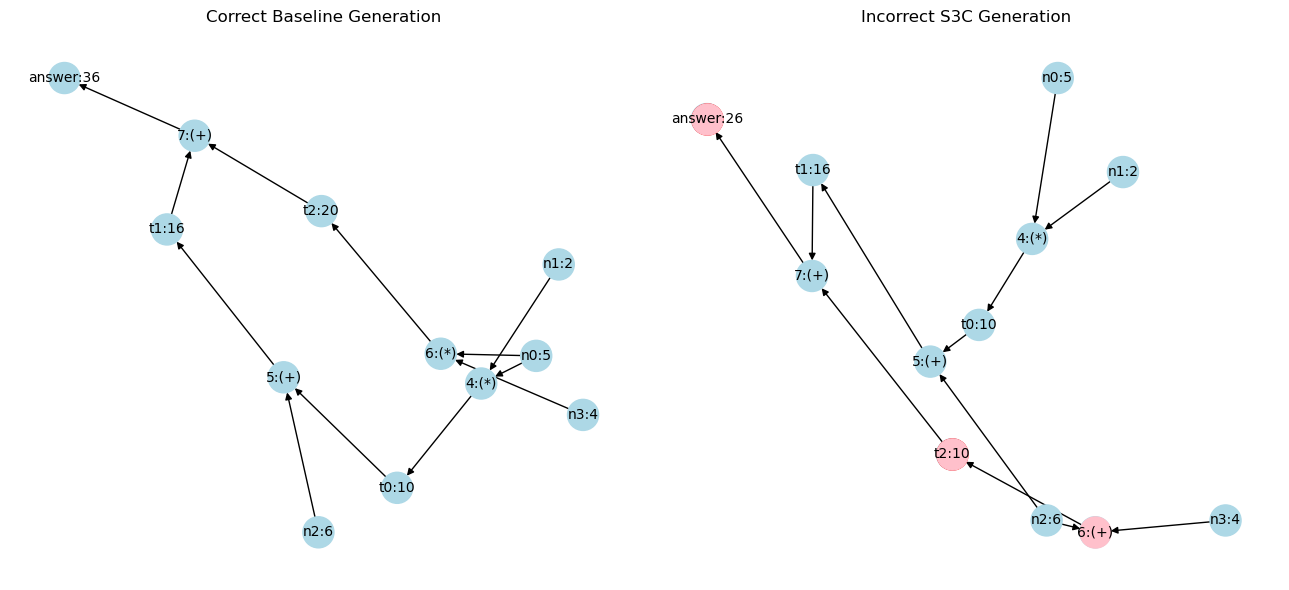

Unique nodes in Baseline Graph: {'t2', 'answer', '6:(*)'}
Unique nodes in S3C Graph: {'6:(+)', 't2', 'answer'}
Unique edges in Baseline Graph: {('6:(*)', 't2'), ('n3', '6:(*)'), ('n0', '6:(*)')}
Unique edges in S3C Graph: {('n3', '6:(+)'), ('n2', '6:(+)'), ('6:(+)', 't2')}
Basline Generated Answer: 36, S3C Generated Answer: 26, GT Answer 36.0
----------------------------------------------------------------


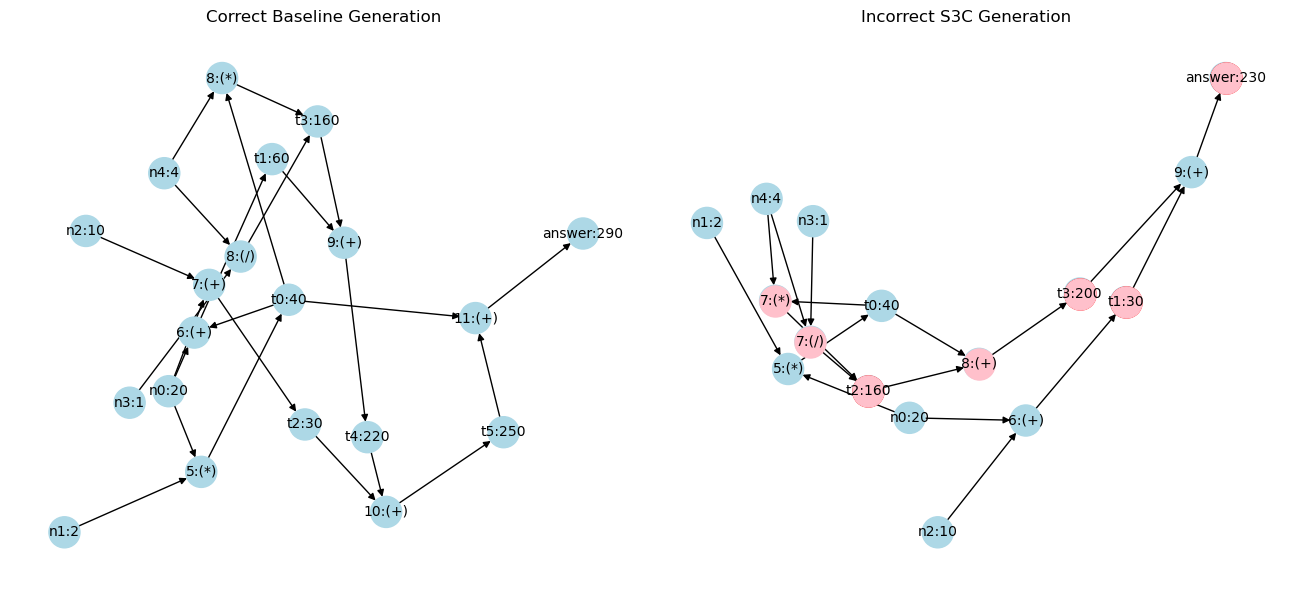

Unique nodes in Baseline Graph: {'8:(*)', 't2', '7:(+)', '10:(+)', '11:(+)', 't5', 'answer', 't4', 't3', 't1', '8:(/)'}
Unique nodes in S3C Graph: {'7:(*)', '7:(/)', 't2', 't3', '8:(+)', 't1', 'answer'}
Unique edges in Baseline Graph: {('n0', '7:(+)'), ('t0', '6:(+)'), ('8:(*)', 't3'), ('n3', '8:(/)'), ('t0', '8:(*)'), ('t5', '11:(+)'), ('9:(+)', 't4'), ('t2', '10:(+)'), ('8:(/)', 't3'), ('t4', '10:(+)'), ('t0', '11:(+)'), ('11:(+)', 'answer'), ('n4', '8:(*)'), ('10:(+)', 't5'), ('n4', '8:(/)'), ('7:(+)', 't2'), ('n2', '7:(+)')}
Unique edges in S3C Graph: {('n3', '7:(/)'), ('t2', '8:(+)'), ('n2', '6:(+)'), ('t0', '7:(*)'), ('7:(/)', 't2'), ('9:(+)', 'answer'), ('t0', '8:(+)'), ('n4', '7:(/)'), ('7:(*)', 't2'), ('8:(+)', 't3'), ('n4', '7:(*)')}
Basline Generated Answer: 140.0, S3C Generated Answer: 80.0, GT Answer 140.0
----------------------------------------------------------------


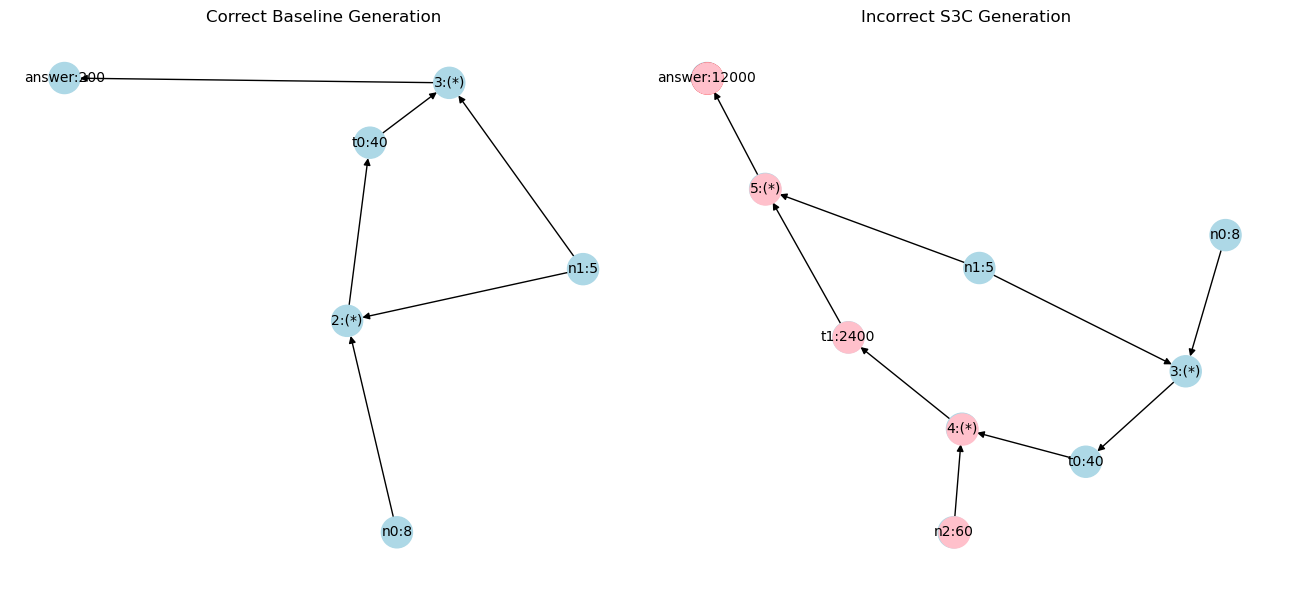

Unique nodes in Baseline Graph: {'answer', '2:(*)'}
Unique nodes in S3C Graph: {'n2', '4:(*)', '5:(*)', 't1', 'answer'}
Unique edges in Baseline Graph: {('t0', '3:(*)'), ('2:(*)', 't0'), ('n0', '2:(*)'), ('n1', '2:(*)'), ('3:(*)', 'answer')}
Unique edges in S3C Graph: {('n0', '3:(*)'), ('5:(*)', 'answer'), ('t0', '4:(*)'), ('n2', '4:(*)'), ('4:(*)', 't1'), ('t1', '5:(*)'), ('3:(*)', 't0'), ('n1', '5:(*)')}
Basline Generated Answer: 200, S3C Generated Answer: 12000, GT Answer 200.0
----------------------------------------------------------------


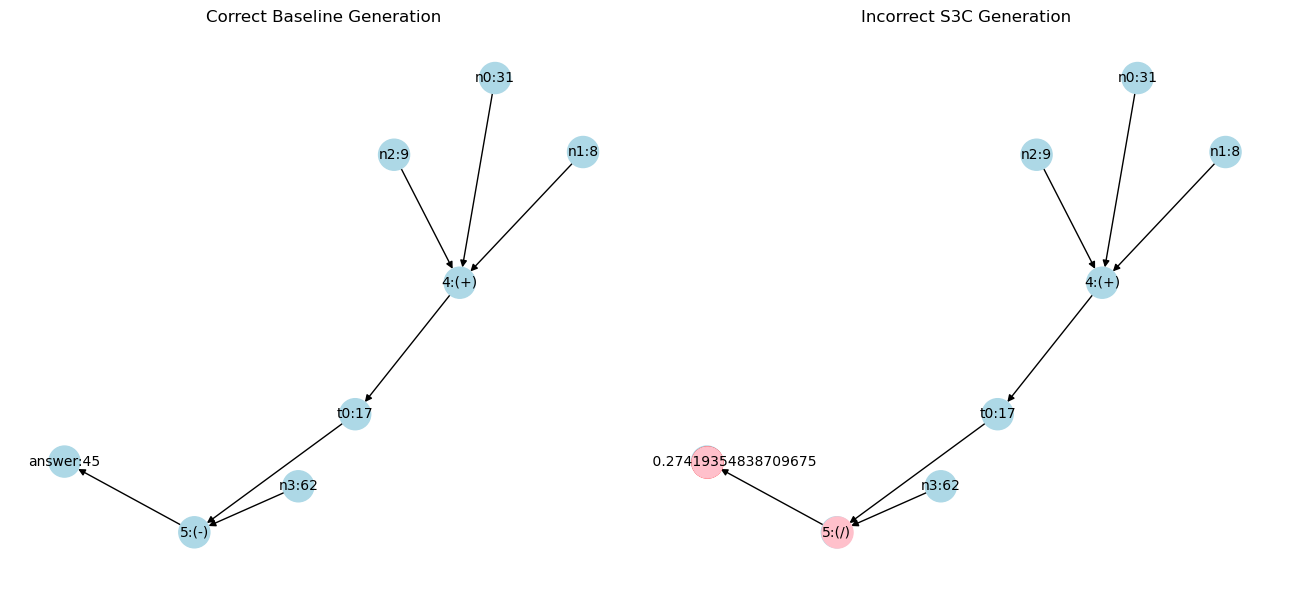

Unique nodes in Baseline Graph: {'5:(-)', 'answer'}
Unique nodes in S3C Graph: {'answer', '5:(/)'}
Unique edges in Baseline Graph: {('5:(-)', 'answer'), ('t0', '5:(-)'), ('n3', '5:(-)')}
Unique edges in S3C Graph: {('t0', '5:(/)'), ('n3', '5:(/)'), ('5:(/)', 'answer')}
Basline Generated Answer: 14, S3C Generated Answer: 0.7741935483870968, GT Answer 14.0
----------------------------------------------------------------


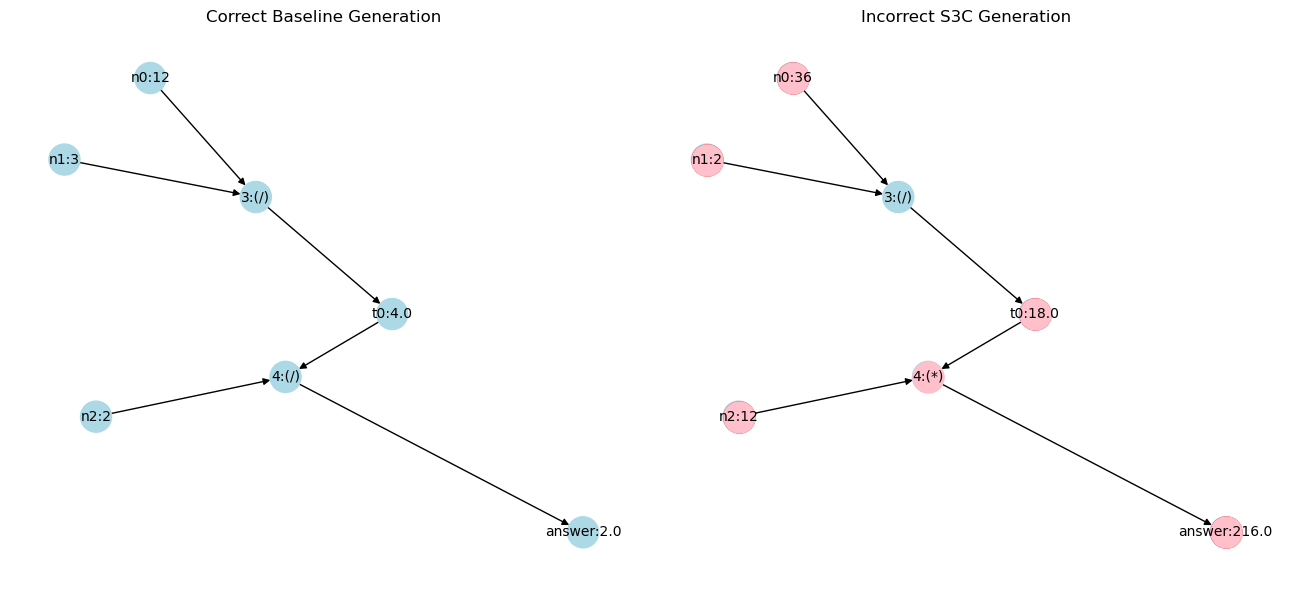

Unique nodes in Baseline Graph: {'n2', 't0', '4:(/)', 'n0', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't0', 'n0', '4:(*)', 'n1', 'answer'}
Unique edges in Baseline Graph: {('t0', '4:(/)'), ('4:(/)', 'answer'), ('n2', '4:(/)')}
Unique edges in S3C Graph: {('n2', '4:(*)'), ('t0', '4:(*)'), ('4:(*)', 'answer')}
Basline Generated Answer: 2.0, S3C Generated Answer: 216.0, GT Answer 2.0
----------------------------------------------------------------


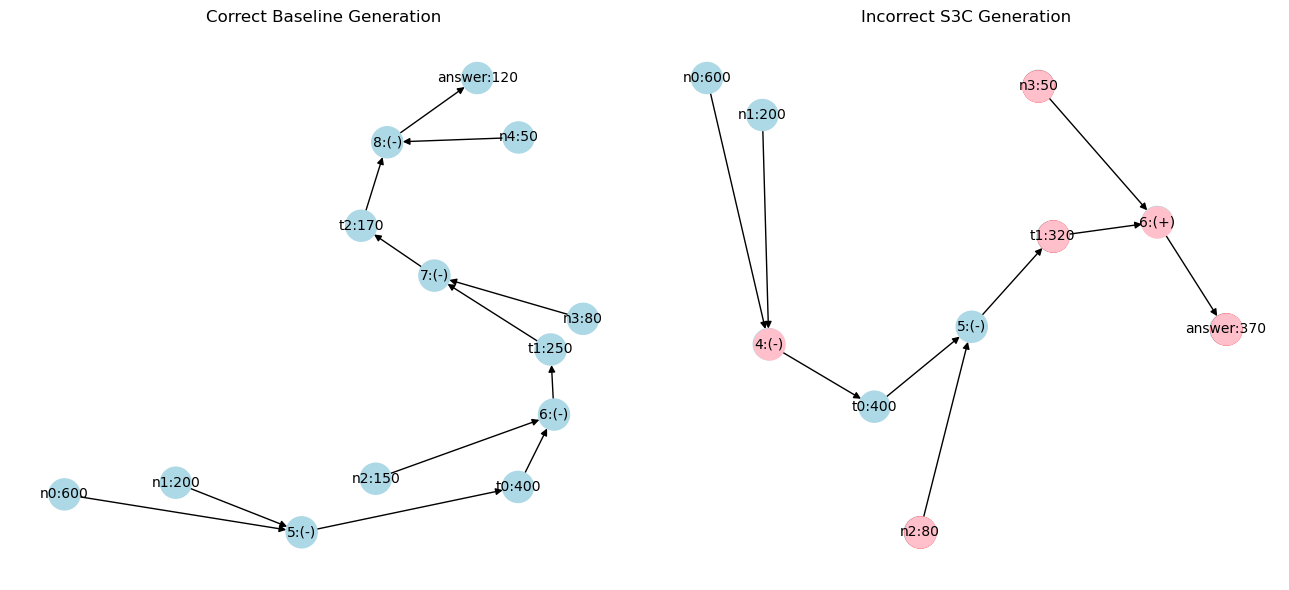

Unique nodes in Baseline Graph: {'n3', 'n2', '8:(-)', 't2', '6:(-)', '7:(-)', 'n4', 't1', 'answer'}
Unique nodes in S3C Graph: {'n3', 'n2', '4:(-)', '6:(+)', 't1', 'answer'}
Unique edges in Baseline Graph: {('5:(-)', 't0'), ('t1', '7:(-)'), ('8:(-)', 'answer'), ('n3', '7:(-)'), ('n0', '5:(-)'), ('n4', '8:(-)'), ('7:(-)', 't2'), ('t2', '8:(-)'), ('t0', '6:(-)'), ('6:(-)', 't1'), ('n2', '6:(-)'), ('n1', '5:(-)')}
Unique edges in S3C Graph: {('n1', '4:(-)'), ('t0', '5:(-)'), ('n2', '5:(-)'), ('n0', '4:(-)'), ('5:(-)', 't1'), ('6:(+)', 'answer'), ('4:(-)', 't0'), ('t1', '6:(+)'), ('n3', '6:(+)')}
Basline Generated Answer: 120, S3C Generated Answer: 370, GT Answer 120.0
----------------------------------------------------------------


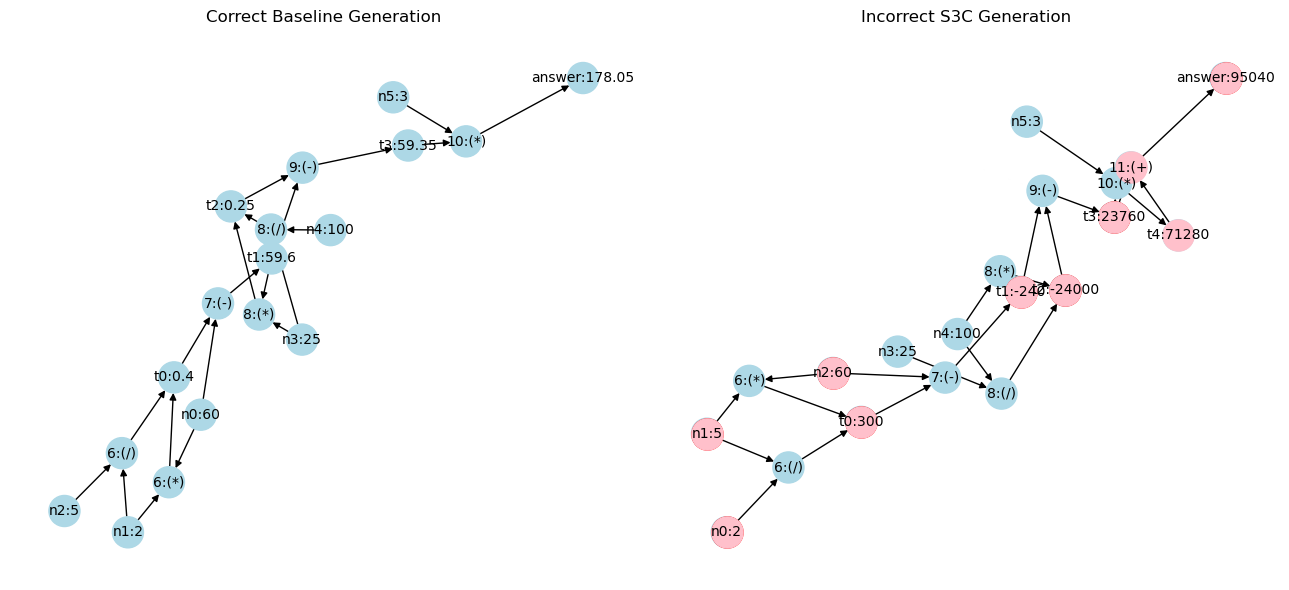

Unique nodes in Baseline Graph: {'n2', 't0', 't2', 'n0', 't3', 't1', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't0', 't2', 'n0', '11:(+)', 't4', 't3', 't1', 'n1', 'answer'}
Unique edges in Baseline Graph: {('n2', '6:(/)'), ('n0', '6:(*)'), ('10:(*)', 'answer'), ('n0', '7:(-)'), ('n3', '8:(*)')}
Unique edges in S3C Graph: {('n0', '6:(/)'), ('t4', '11:(+)'), ('t3', '11:(+)'), ('n2', '7:(-)'), ('10:(*)', 't4'), ('n4', '8:(*)'), ('11:(+)', 'answer'), ('n2', '6:(*)')}
Basline Generated Answer: 81.0, S3C Generated Answer: 108.0, GT Answer 81.0
----------------------------------------------------------------


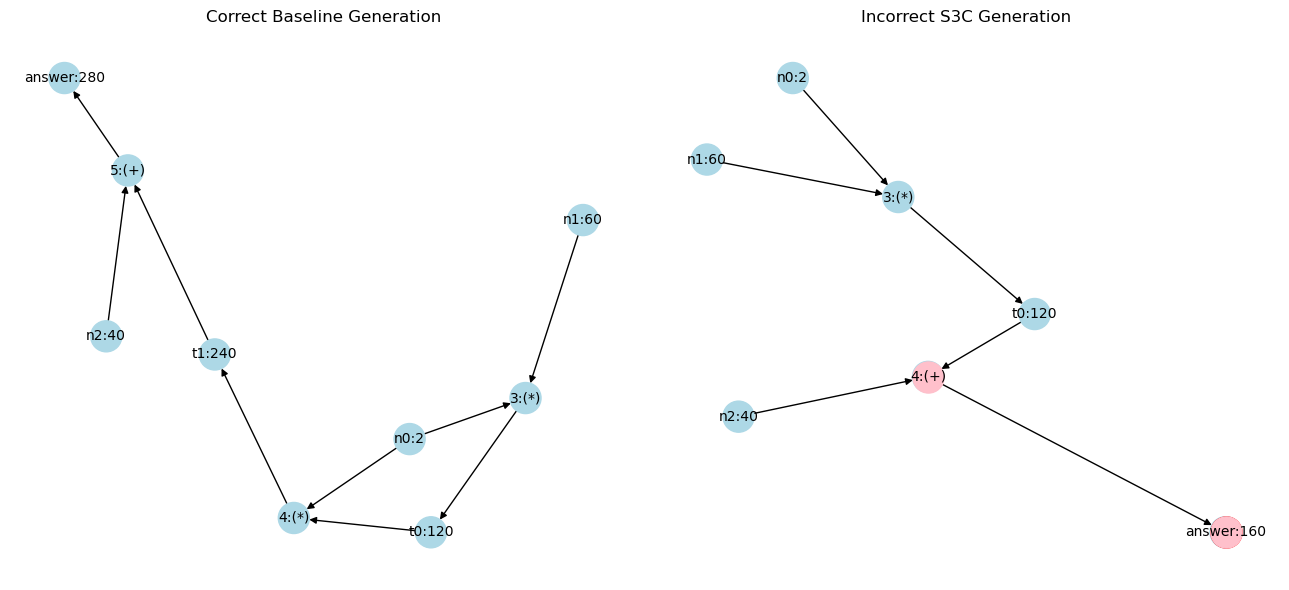

Unique nodes in Baseline Graph: {'4:(*)', 't1', '5:(+)', 'answer'}
Unique nodes in S3C Graph: {'answer', '4:(+)'}
Unique edges in Baseline Graph: {('5:(+)', 'answer'), ('t1', '5:(+)'), ('n2', '5:(+)'), ('t0', '4:(*)'), ('4:(*)', 't1'), ('n0', '4:(*)')}
Unique edges in S3C Graph: {('n2', '4:(+)'), ('4:(+)', 'answer'), ('t0', '4:(+)')}
Basline Generated Answer: 280, S3C Generated Answer: 160, GT Answer 280.0
----------------------------------------------------------------


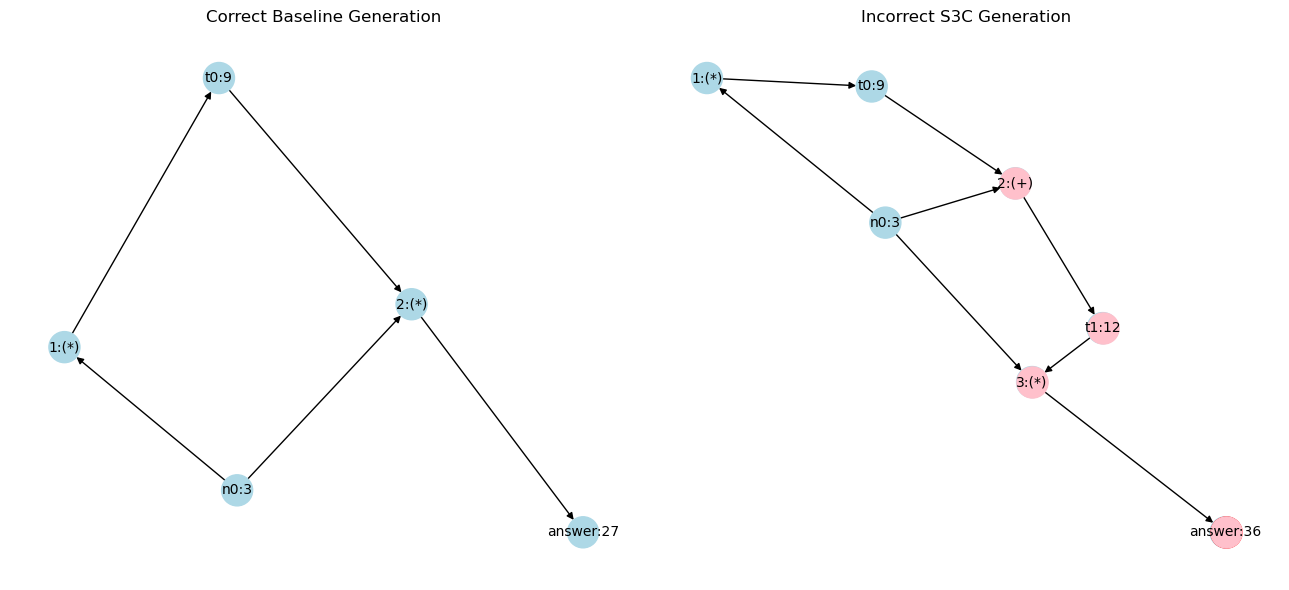

Unique nodes in Baseline Graph: {'answer', '2:(*)'}
Unique nodes in S3C Graph: {'2:(+)', 't1', '3:(*)', 'answer'}
Unique edges in Baseline Graph: {('t0', '2:(*)'), ('2:(*)', 'answer'), ('n0', '2:(*)')}
Unique edges in S3C Graph: {('t0', '2:(+)'), ('n0', '2:(+)'), ('n0', '3:(*)'), ('2:(+)', 't1'), ('t1', '3:(*)'), ('3:(*)', 'answer')}
Basline Generated Answer: 27, S3C Generated Answer: 36, GT Answer 27.0
----------------------------------------------------------------


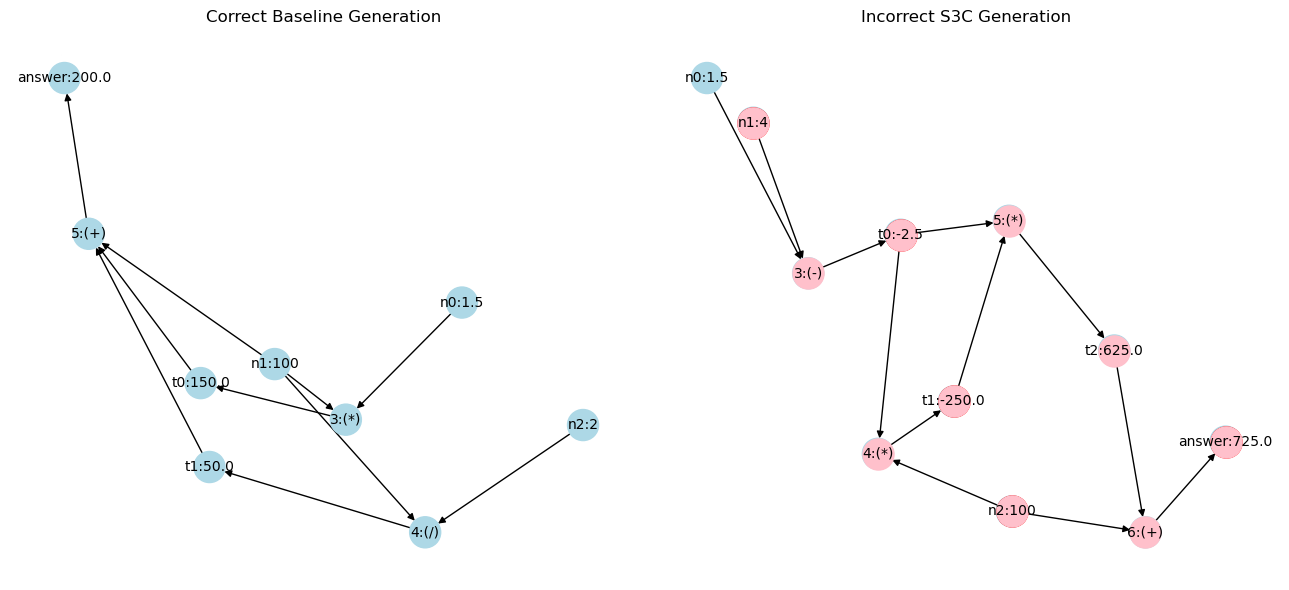

Unique nodes in Baseline Graph: {'n2', 't0', '4:(/)', '3:(*)', '5:(+)', 't1', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't0', 't2', '4:(*)', '5:(*)', '6:(+)', 't1', 'n1', 'answer', '3:(-)'}
Unique edges in Baseline Graph: {('5:(+)', 'answer'), ('t1', '5:(+)'), ('n1', '5:(+)'), ('n1', '4:(/)'), ('n0', '3:(*)'), ('t0', '5:(+)'), ('n2', '4:(/)'), ('4:(/)', 't1'), ('n1', '3:(*)'), ('3:(*)', 't0')}
Unique edges in S3C Graph: {('n2', '6:(+)'), ('t0', '5:(*)'), ('6:(+)', 'answer'), ('n0', '3:(-)'), ('3:(-)', 't0'), ('t0', '4:(*)'), ('t2', '6:(+)'), ('n2', '4:(*)'), ('4:(*)', 't1'), ('t1', '5:(*)'), ('n1', '3:(-)'), ('5:(*)', 't2')}
Basline Generated Answer: 300.0, S3C Generated Answer: 725.0, GT Answer 300.0
----------------------------------------------------------------


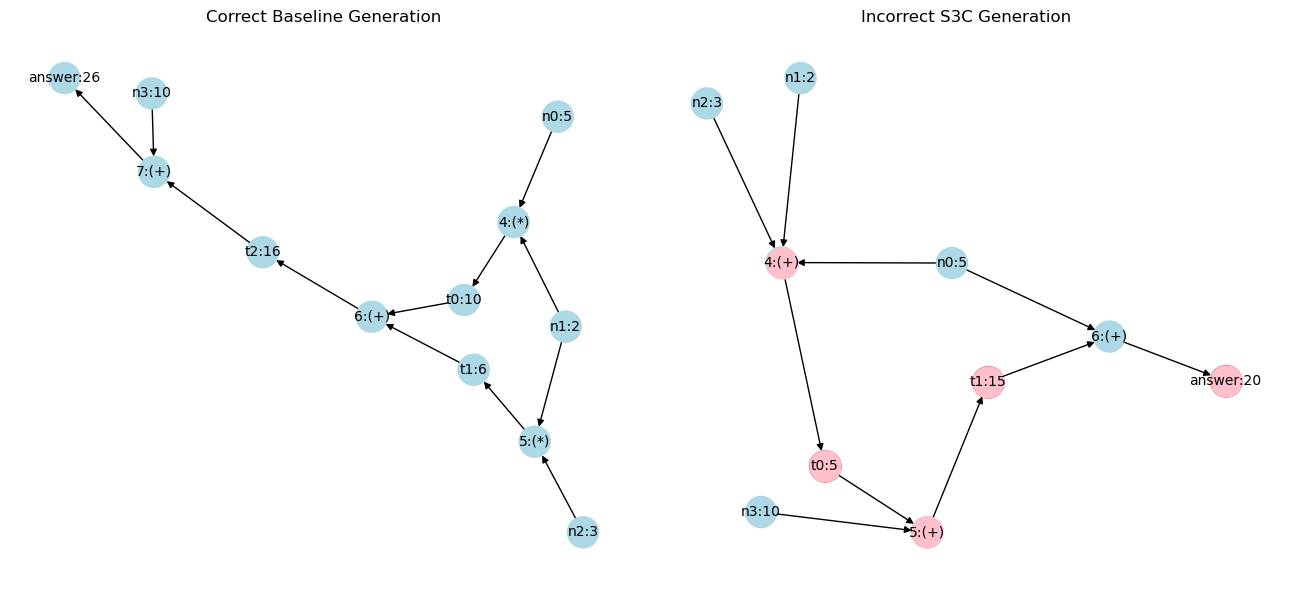

Unique nodes in Baseline Graph: {'t0', 't2', '7:(+)', '4:(*)', '5:(*)', 't1', 'answer'}
Unique nodes in S3C Graph: {'t0', '4:(+)', '5:(+)', 't1', 'answer'}
Unique edges in Baseline Graph: {('t0', '6:(+)'), ('5:(*)', 't1'), ('n2', '5:(*)'), ('4:(*)', 't0'), ('6:(+)', 't2'), ('t2', '7:(+)'), ('n1', '4:(*)'), ('7:(+)', 'answer'), ('n3', '7:(+)'), ('n0', '4:(*)'), ('n1', '5:(*)')}
Unique edges in S3C Graph: {('n1', '4:(+)'), ('5:(+)', 't1'), ('4:(+)', 't0'), ('n3', '5:(+)'), ('6:(+)', 'answer'), ('n0', '6:(+)'), ('n2', '4:(+)'), ('t0', '5:(+)'), ('n0', '4:(+)')}
Basline Generated Answer: 26, S3C Generated Answer: 25, GT Answer 26.0
----------------------------------------------------------------


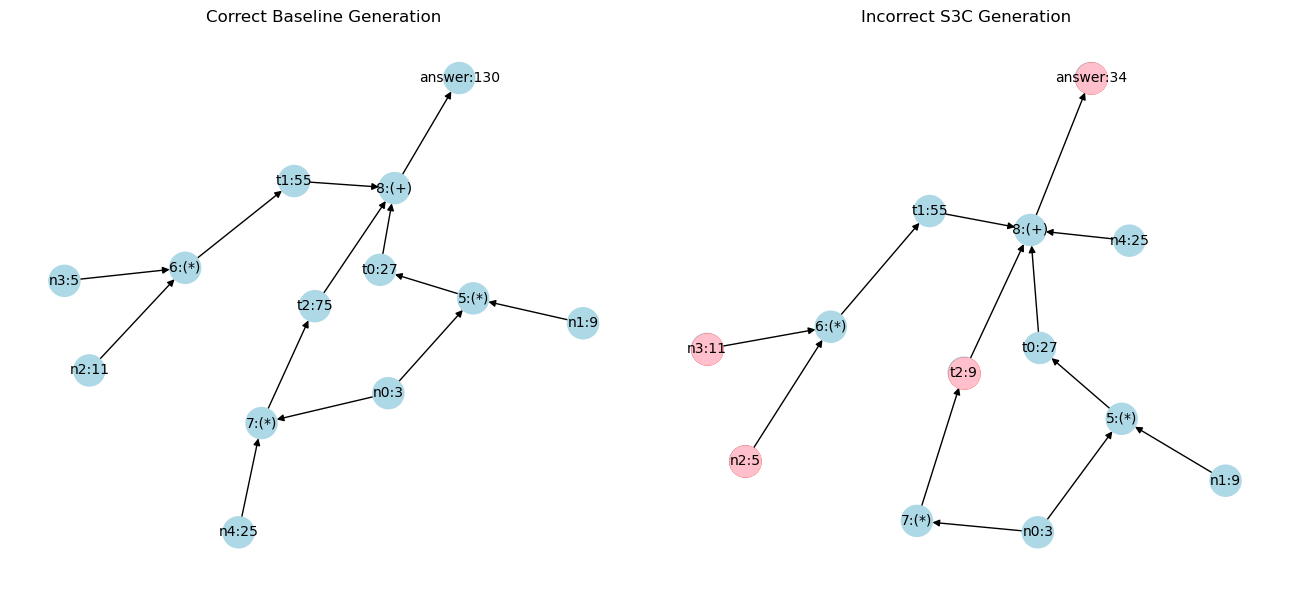

Unique nodes in Baseline Graph: {'n3', 't2', 'n2', 'answer'}
Unique nodes in S3C Graph: {'n3', 't2', 'n2', 'answer'}
Unique edges in Baseline Graph: {('n4', '7:(*)')}
Unique edges in S3C Graph: {('n4', '8:(+)')}
Basline Generated Answer: 157, S3C Generated Answer: 116, GT Answer 157.0
----------------------------------------------------------------


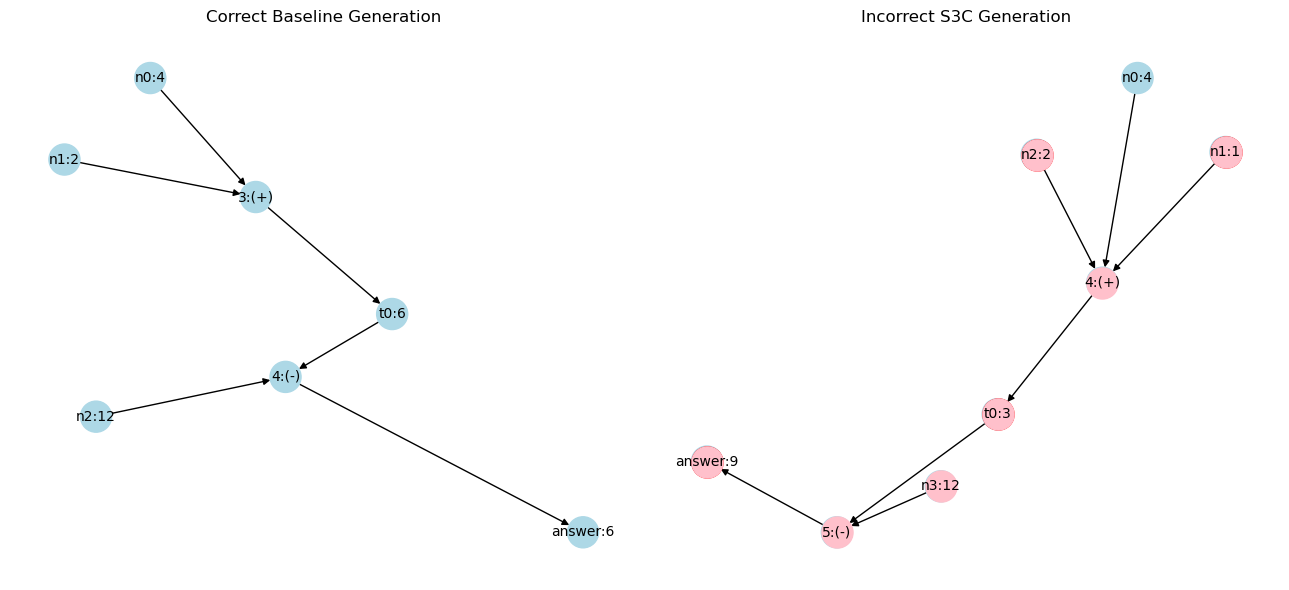

Unique nodes in Baseline Graph: {'n2', 't0', '3:(+)', '4:(-)', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n3', 'n2', 't0', '5:(-)', '4:(+)', 'n1', 'answer'}
Unique edges in Baseline Graph: {('t0', '4:(-)'), ('3:(+)', 't0'), ('n2', '4:(-)'), ('n0', '3:(+)'), ('4:(-)', 'answer'), ('n1', '3:(+)')}
Unique edges in S3C Graph: {('5:(-)', 'answer'), ('t0', '5:(-)'), ('n1', '4:(+)'), ('4:(+)', 't0'), ('n2', '4:(+)'), ('n0', '4:(+)'), ('n3', '5:(-)')}
Basline Generated Answer: 6, S3C Generated Answer: 5, GT Answer 6.0
----------------------------------------------------------------


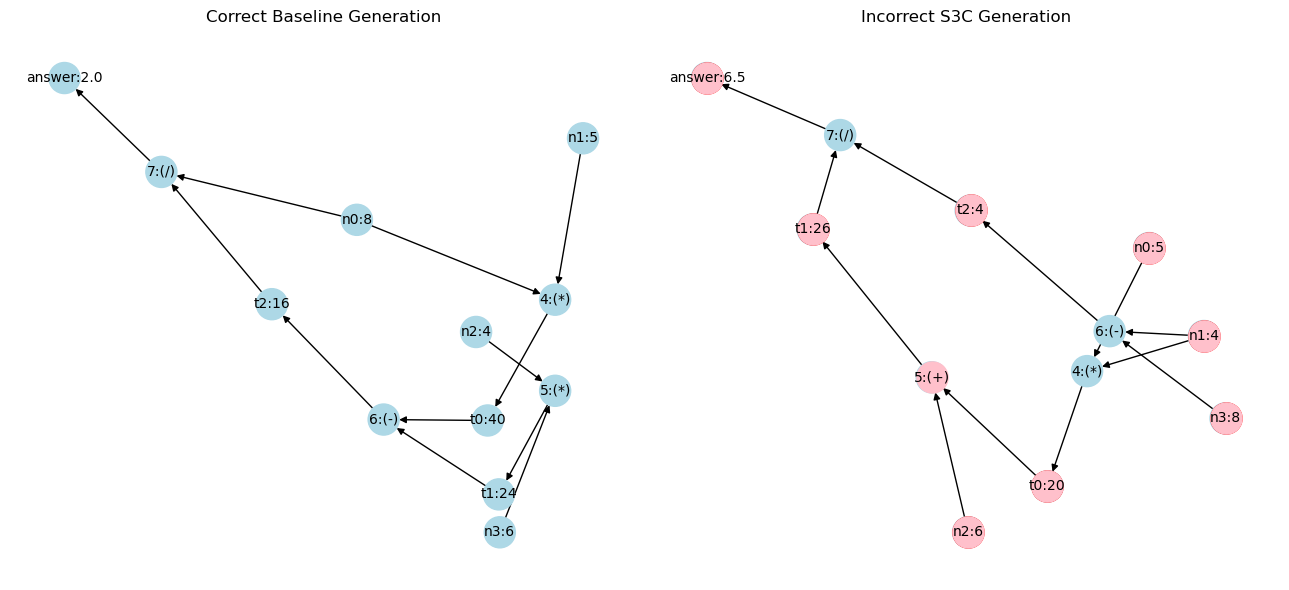

Unique nodes in Baseline Graph: {'n3', 'n2', 't0', 't2', 'n0', '5:(*)', 't1', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n3', 'n2', 't0', 't2', 'n0', '5:(+)', 't1', 'n1', 'answer'}
Unique edges in Baseline Graph: {('t1', '6:(-)'), ('n2', '5:(*)'), ('n3', '5:(*)'), ('n0', '7:(/)'), ('t0', '6:(-)'), ('5:(*)', 't1')}
Unique edges in S3C Graph: {('n1', '6:(-)'), ('5:(+)', 't1'), ('n3', '6:(-)'), ('t0', '5:(+)'), ('n2', '5:(+)'), ('t1', '7:(/)')}
Basline Generated Answer: 2.0, S3C Generated Answer: 6.5, GT Answer 2.0
----------------------------------------------------------------


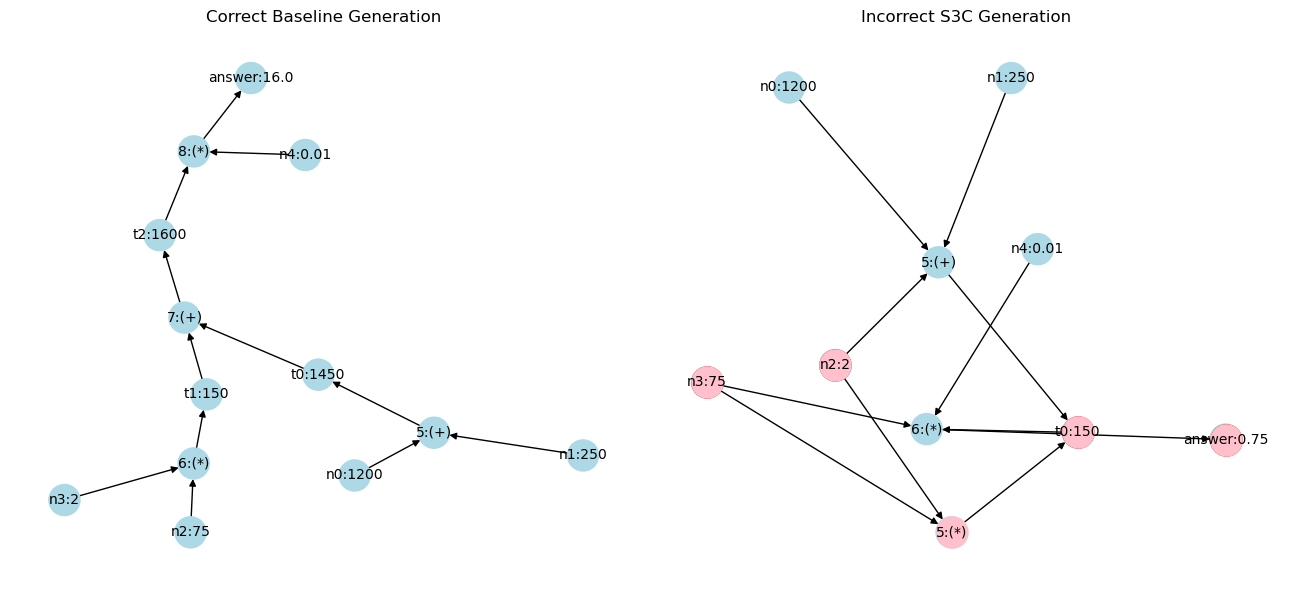

Unique nodes in Baseline Graph: {'n3', '8:(*)', 'n2', 't0', 't2', '7:(+)', 't1', 'answer'}
Unique nodes in S3C Graph: {'n3', 'n2', 't0', '5:(*)', 'answer'}
Unique edges in Baseline Graph: {('6:(*)', 't1'), ('8:(*)', 'answer'), ('t1', '7:(+)'), ('n4', '8:(*)'), ('t2', '8:(*)'), ('t0', '7:(+)'), ('7:(+)', 't2'), ('n2', '6:(*)')}
Unique edges in S3C Graph: {('t0', '6:(*)'), ('n2', '5:(*)'), ('5:(*)', 't0'), ('n4', '6:(*)'), ('n2', '5:(+)'), ('6:(*)', 'answer'), ('n3', '5:(*)')}
Basline Generated Answer: 16.0, S3C Generated Answer: 1200.0, GT Answer 16.0
----------------------------------------------------------------


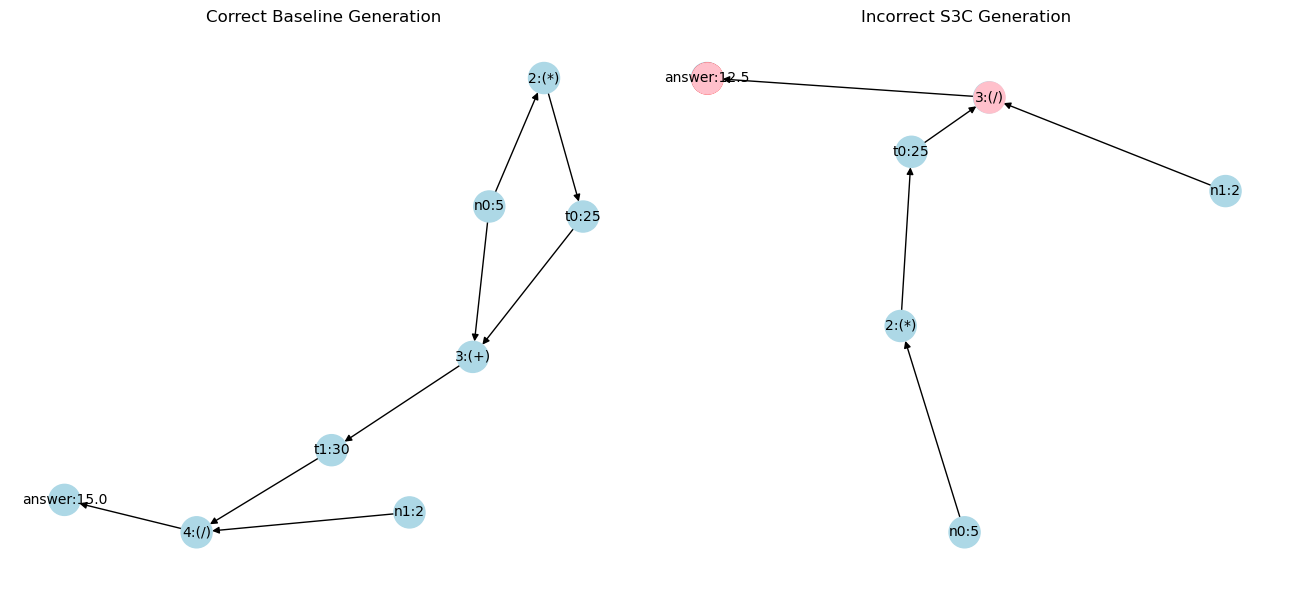

Unique nodes in Baseline Graph: {'3:(+)', 't1', '4:(/)', 'answer'}
Unique nodes in S3C Graph: {'answer', '3:(/)'}
Unique edges in Baseline Graph: {('t0', '3:(+)'), ('t1', '4:(/)'), ('n1', '4:(/)'), ('n0', '3:(+)'), ('3:(+)', 't1'), ('4:(/)', 'answer')}
Unique edges in S3C Graph: {('n1', '3:(/)'), ('3:(/)', 'answer'), ('t0', '3:(/)')}
Basline Generated Answer: 15.0, S3C Generated Answer: 12.5, GT Answer 15.0
----------------------------------------------------------------


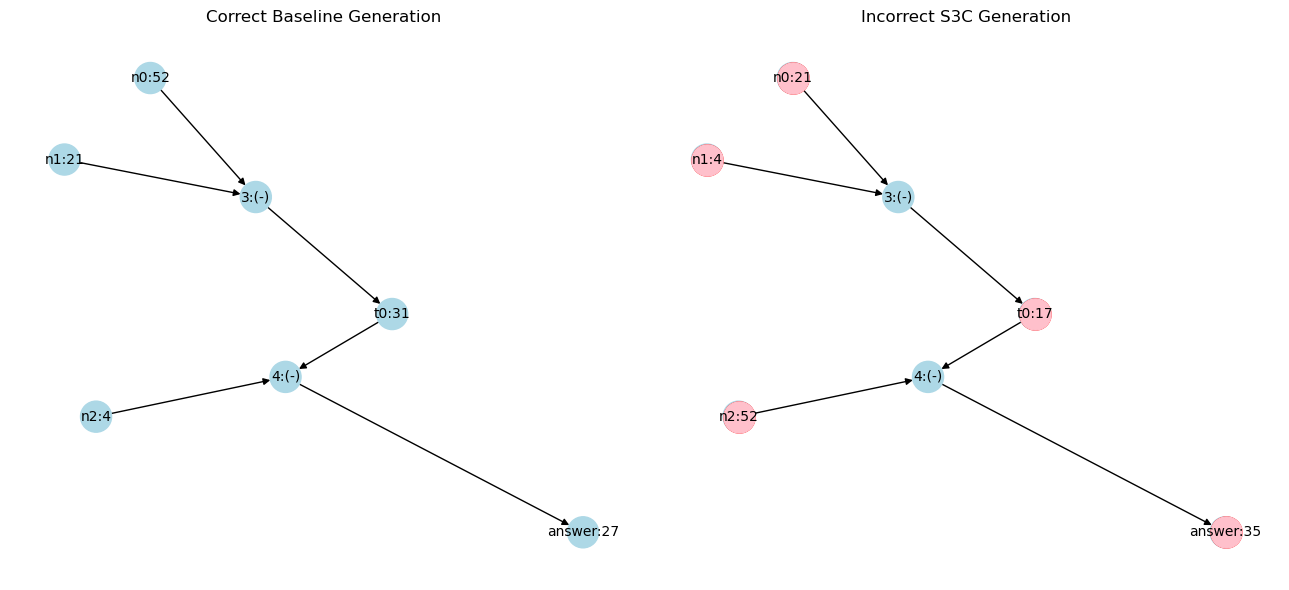

Unique nodes in Baseline Graph: {'n2', 't0', 'n0', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n2', 't0', 'n0', 'n1', 'answer'}
Unique edges in Baseline Graph: set()
Unique edges in S3C Graph: set()
Basline Generated Answer: 27, S3C Generated Answer: 35, GT Answer 27.0
----------------------------------------------------------------


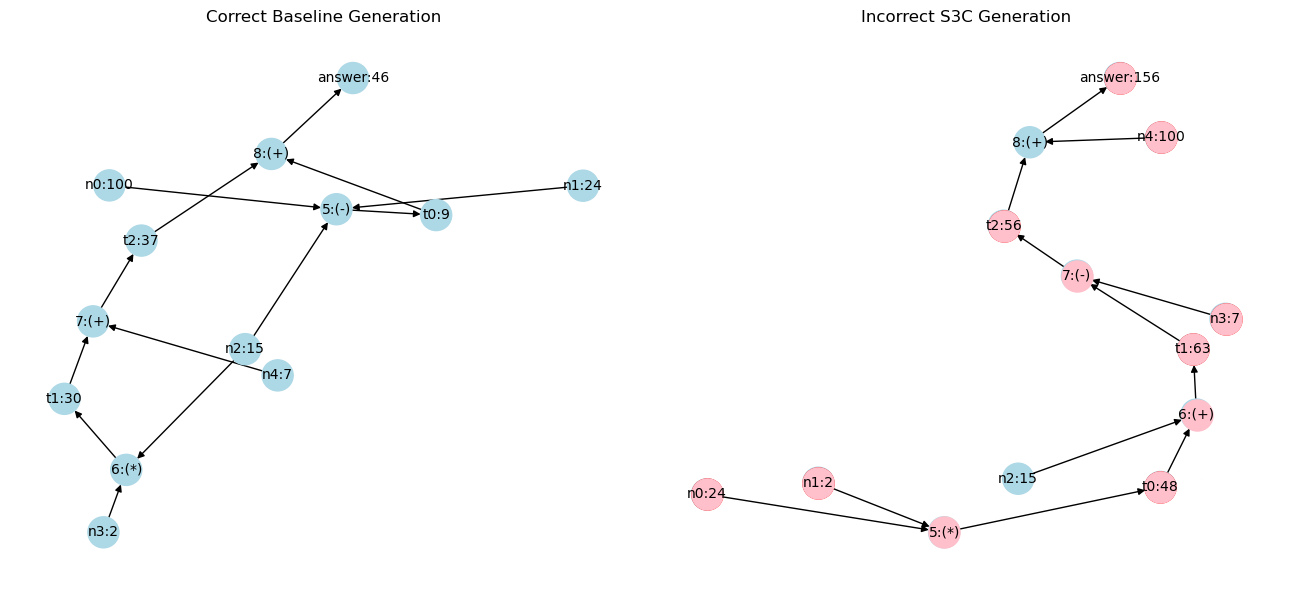

Unique nodes in Baseline Graph: {'n3', 't0', '5:(-)', 't2', '7:(+)', 'n0', '6:(*)', 'n4', 't1', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n3', 't0', '6:(+)', 't2', 'n0', '7:(-)', '5:(*)', 'n4', 't1', 'n1', 'answer'}
Unique edges in Baseline Graph: {('5:(-)', 't0'), ('6:(*)', 't1'), ('n2', '5:(-)'), ('n0', '5:(-)'), ('n4', '7:(+)'), ('t0', '8:(+)'), ('t1', '7:(+)'), ('n3', '6:(*)'), ('n1', '5:(-)'), ('7:(+)', 't2'), ('n2', '6:(*)')}
Unique edges in S3C Graph: {('n4', '8:(+)'), ('t0', '6:(+)'), ('t1', '7:(-)'), ('n2', '6:(+)'), ('n3', '7:(-)'), ('7:(-)', 't2'), ('5:(*)', 't0'), ('n0', '5:(*)'), ('6:(+)', 't1'), ('n1', '5:(*)')}
Basline Generated Answer: 98, S3C Generated Answer: 156, GT Answer 98.0
----------------------------------------------------------------


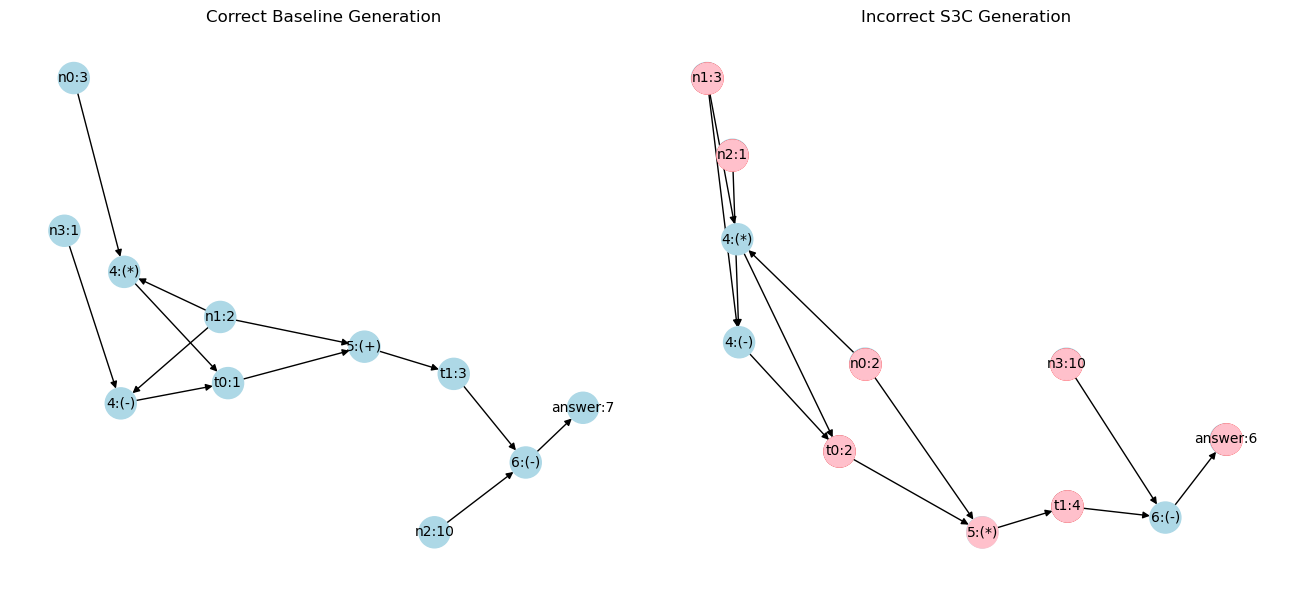

Unique nodes in Baseline Graph: {'n3', 'n2', 't0', 'n0', '5:(+)', 't1', 'n1', 'answer'}
Unique nodes in S3C Graph: {'n3', 'n2', 't0', 'n0', '5:(*)', 't1', 'n1', 'answer'}
Unique edges in Baseline Graph: {('n3', '4:(-)'), ('5:(+)', 't1'), ('n1', '5:(+)'), ('n2', '6:(-)'), ('t0', '5:(+)')}
Unique edges in S3C Graph: {('t0', '5:(*)'), ('n3', '6:(-)'), ('n2', '4:(-)'), ('n0', '5:(*)'), ('5:(*)', 't1')}
Basline Generated Answer: 3, S3C Generated Answer: 0, GT Answer 3.0
----------------------------------------------------------------


ValueError: could not convert string to float: 'n0'

In [77]:
print_graph_comparisons(ft_intersection, baseline_dict, s3c_dict, correct_baseline_clusters, incorrect_s3c_clusters)